# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Обзор данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [5]:
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_columns = None

In [6]:
raw_data = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')
raw_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   посёлок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим гистограмму для всех числовых столбцов таблицы на одном графике.

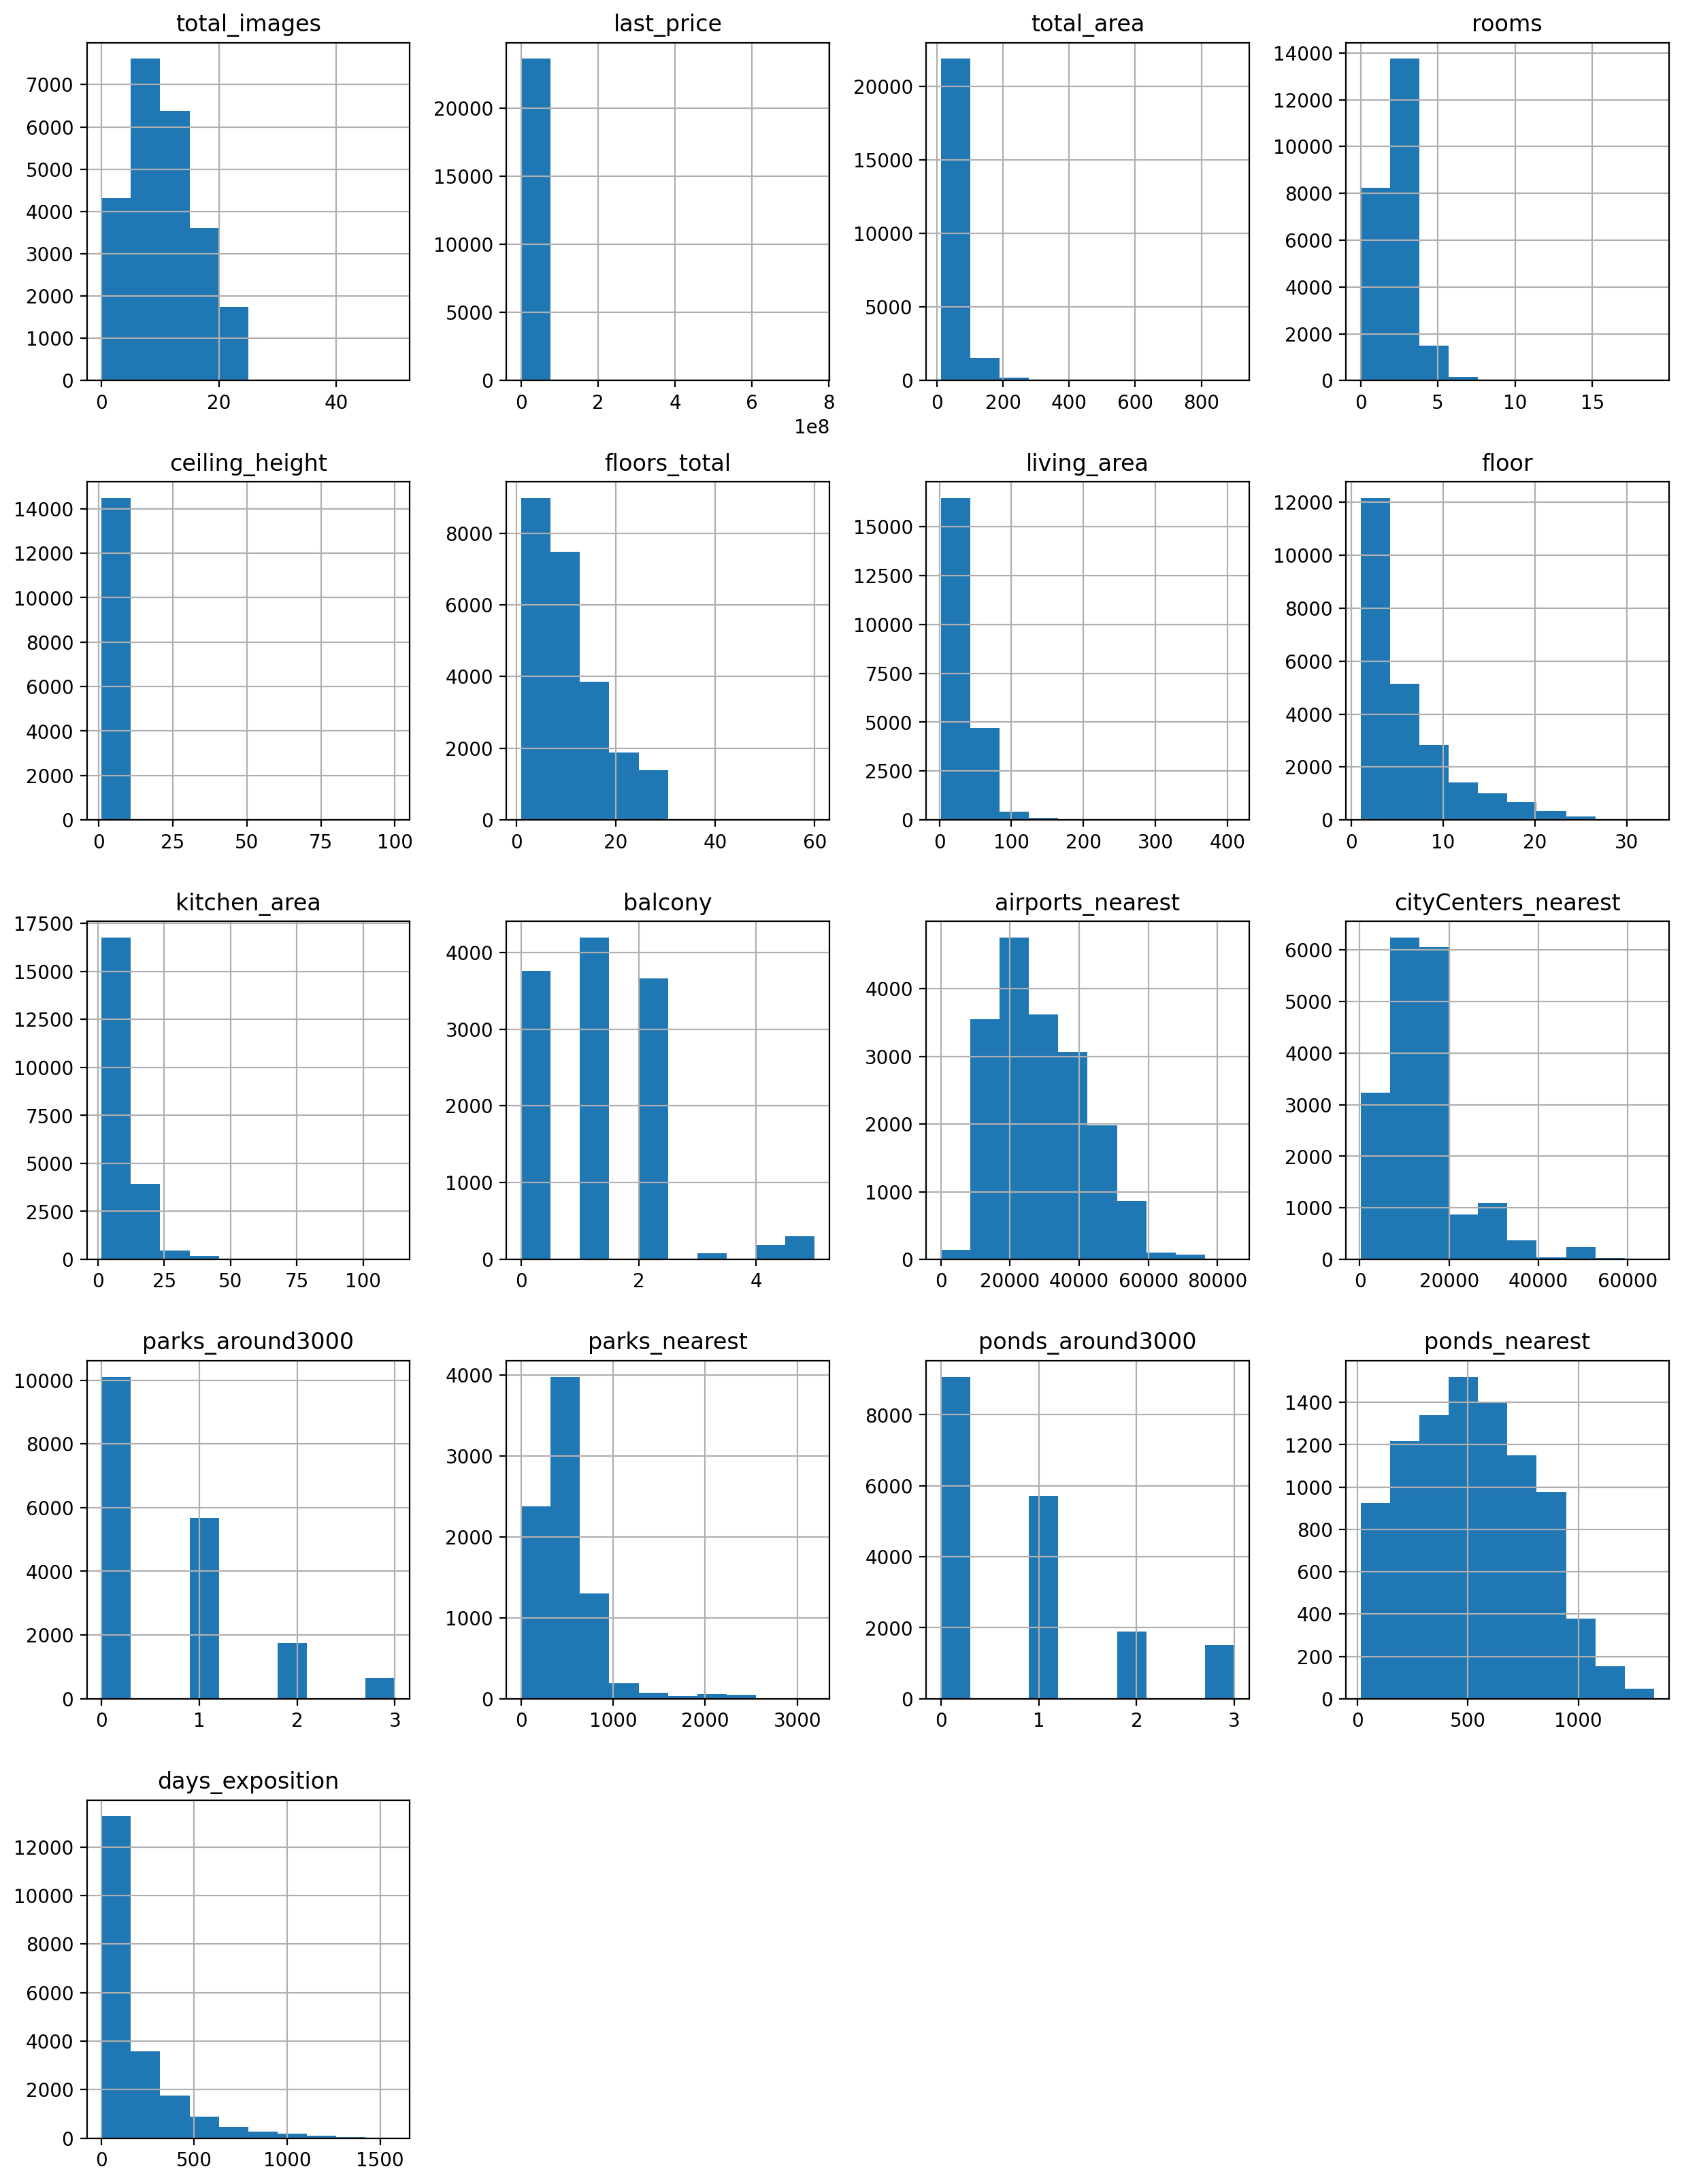

In [9]:
raw_data.hist(figsize=(15, 20));

К анализу отдельных параметров и их взаимосвязей приступим чуть позже, а для начала займемся предобработкой данных.

## Предобработка данных

In [12]:
prepared_data = raw_data.copy()

### Названия и порядок столбцов

Переименуем для удобства некоторые столбцы(например, `cityCenters_nearest` переведем в snake_case, булевы столбцы начнем с `is_` и так далее). Изменим порядок столбцов.

In [15]:
prepared_data = prepared_data.rename(columns={
    'total_images': 'images',
    'first_day_exposition': 'exposition_date',
    'floors_total': 'floors',
    'studio': 'is_studio',
    'open_plan': 'is_open_plan',
    'balcony': 'balconies',
    'airports_nearest': 'airport_distance_m',
    'cityCenters_nearest': 'city_center_distance_m',
    'parks_nearest': 'park_distance_m',
    'ponds_nearest': 'pond_distance_m',
    'parks_around3000': 'parks_around_3000_m',
    'ponds_around3000': 'ponds_around_3000_m',
    'days_exposition': 'exposition_duration_days'
})

prepared_data = prepared_data[[
    'total_area', 'living_area', 'kitchen_area', 
    'rooms', 'balconies', 'floor', 'floors', 'ceiling_height',
    'is_apartment', 'is_studio', 'is_open_plan', 
    'locality_name', 'city_center_distance_m', 'airport_distance_m', 'park_distance_m', 'parks_around_3000_m', 'pond_distance_m', 'ponds_around_3000_m', 
    'images', 
    'exposition_date', 'exposition_duration_days', 
    'last_price'
]]

In [16]:
prepared_data.head()

total_area  living_area  kitchen_area  rooms  balconies  floor  floors  \
0       108.0         51.0          25.0      3        NaN      8    16.0   
1        40.4         18.6          11.0      1        2.0      1    11.0   
2        56.0         34.3           8.3      2        0.0      4     5.0   
3       159.0          NaN           NaN      3        0.0      9    14.0   
4       100.0         32.0          41.0      2        NaN     13    14.0   

   ceiling_height is_apartment  is_studio  is_open_plan    locality_name  \
0            2.70          NaN      False         False  Санкт-Петербург   
1             NaN          NaN      False         False   посёлок Шушары   
2             NaN          NaN      False         False  Санкт-Петербург   
3             NaN          NaN      False         False  Санкт-Петербург   
4            3.03          NaN      False         False  Санкт-Петербург   

   city_center_distance_m  airport_distance_m  park_distance_m  \
0                 16028.0             18863.0            482.0   
1                 18603.0             12817.0              NaN   
2                 13933.0             21741.0             90.0   
3                  6800.0             28098.0             84.0   
4                  8098.0             31856.0            112.0   

   parks_around_3000_m  pond_distance_m  ponds_around_3000_m  images  \
0                  1.0            755.0                  2.0      20   
1                  0.0              NaN                  0.0       7   
2                  1.0            574.0                  2.0      10   
3                  2.0            234.0                  3.0       0   
4                  2.0             48.0                  1.0       2   

       exposition_date  exposition_duration_days  last_price  
0  2019-03-07T00:00:00                       NaN  13000000.0  
1  2018-12-04T00:00:00                      81.0   3350000.0  
2  2015-08-20T00:00:00                     558.0   5196000.0  
3  2015-07-24T00:00:00                     424.0  64900000.0  
4  2018-06-19T00:00:00                     121.0  10000000.0

### Дубликаты и пропуски в данных

In [18]:
prepared_data.duplicated().sum()

0

Явных дубликатов в данных нет. Но могут быть неявные дубликаты в строковых данных.

In [20]:
prepared_data.isna().sum()

total_area                      0
living_area                  1903
kitchen_area                 2278
rooms                           0
balconies                   11519
floor                           0
floors                         86
ceiling_height               9195
is_apartment                20924
is_studio                       0
is_open_plan                    0
locality_name                  49
city_center_distance_m       5519
airport_distance_m           5542
park_distance_m             15620
parks_around_3000_m          5518
pond_distance_m             14589
ponds_around_3000_m          5518
images                          0
exposition_date                 0
exposition_duration_days     3181
last_price                      0
dtype: int64

Пропущенные значения есть во многих столбцах. Обработаем пропуски и разберемся с причинами пропусков.

#### Название населённого пункта

Данные сервиса Яндекс Недвижимость не содержат координат, а автоматически заполненные картографические данные не позволяют однозначно идентифицировать населённый пункт — поэтому восстановить пропущенные значения не получится.

Удалим записи с пропусками в название населённого пункта. Причины пропусков скорее всего технологические: некорректный перенос из одной базы в другую, может быть служебные символы в названии помешали в процессе выгрузки и так далее.

In [24]:
prepared_data = prepared_data.dropna(subset=['locality_name'])

Найдем неявные дубликаты. Предварительно заменим `ё` на `е`.

In [26]:
prepared_data['locality_name'] = prepared_data['locality_name'].str.replace("ё", "е")

In [27]:
# сформируем словарь с различными вариантами написаний населенных пунктов
variants = {}
for locality_name in prepared_data[prepared_data['locality_name'].notna()]['locality_name'].unique():
    # выделим из строки с названием само название (которое с большой буквы)
    title = " ".join([word for word in locality_name.split() if word[0].isupper()])
    if title in variants:
        variants[title].append(locality_name)
    else:
        variants[title] = [locality_name]

# выведем населенные пункты, у которых несколько вариантов написания
[f'{x}: {", ".join(y)}' for x, y in variants.items() if len(y) > 1]

['Мурино: поселок Мурино, Мурино',
 'Кудрово: деревня Кудрово, Кудрово',
 'Федоровское: деревня Федоровское, городской поселок Федоровское',
 'Никольское: Никольское, село Никольское',
 'Рощино: поселок городского типа Рощино, городской поселок Рощино',
 'Павлово: село Павлово, городской поселок Павлово, поселок городского типа Павлово',
 'Советский: поселок городского типа Советский, городской поселок Советский',
 'Большая Ижора: городской поселок Большая Ижора, поселок городского типа Большая Ижора',
 'Лесогорский: городской поселок Лесогорский, поселок городского типа Лесогорский',
 'Рахья: поселок городского типа Рахья, садовое товарищество Рахья',
 'Зимитицы: поселок Зимитицы, деревня Зимитицы',
 'Рябово: поселок Рябово, поселок городского типа Рябово',
 'Мга: городской поселок Мга, поселок городского типа Мга',
 'Вещево: поселок станции Вещево, поселок при железнодорожной станции Вещево',
 'Калитино: деревня Калитино, поселок Калитино',
 'Приладожский: поселок городского типа При

Интресный факт: в 2018 деревня Кудрово стала городом, в 2019 году поселок Мурино также удостоился чести называться городом.

В названиях населенных пунтов встречаются неявные дубликаты. Например, в данных встречаются различные варианты для Кудрово: «деревня Кудрово» и «Кудрово». Такие ситуации могли возникнуть потому, что часть объявлений была опубликована до переименования населенного пункта, а часть — после.

Однако часть названий, несмотря на схожесть, дубликатами не являются. Например, «поселок Рябово» и «поселок городского типа Рябово» — это разные населенные пункты, один находится в Выборгском районе, другой — в Тосненском. Так что увлекаться склейкой названий не будем.

Устраним неявные дубликаты.

In [29]:
prepared_data['locality_name'] = (
    prepared_data['locality_name']
    .str.replace("поселок станции", "поселок при железнодорожной станции")
    .str.replace("поселок при станции", "поселок при железнодорожной станции")
    .str.replace("поселок городского типа", "городской поселок")
    .str.replace("поселок Мурино", "Мурино")
    .str.replace("деревня Кудрово", "Кудрово")
    .str.replace("деревня Федоровское", "городской поселок Федоровское")
    .str.replace("садовое товарищество Приладожский", "садовое товарищество Приладожское")
    .str.replace("поселок Гарболово", "деревня Гарболово")
)

#### Жилая площадь

Обработаем пропуски в жилой площади. Предположим, что чем больше квартира — тем больше жилая площадь. Посмотрим на коэффициент корреляции между общей площадями — жилой и общей.

In [32]:
prepared_data['living_area'].corr(prepared_data['total_area'])

0.9395341841776421

Коэффициент корреляции Пирсона для столбцов `living_area` и `total_area` близок к 1 как никода. Заполним пропуски в жилой площади на основе доли от общей площади, округлим значения до двух знаков после запятой.

In [34]:
living_area_ratio = prepared_data['living_area'].median() / prepared_data['total_area'].median()
prepared_data['living_area'] = (
    prepared_data['living_area']
    .fillna(prepared_data['total_area'] * living_area_ratio)
    .round(2)
)

Причина пропусков в жилой площади скорее всего в том, что продавцы сами не знали точное значение жилой площади — это же надо смотреть в техпаспорт помещения или заказывать выписку из БТИ. Или же объявления размещали не самые трудолюбивые и педантичные агенты по недвижимости с лозунгом «И таааак сойдет!».

#### Площадь кухни

Обработаем пропуски в площади кухни. Площадь кухни — это часть нежилой площадь. Проверим корреляцию.

In [38]:
prepared_data['kitchen_area'].corr(prepared_data['total_area'] - prepared_data['living_area'])

0.7296252781988587

Коэффициент корреляции между кухонной и нежилой площадями меньше, чем между жилой и общей площадями, но всё же это лучше, чем ничего. Заполним пропуски в площади кухни на основе доли от нежилой площади, округлим значения до двух знаков после запятой.

In [40]:
kitchen_area_ratio = prepared_data['kitchen_area'].median() / (prepared_data['total_area'] - prepared_data['living_area']).median()
prepared_data['kitchen_area'] = (
    prepared_data['kitchen_area']
    .fillna((prepared_data['total_area'] - prepared_data['living_area']) * kitchen_area_ratio)
    .round(2)
)

Причины пропусков в площади кухни аналогичны причинам пропусков в жилой площади.

#### Число балконов

Обработаем пропуски в числе балконов, таких пропусков очень много. Если продавец не указал число балконов, то, скорее всего, в его квартире их просто нет — поэтому при публикации объявления это значение просто не заполнялось. Заодно приведем столбец к целочисленному типу, не может же в квартире быть пол балкона.

In [44]:
prepared_data['balconies'] = prepared_data['balconies'].fillna(0).astype('int')

#### Количество этажей в доме

Обработаем пропуски в этажности. Пропуски могут быть связаны с тем, что это квартиры из домов разной этажности, и продавец просто не смог вписать диапазон этажей (например, «10-12») в поле для значения этажности. 

Поскольку пропущенные значения могу помешать в дальнейшем анализе (при определении последнего этажа), удалим записи с пропусками этажности. Заодно приведём столбец к целочисленному типу.

In [47]:
prepared_data = prepared_data.dropna(subset=['floors'])
prepared_data['floors'] = prepared_data['floors'].astype('int')

Проверим корректность заполения этажа квартиры и общей этажности — очевидно, этаж не должен превышать этажность. Кроме того, этажей в доме должно быть не меньше 1 (землянки не рассматриваем). Ну и квартира должна быть не ниже цокольного (нулевого) этажа.

In [49]:
len(prepared_data[(prepared_data['floor'] > prepared_data['floors']) | (prepared_data['floor'] < 0) | (prepared_data['floors'] < 1)])

0

Отлично, проверка пройдена.

#### Высота потолков

Обработаем пропуски в высоте потолков, таких пропусков очень много. Если продавец не указал высоту потолков, то, скорее всего, на это есть несколько причин:
- Продавец не знал высоту потолков в квартире, а рулетки или лазерного дальномера под рукой не было.
- В квартире разная высота потолков (например, в одной из комнат есть натяжные потолки), и продавец при публикации объявления просто не смог вписать диапазон (например, «2.6-2.7») в поле для высоты потолков.

Каждому типу домов (хрущевские пятиэтажки, типовые панельные шестнадцатиэтажки и так далее) в определенной мере присущи свои конструктивные решения и особенности, в том числе и расстояния между перекрытиями.

Сгруппируем данные по количеству этажей, определим медианную высоту потолков в каждой группе — и заполним этими значениями пропуски. Округлим значения до двух знаков после запятой.

In [53]:
prepared_data['ceiling_height'] = (
    prepared_data['ceiling_height']
    # медианы для домов, сгрупированных по этажности
    .fillna(prepared_data.groupby(['floors'])['ceiling_height'].transform('median')) 
    # медиана для всех данных
    .fillna(prepared_data['ceiling_height'].median()) 
    .round(2)
)

#### Апартаменты

Обработаем пропуски в апартаментах, таких пропусков очень много. Если продавец не указал, является ли квартира апартаментами, то, скорее всего, он даже не знает, что такое апартаменты, либо не счел нужным заполнять данное поле, поскольку его квартира апартаментами не является. Заполним пропуски значением False, заодно приведем столбец к булеву типу.

In [56]:
prepared_data['is_apartment'] = prepared_data['is_apartment'].fillna('False').astype('bool')

#### Автоматически заполненные картографические данные

Пропусков в столбце `city_center_distance_m` с расстоянием до цента города много, их причины можно разделить на два типа:
- В населенных пунктах Ленобласти автоматическое геокодирование не запускалось в принципе. Вероятно, это особенность работы системы публикации объявлений.
- В самом Санкт-Петербурге и его населенных пунктах есть объявления с пропусками — тут скорее всего ошибки геокодирования (не удалось выстроить маршрут от квартиры до центра города, api Геокодера было временно недоступно).

Эти же причины повлияли на пропуски в остальных столбцах с автоматически заполненными картографическими данными (столбцы с расстояниями до аэропорта, ближайших парка и пруда, а также столбцы с количеством парков и прудов поблизости).

Оставим пропуски как есть.

#### Дата публикации

В столбце с датой публикации пропусков нет. Приведем столбец к типу datetime для удобной работы с датами в дальнейших исследованиях.

In [61]:
prepared_data['exposition_date'] = pd.to_datetime(prepared_data['exposition_date'])

#### Сколько дней было размещено объявление

Обработаем пропуски в столбце с длительностью публикации объявлений. Вероятная причина пропусков — на момент выгрузки данных некоторые объявления являлись действующими, они еще не были сняты с публикации. Добавим столбец `is_exposition_end` булевого типа, содержащий информацию о том, снято ли объявление с публикации. А пропуски в столбце `exposition_duration_days` оставим как есть.

In [64]:
# вставим новый столбец is_exposition_end с флагом окончания публикации после столбца exposition_duration_days
prepared_data.insert(
    prepared_data.columns.get_loc('exposition_duration_days') + 1, 
    'is_exposition_end', 
    prepared_data['exposition_duration_days'].notna()
)

#### Цена на момент снятия с публикации

В столбце с ценой на момент снятия с публикации пропусков нет. Приведем столбец к целочисленному типу.

In [67]:
prepared_data['last_price'] = prepared_data['last_price'].astype('int')

### Добавление новых столбцов

#### Тип этажа квартиры, на котором расположена квартира

Добавим новый столбец `floor_type` с категорией этажа («‎первый», «последний», «другой»).

In [71]:
def get_floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors']:
        return 'последний'
    else:
        return 'другой'

# вставим новый столбец floor_type с категорией этажа после столбца floor_type
prepared_data.insert(
    prepared_data.columns.get_loc('floors') + 1, 
    'floor_type', 
    prepared_data.apply(get_floor_type, axis=1)
)

#### Расстояние до центра города в километрах

Добавим новый столбец `city_center_distance_km` с расстоянием до центра города в километрах.

In [74]:
# вставим новый столбец city_center_distance_km с расстоянием до центра города в километрах
# после столбца city_center_distance_m
prepared_data.insert(
    prepared_data.columns.get_loc('city_center_distance_m') + 1, 
    'city_center_distance_km', 
    (prepared_data['city_center_distance_m'] / 1000).round()
)

#### День недели, месяц и год публикации

Добавим новые столбцы `exposition_date_weekday`, `exposition_date_month` и `exposition_date_year` с днем недели, месяцем и годом публикации.

In [77]:
# день недели публикации
prepared_data.insert(
    prepared_data.columns.get_loc('exposition_date') + 1, 
    'exposition_date_weekday', 
    prepared_data['exposition_date'].dt.weekday
)

# месяц публикации
prepared_data.insert(
    prepared_data.columns.get_loc('exposition_date_weekday') + 1, 
    'exposition_date_month', 
    prepared_data['exposition_date'].dt.month
)

# год публикации
prepared_data.insert(
    prepared_data.columns.get_loc('exposition_date_month') + 1, 
    'exposition_date_year', 
    prepared_data['exposition_date'].dt.year
)

#### Цена за квадратный метр на момент снятия с публикации

In [79]:
prepared_data.insert(
    prepared_data.columns.get_loc('last_price') + 1, 
    'last_price_m2', 
    (prepared_data['last_price'] / prepared_data['total_area']).round(2)
)

### Результаты предобработки

In [81]:
prepared_data.head()

total_area  living_area  kitchen_area  rooms  balconies  floor  floors  \
0       108.0        51.00         25.00      3          0      8      16   
1        40.4        18.60         11.00      1          2      1      11   
2        56.0        34.30          8.30      2          0      4       5   
3       159.0        91.73         27.83      3          0      9      14   
4       100.0        32.00         41.00      2          0     13      14   

  floor_type  ceiling_height  is_apartment  is_studio  is_open_plan  \
0     другой            2.70          True      False         False   
1     первый            2.75          True      False         False   
2     другой            2.55          True      False         False   
3     другой            2.60          True      False         False   
4     другой            3.03          True      False         False   

     locality_name  city_center_distance_m  city_center_distance_km  \
0  Санкт-Петербург                 16028.0                     16.0   
1   поселок Шушары                 18603.0                     19.0   
2  Санкт-Петербург                 13933.0                     14.0   
3  Санкт-Петербург                  6800.0                      7.0   
4  Санкт-Петербург                  8098.0                      8.0   

   airport_distance_m  park_distance_m  parks_around_3000_m  pond_distance_m  \
0             18863.0            482.0                  1.0            755.0   
1             12817.0              NaN                  0.0              NaN   
2             21741.0             90.0                  1.0            574.0   
3             28098.0             84.0                  2.0            234.0   
4             31856.0            112.0                  2.0             48.0   

   ponds_around_3000_m  images exposition_date  exposition_date_weekday  \
0                  2.0      20      2019-03-07                        3   
1                  0.0       7      2018-12-04                        1   
2                  2.0      10      2015-08-20                        3   
3                  3.0       0      2015-07-24                        4   
4                  1.0       2      2018-06-19                        1   

   exposition_date_month  exposition_date_year  exposition_duration_days  \
0                      3                  2019                       NaN   
1                     12                  2018                      81.0   
2                      8                  2015                     558.0   
3                      7                  2015                     424.0   
4                      6                  2018                     121.0   

   is_exposition_end  last_price  last_price_m2  
0              False    13000000      120370.37  
1               True     3350000       82920.79  
2               True     5196000       92785.71  
3               True    64900000      408176.10  
4               True    10000000      100000.00

В результате предобработки мы получили датафрейм, очищенный от пропусков там, где это было возможно, и готовый для дальнейшего анализа. Описание данных:

- `total_area` — общая площадь квартиры в м²
- `living_area` — жилая площадь в м²
- `kitchen_area` — площадь кухни в м²
- `rooms` — число комнат
- `balconies` — число балконов
- `floor` — этаж
- `floors` — всего этажей в доме
- `floor_type` — тип этажа квартиры (значения — «первый», «последний», «другой»)
- `ceiling_height` — высота потолков в м
- `is_apartment` — апартаменты
- `is_studio` — квартира-студия
- `is_open_plan` — свободная планировка
- `locality_name` — название населённого пункта
- `city_center_distance_m` — расстояние до центра города в м
- `city_center_distance_km` — расстояние до центра города в км
- `airport_distance_m` — расстояние до ближайшего аэропорта в м
- `park_distance_m` — расстояние до ближайшего парка в м
- `parks_around_3000_m` — число парков в радиусе 3 км
- `pond_distance_m` — расстояние до ближайшего водоёма в м
- `ponds_around_3000_m` — число водоёмов в радиусе 3 км
- `images` — число фотографий квартиры
- `exposition_date` — дата публикации
- `exposition_date_weekday` — день недели публикации (0 — понедельник)
- `exposition_date_month` — месяц публикации
- `exposition_date_year` — год публикации
- `exposition_duration_days` — сколько дней было размещено объявление
- `is_exposition_end` — снято ли объявление с публикации (на момент выгрузки данных)
- `last_price` — цена на момент снятия с публикации (или на момент выгрузки данных) за всю квартиру
- `last_price_m2` — цена на момент снятия с публикации (или на момент выгрузки данных) за м²

## Анализ данных

In [85]:
# функция для отображения цен с большим количеством нулей
def pretty_price(x, pos):
    if x >= 1000000:
        return f'{str(round(x / 1000000, 2)).replace(".0", "")} млн'
    elif x >= 1000:
        return f'{str(round(x / 1000, 2)).replace(".0", "")} тыс'
    return str(round(x, 2))

In [86]:
analyzed_data = prepared_data.copy()

### Анализ отдельных параметров

#### Общая площадь

Посмотрим на числовое описание данных в столбце с общей площадью квартиры `total_area`.

In [90]:
analyzed_data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Посмотрим на гистограмму и диаграмму размаха общей площади.

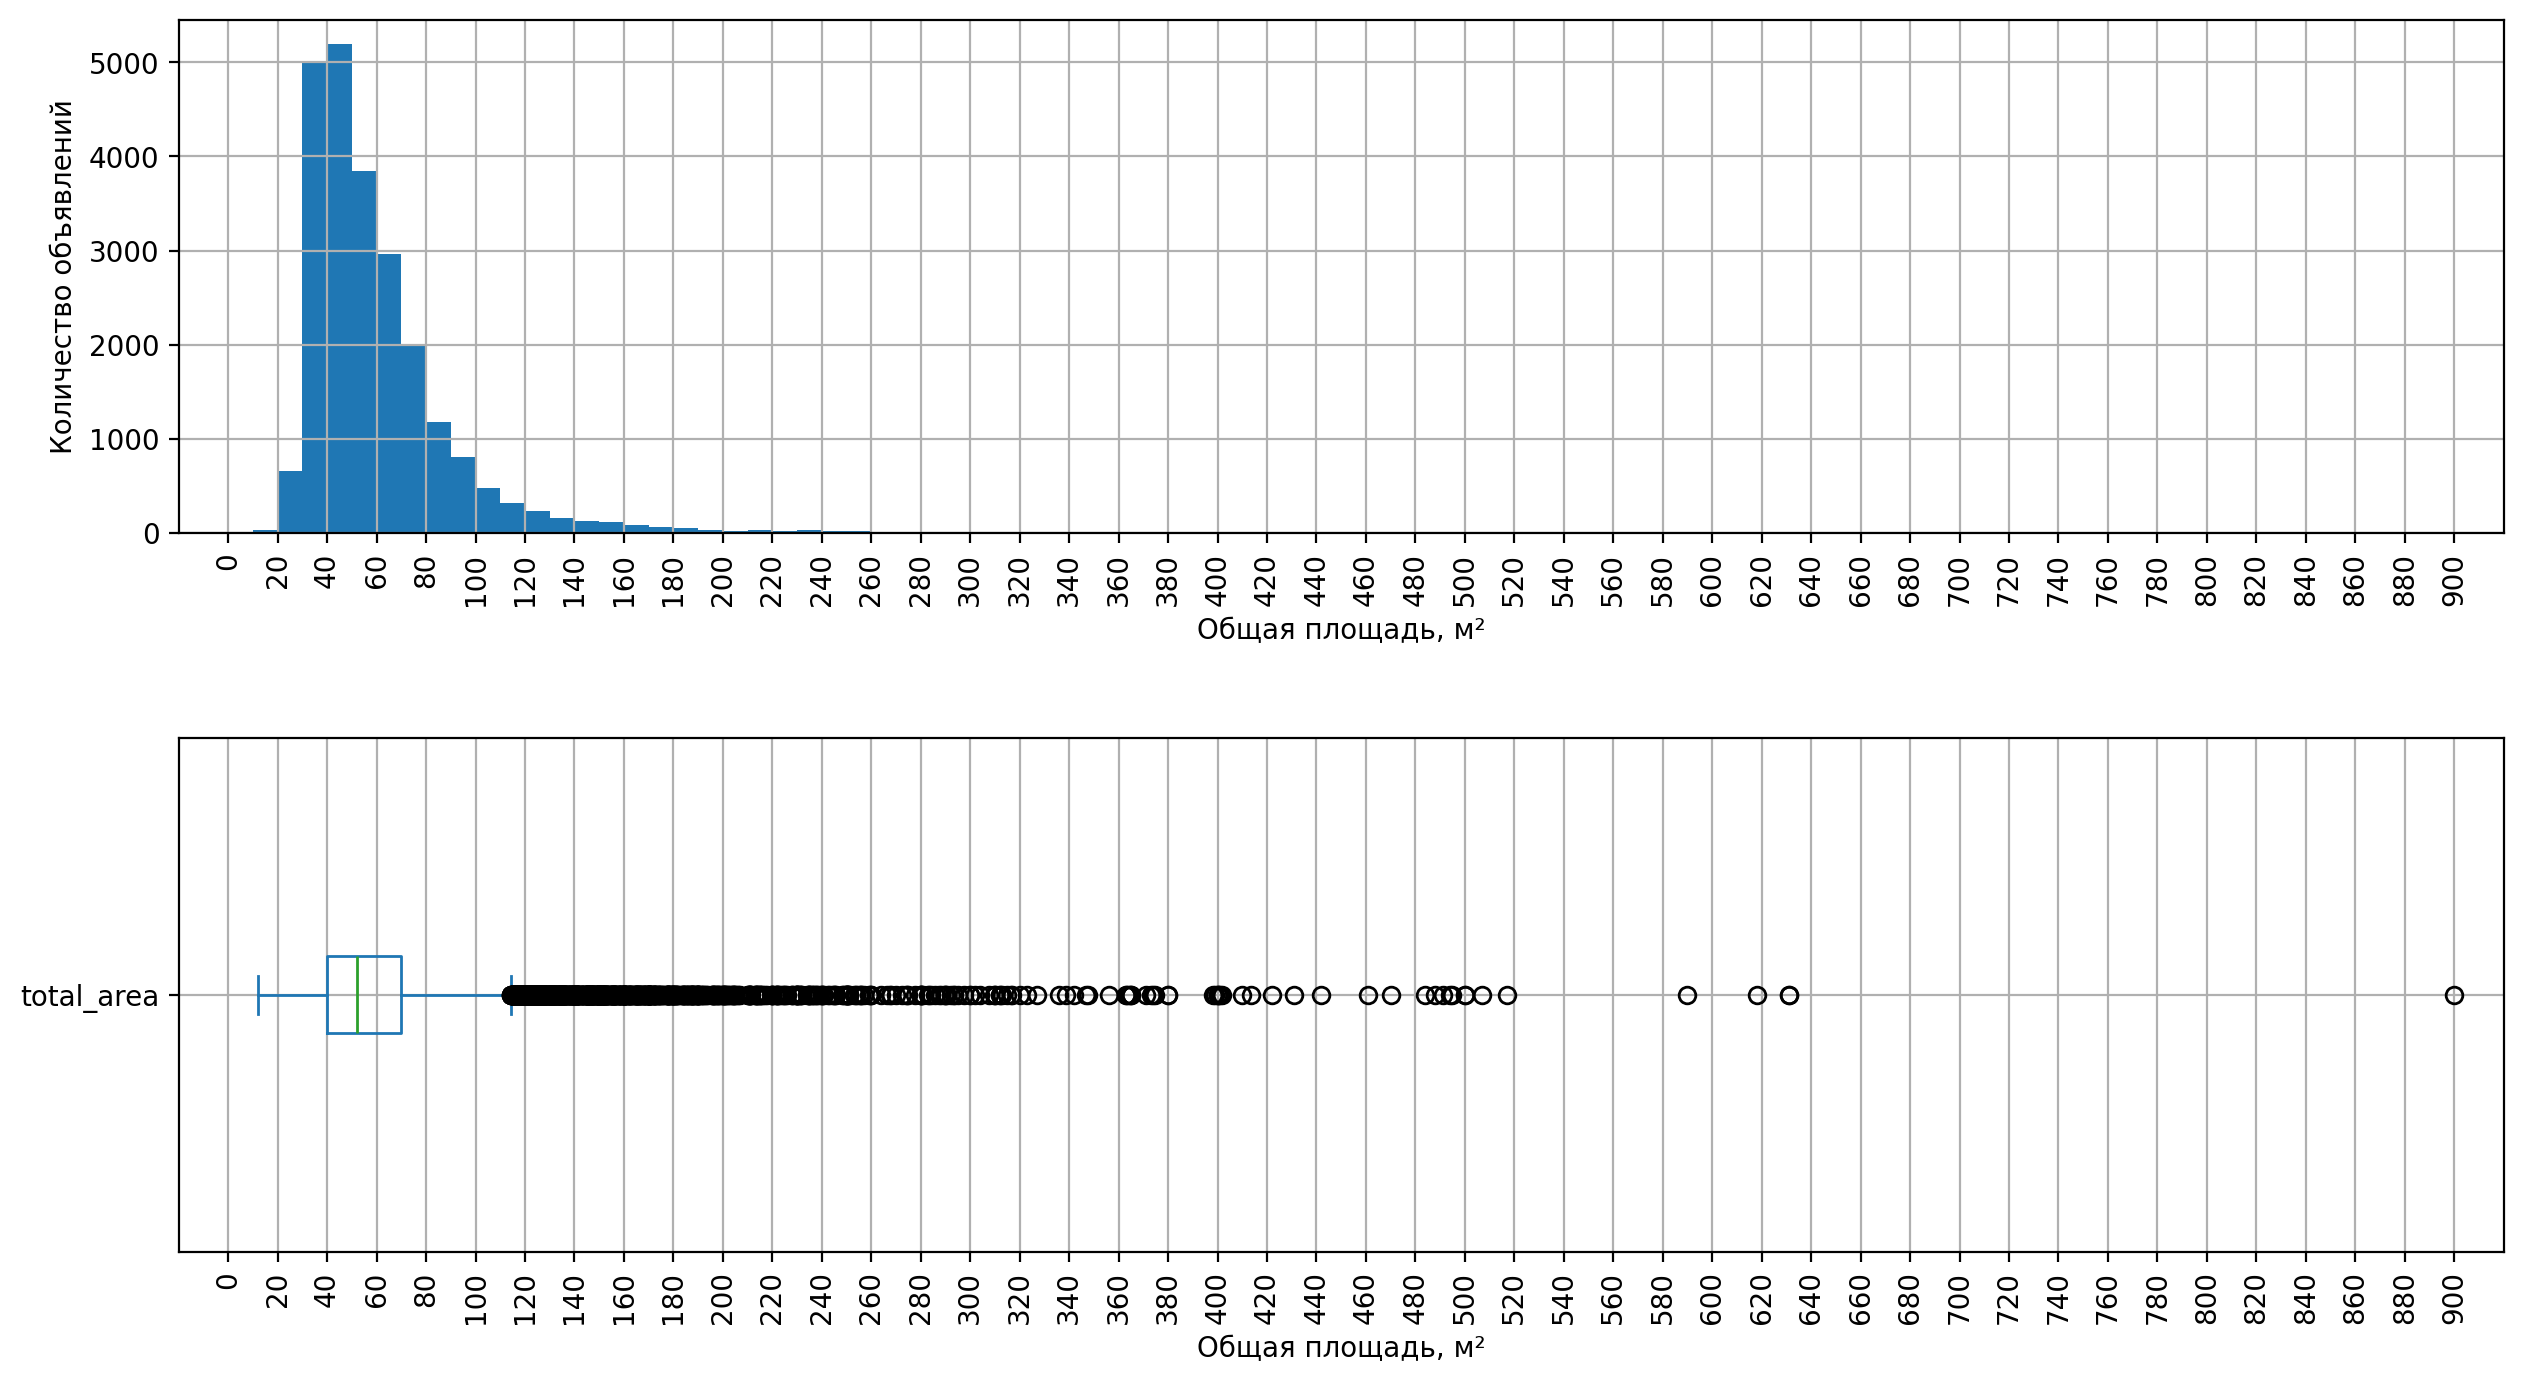

In [92]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['total_area'].plot(
    kind='hist', 
    bins=90, 
    grid=True, 
    range=(0, 900)
)
ax1.set_xlim([-20, 920])
ax1.set_xlabel('Общая площадь, м²') 
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(0, 920, 20), rotation=90)

plt.subplot(2, 1, 2)
ax2 = analyzed_data['total_area'].plot(
    kind='box', 
    vert=False, 
    grid=True,
    xlabel='Общая площадь, м²'
)
ax2.set_xlim([-20, 920])
ax2.set_xlabel('Общая площадь, м²')
plt.xticks(range(0, 920, 20), rotation=90)

pass

В выборке есть квартиры от 12 м² — это вполне допустимо для апартаментов, ведь формально они не являются жилой недвижимостью, там можно делать что угодно, а можно и не делать (кухню, например). **Основная масса квартир находится в пределах от 30 до 70 м².**

#### Жилая площадь

Посмотрим на числовое описание данных в столбце с жилой площадью квартиры `living_area`.

In [96]:
analyzed_data['living_area'].describe()

count    23565.000000
mean        34.621104
std         22.399830
min          2.000000
25%         19.000000
50%         30.000000
75%         42.120000
max        409.700000
Name: living_area, dtype: float64

Посмотрим на гистограмму и диаграмму размаха жилой площади.

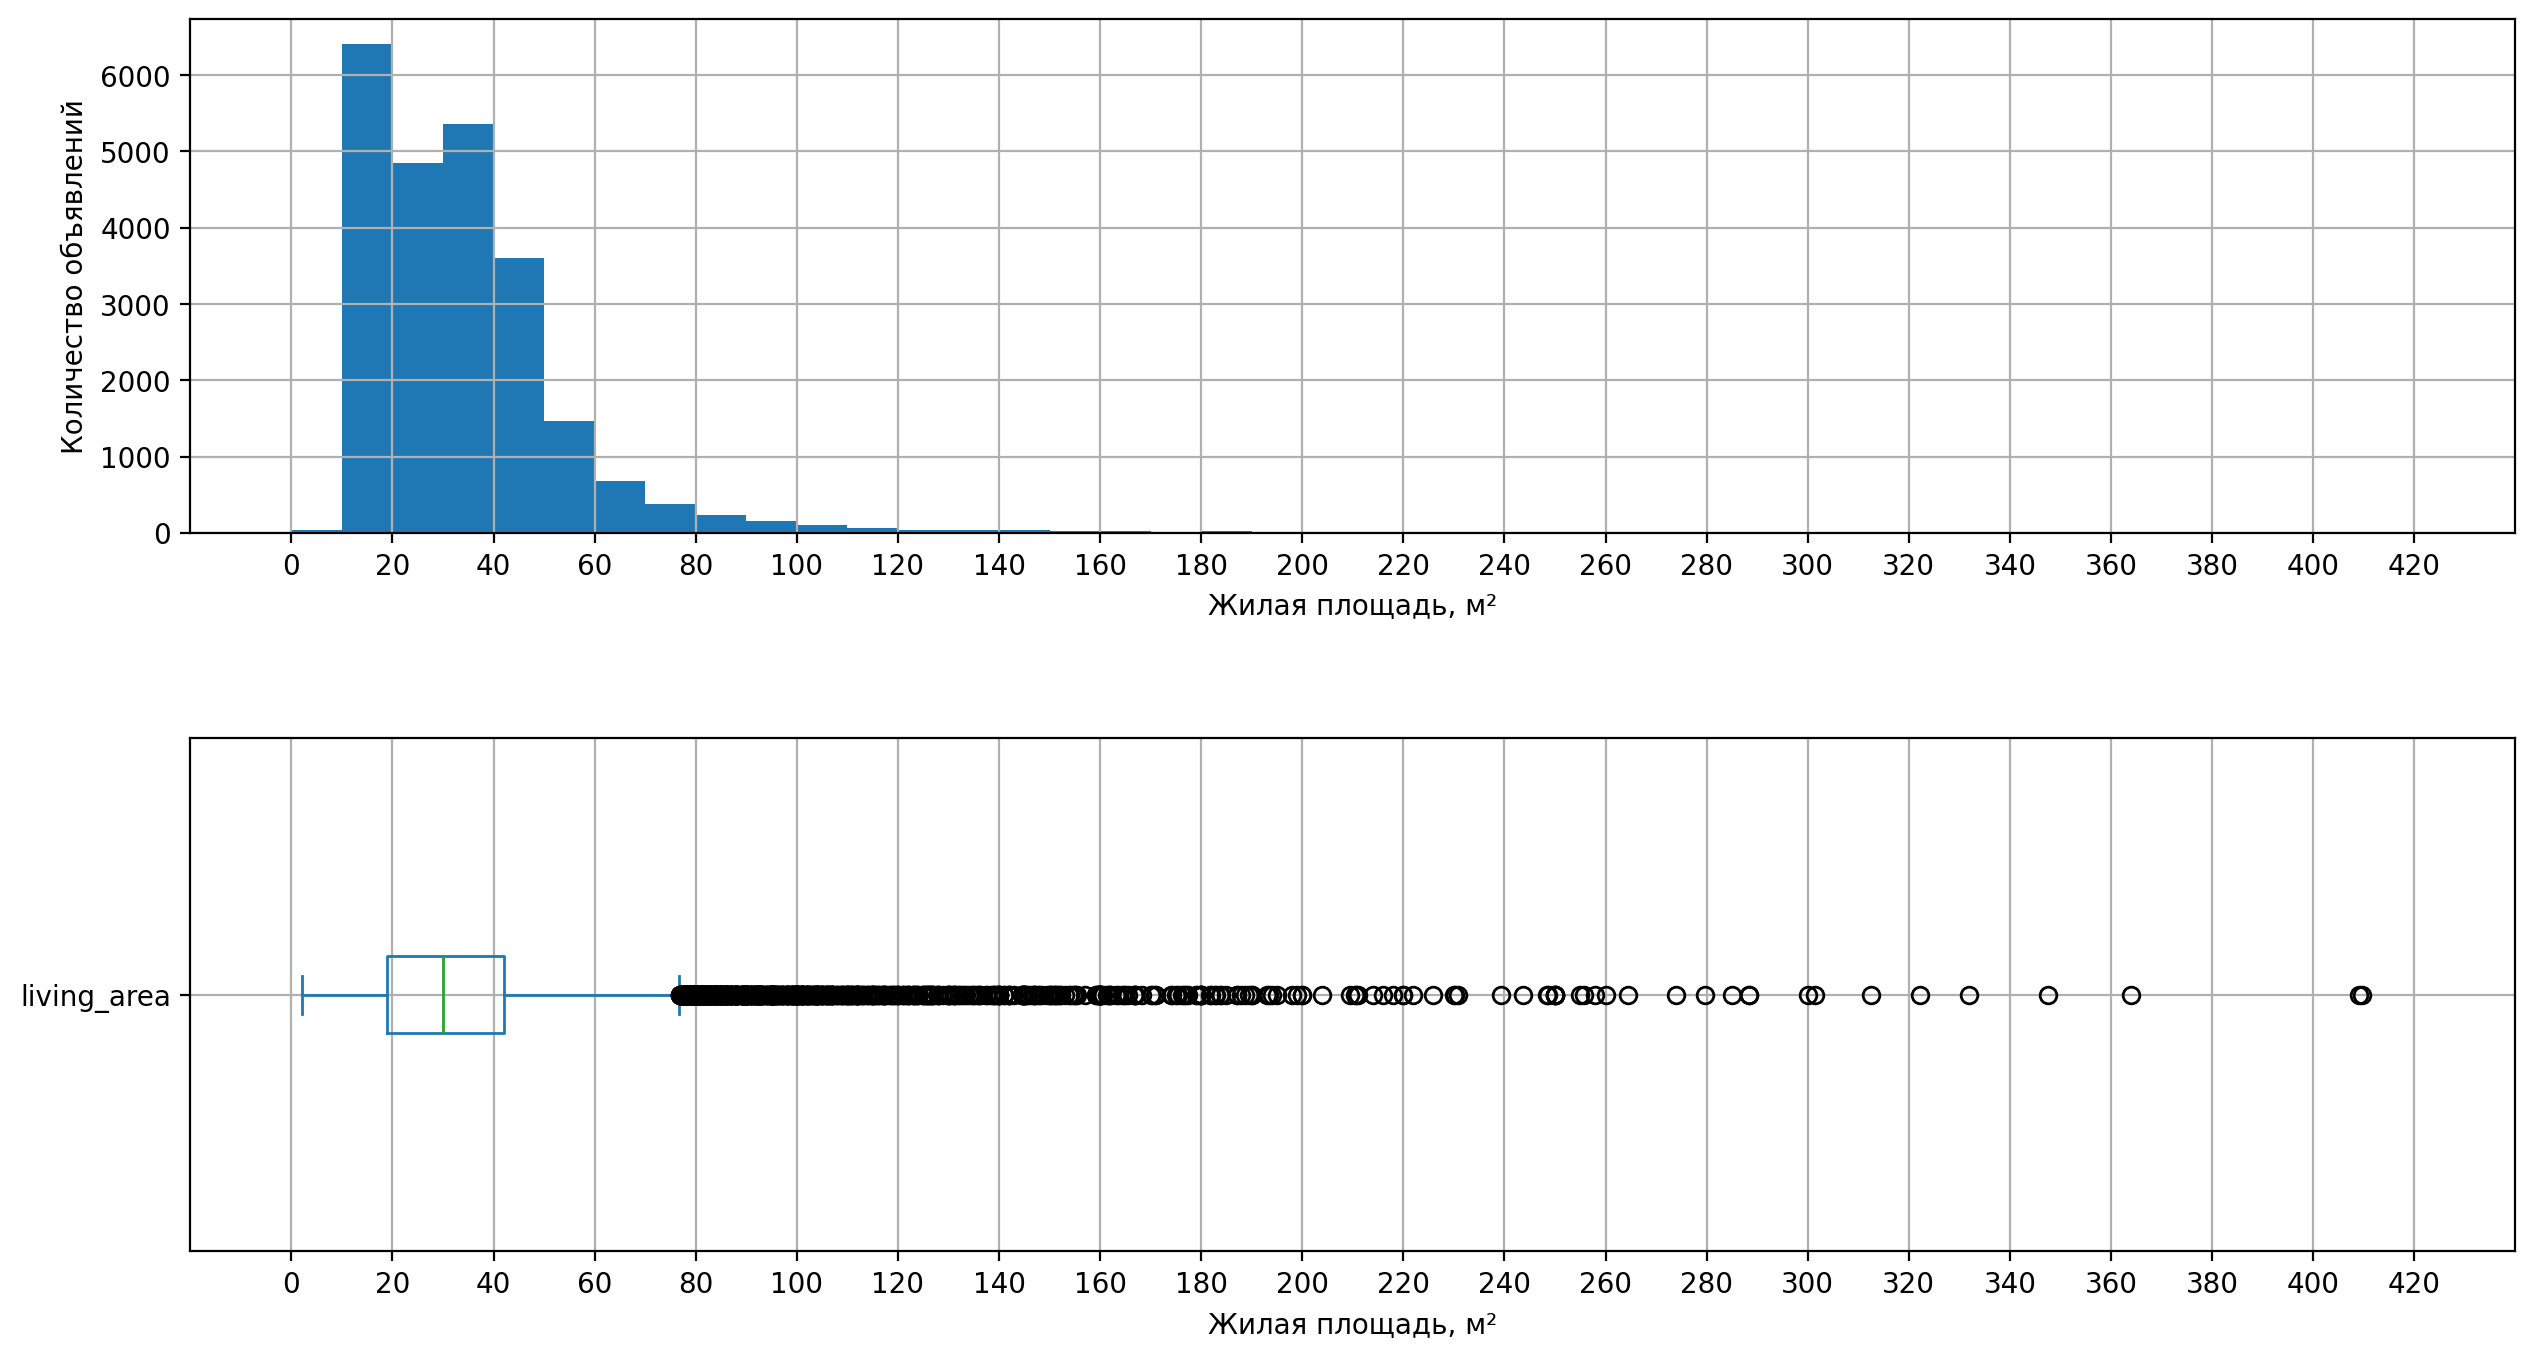

In [98]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['living_area'].plot(
    kind='hist', 
    bins=42, 
    grid=True, 
    range=(0, 420)
)
ax1.set_xlim([-20, 440])
ax1.set_xlabel('Жилая площадь, м²')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(0, 440, 20))

plt.subplot(2, 1, 2)
ax2 = analyzed_data['living_area'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlim([-20, 440])
ax2.set_xlabel('Жилая площадь, м²')
plt.xticks(range(0, 440, 20))

pass

Немного увеличим гистограмму для её детального изучения.

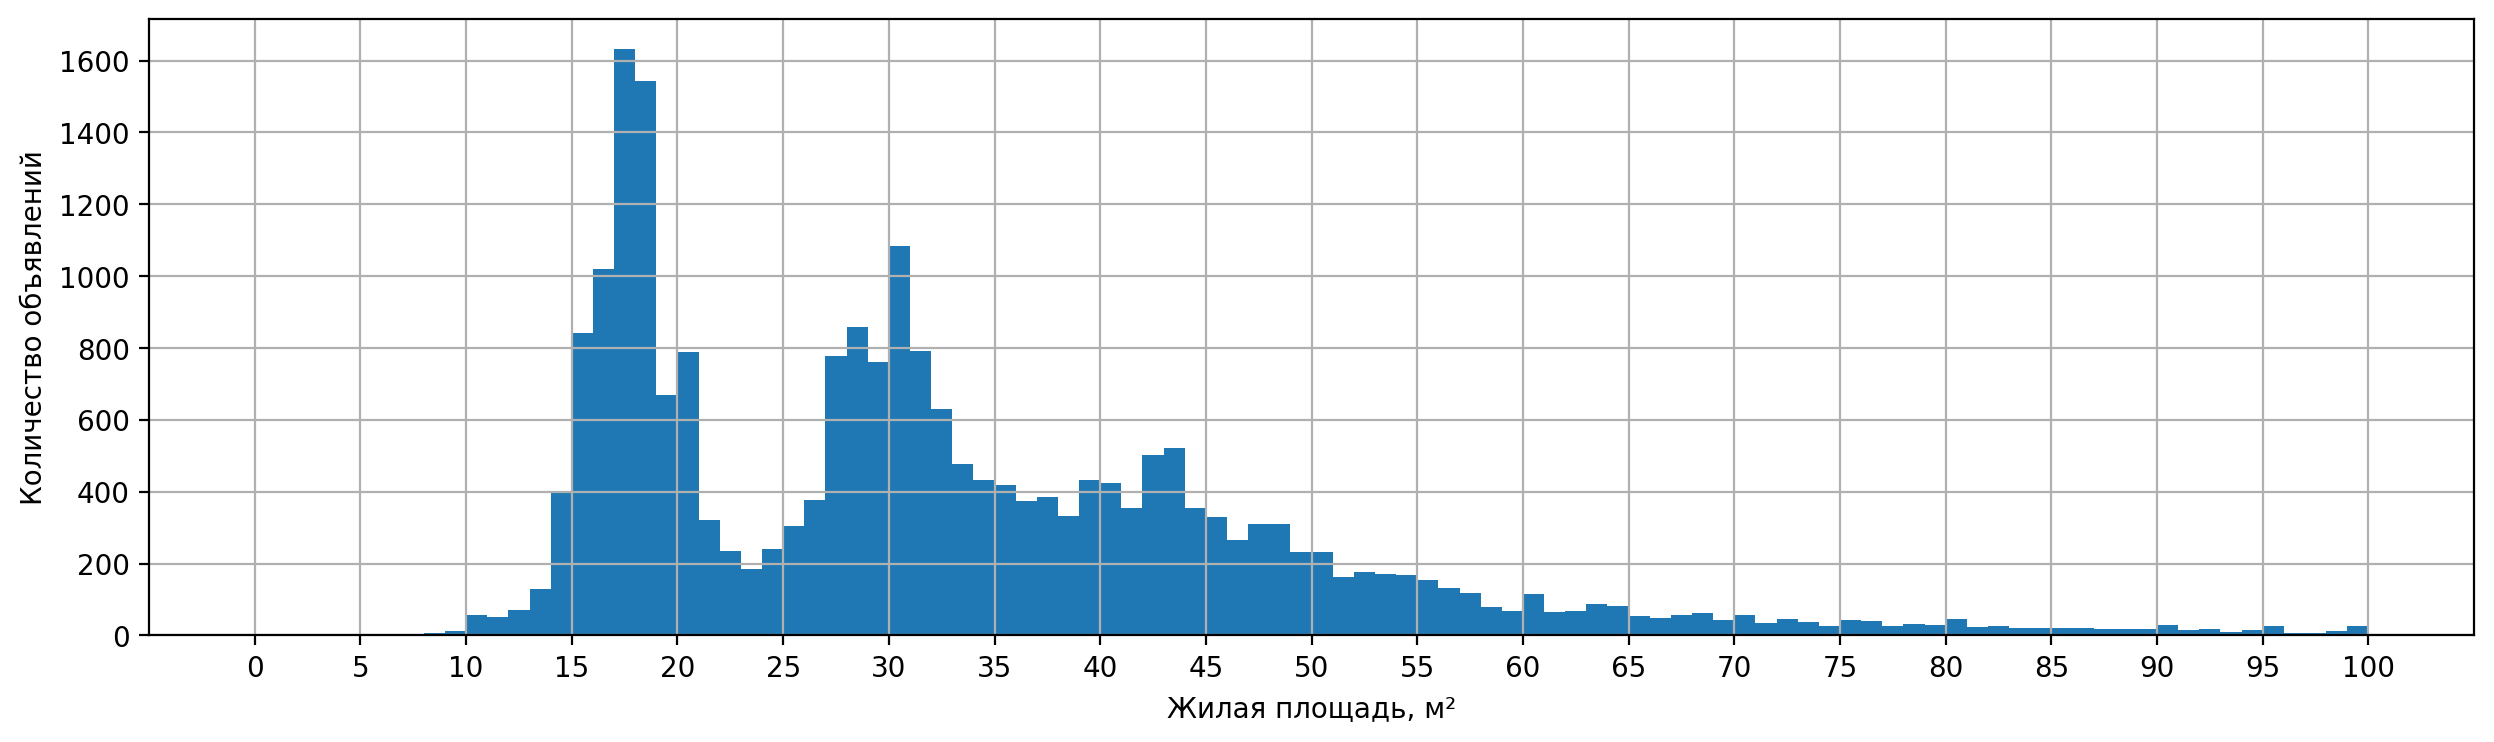

In [100]:
ax = (
    analyzed_data
    .query('living_area <= 100')['living_area']
    .plot(
        kind='hist', 
        bins=100, 
        grid=True, 
        range=(0, 100), 
        figsize=(15, 4)
    )
)
ax.set_xlabel('Жилая площадь, м²')
ax.set_ylabel('Количество объявлений')
plt.xticks(range(0, 105, 5))

pass

На гистограмме хорошо прослеживаются три пика на 17-18 м², на 30 м² и на 43-44 м², что примерно равняется площади одной, двух и трёх жилых комнат среднего рамера соответственно.

In [102]:
# средняя площадь комнаты
analyzed_data['living_area'].mean() / analyzed_data['rooms'].mean()

16.719875397069373

#### Площадь кухни

Посмотрим на числовое описание данных в столбце с площадью кухни `kitchen_area`.

In [105]:
analyzed_data['kitchen_area'].describe()

count    23565.000000
mean        10.473107
std          6.062783
min          0.000000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [106]:
(
    # количество квартир с очень малькой кухней
    len(analyzed_data.query('kitchen_area < 6 and is_apartment == False')),
    # количество апартаментов с очень малькой кухней
    len(analyzed_data.query('kitchen_area < 6 and is_apartment == True'))
)

(223, 2070)

Очень маленькие кухни свойственны в основном апартаментам (апартаментам также свойственно их отсутствие). Посмотрим на гистограмму и диаграмму размаха площади кухни.

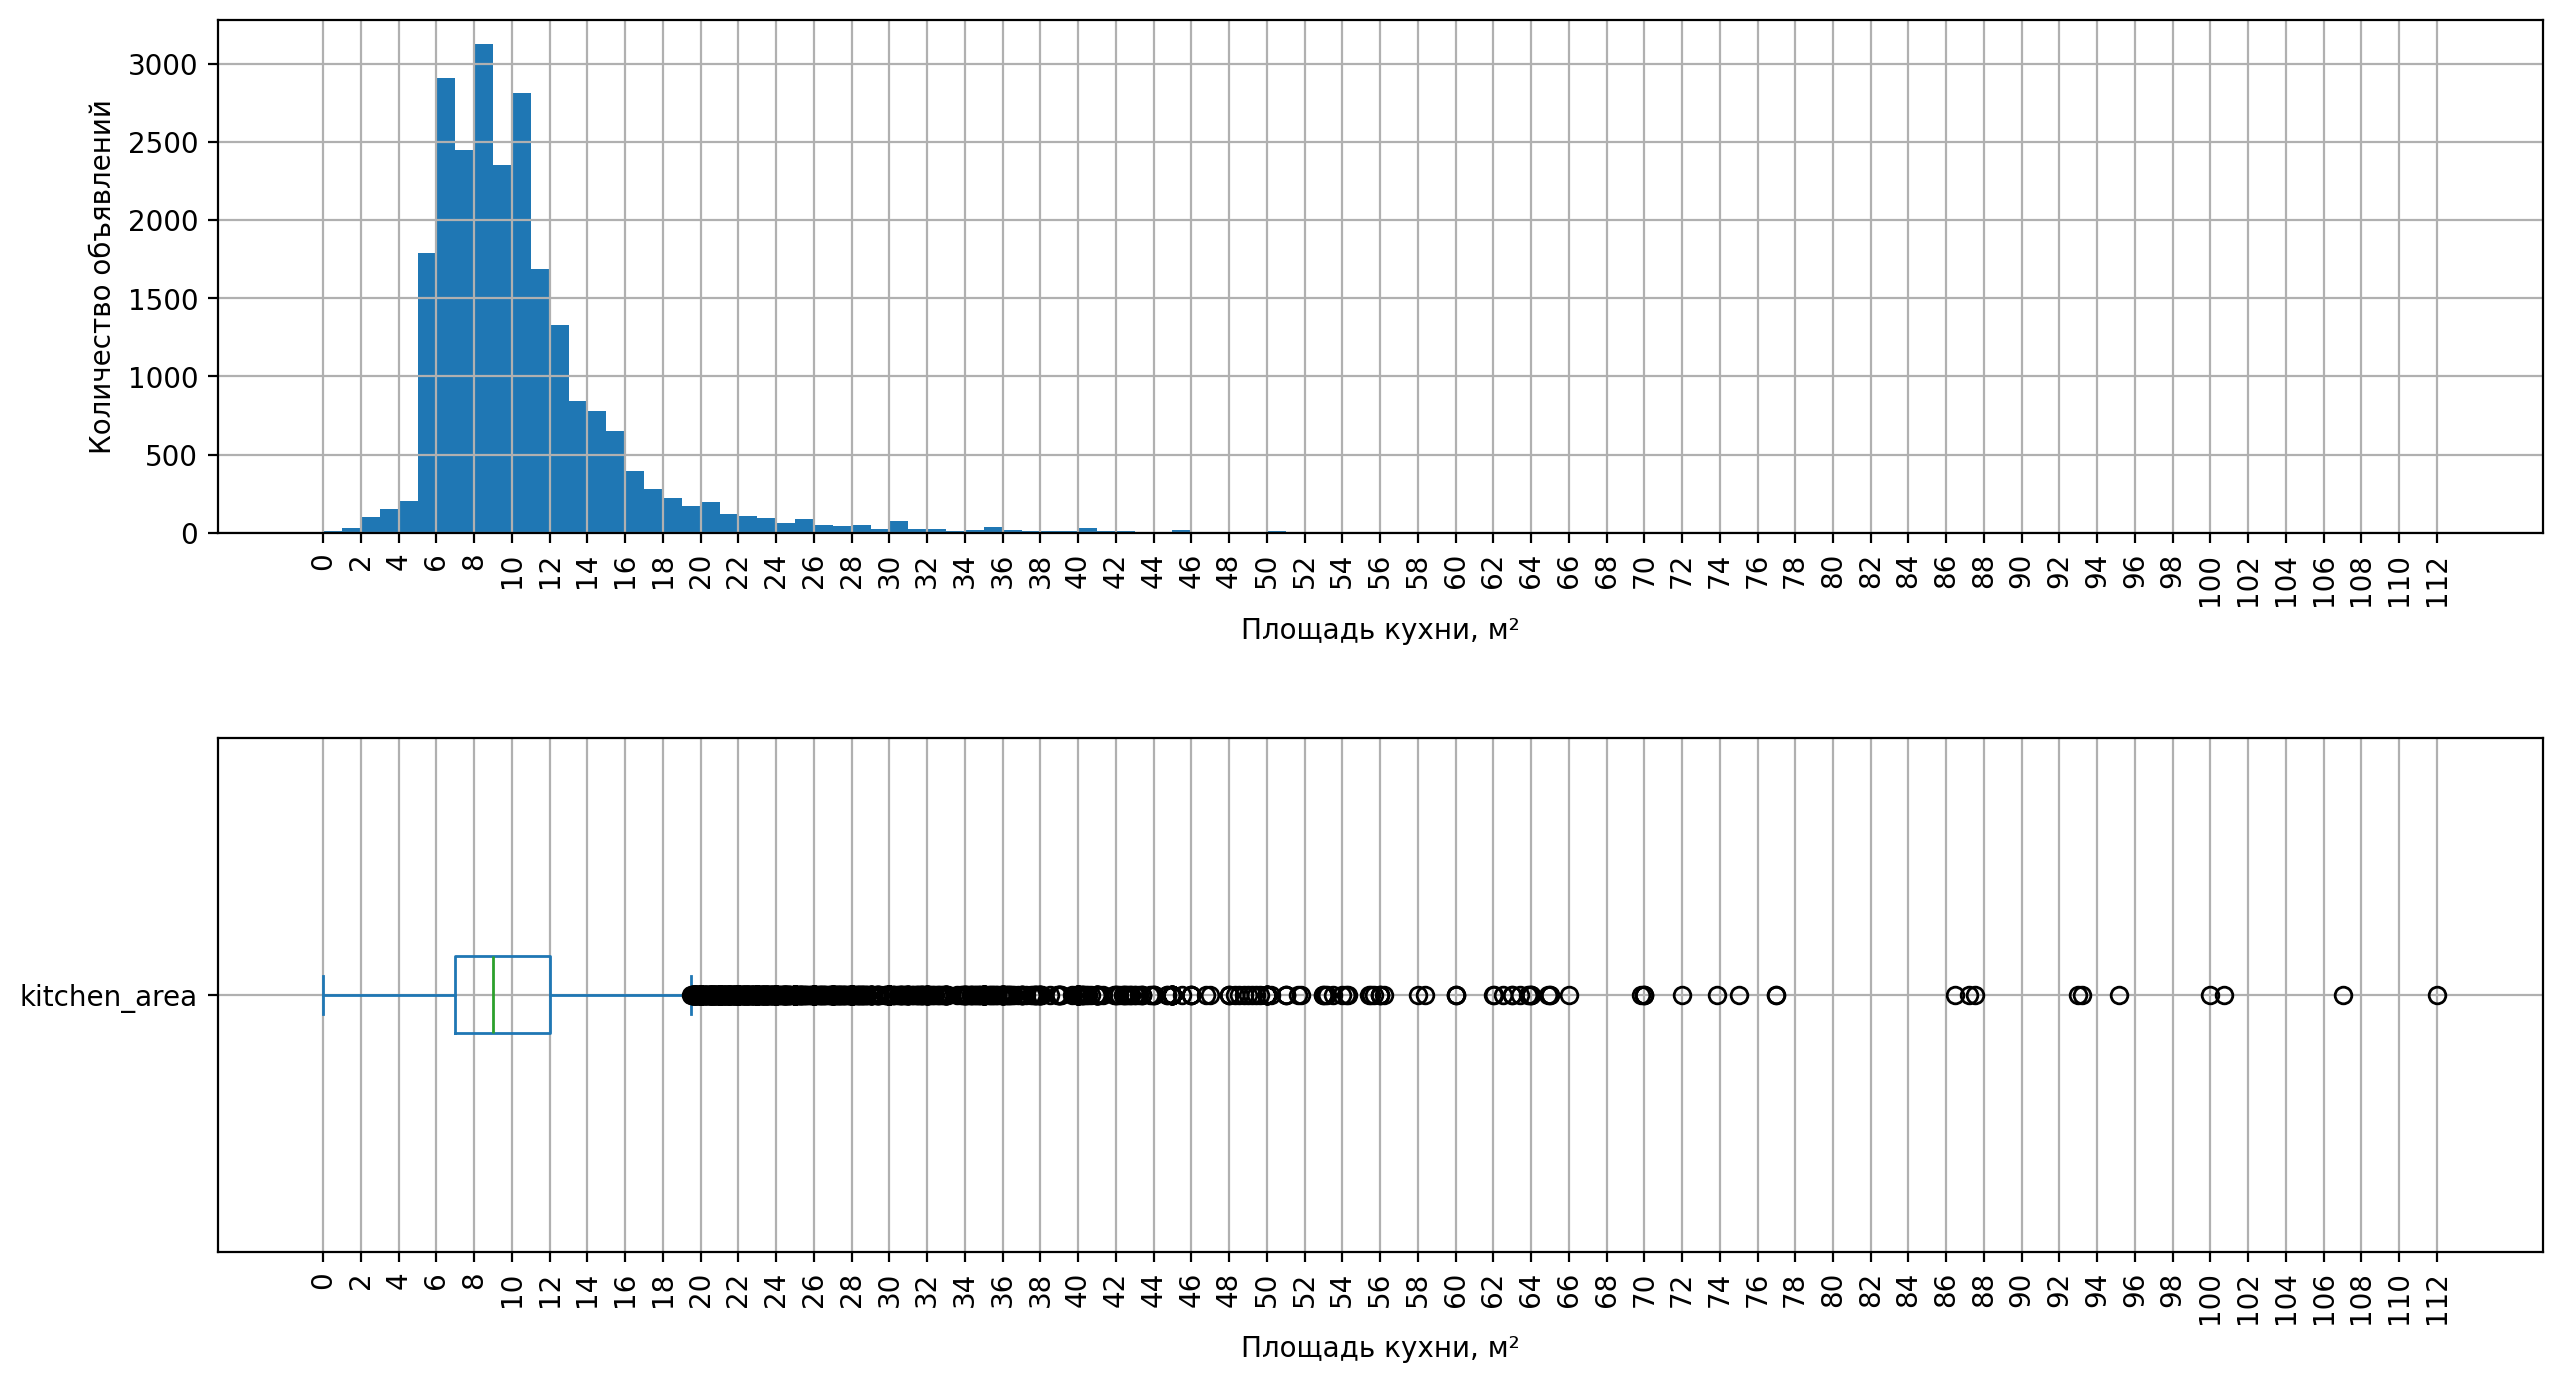

In [108]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['kitchen_area'].plot(
    kind='hist', 
    bins=112, 
    grid=True, 
    range=(0, 112)
)
ax1.set_xlabel('Площадь кухни, м²')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(0, 114, 2), rotation=90)

plt.subplot(2, 1, 2)
ax2 = analyzed_data['kitchen_area'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Площадь кухни, м²')
plt.xticks(range(0, 114, 2), rotation=90)

pass

На гистограмме прослеживаются несколько пиков в районе **6, 8 и 10 м² — похоже на кухни в квартирах с типовыми планировками** (6 м² в хрущевках, 8-10 м² в домах серии П-44, например).

#### Цена объекта и цена за квадратный метр

Посмотрим на числовое описание данных в столбце с общей стоимостью объекта `last_price`.

In [112]:
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
display(analyzed_data['last_price'].describe())
pd.reset_option('display.float_format')

count       23565.00
mean      6540058.26
std      10910934.72
min         12190.00
25%       3400000.00
50%       4646000.00
75%       6790000.00
max     763000000.00
Name: last_price, dtype: float64

Распределение данных в столбце с ценой объекта в отрыве от площади помещения не даст нам полного представления об аномалиях. Для выявления редких и выбивающихся значений обратимся к столбцу с ценой за м² `last_price_m2`.

In [114]:
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
display(analyzed_data['last_price_m2'].describe())
pd.reset_option('display.float_format')

count     23565.00
mean      99405.84
std       50389.43
min         111.83
25%       76566.13
50%       95000.00
75%      114213.20
max     1907500.00
Name: last_price_m2, dtype: float64

Посмотрим на объявления с самой низкой и самой высокой ценой за м².

In [116]:
(
    analyzed_data
    .sort_values(by='last_price_m2')[[
        'total_area', 
        'locality_name', 
        'city_center_distance_km', 
        'last_price', 
        'last_price_m2'
    ]]
    .head()
)

total_area                              locality_name  \
8793        109.0                            Санкт-Петербург   
14911        54.0  поселок при железнодорожной станции Свирь   
4405         52.0                                     Сланцы   
11351        54.0                                     Сланцы   
9581         43.4                         деревня Старополье   

       city_center_distance_km  last_price  last_price_m2  
8793                       9.0       12190         111.83  
14911                      NaN      430000        7962.96  
4405                       NaN      500000        9615.38  
11351                      NaN      550000       10185.19  
9581                       NaN      450000       10368.66

In [117]:
(
    analyzed_data
    .sort_values(by='last_price_m2')[[
        'total_area', 
        'locality_name', 
        'city_center_distance_km', 
        'last_price', 
        'last_price_m2'
    ]]
    .tail()
)

total_area    locality_name  city_center_distance_km  last_price  \
4996        124.5  Санкт-Петербург                      2.0   124000000   
14706       401.0  Санкт-Петербург                      2.0   401300000   
22831       187.5  Санкт-Петербург                      1.0   289238400   
1436        190.0  Санкт-Петербург                      1.0   330000000   
12971       400.0  Санкт-Петербург                      4.0   763000000   

       last_price_m2  
4996       995983.94  
14706     1000748.13  
22831     1542604.80  
1436      1736842.11  
12971     1907500.00

Вероятно при публикации объявлений продавцы могли ошибится при заполнении цены. В случае с самой низкой ценой за м² явно пропущены три ноля, в случае с самой высокой — лишний 0. Восстановим корректные значения.

In [119]:
analyzed_data['last_price'] = (
    analyzed_data['last_price'].where(
        analyzed_data['last_price_m2'] > 1000, 
        (analyzed_data['last_price'] * 1000).astype('int')
    )
)

analyzed_data['last_price'] = (
    analyzed_data['last_price'].where(
        analyzed_data['last_price_m2'] < 1000000, 
        (analyzed_data['last_price'] / 10).astype('int')
    )
)

analyzed_data['last_price_m2'] = (analyzed_data['last_price'] / analyzed_data['total_area']).round(2)

Посмотрим на гистограмму и диаграмму размаха цены за м².

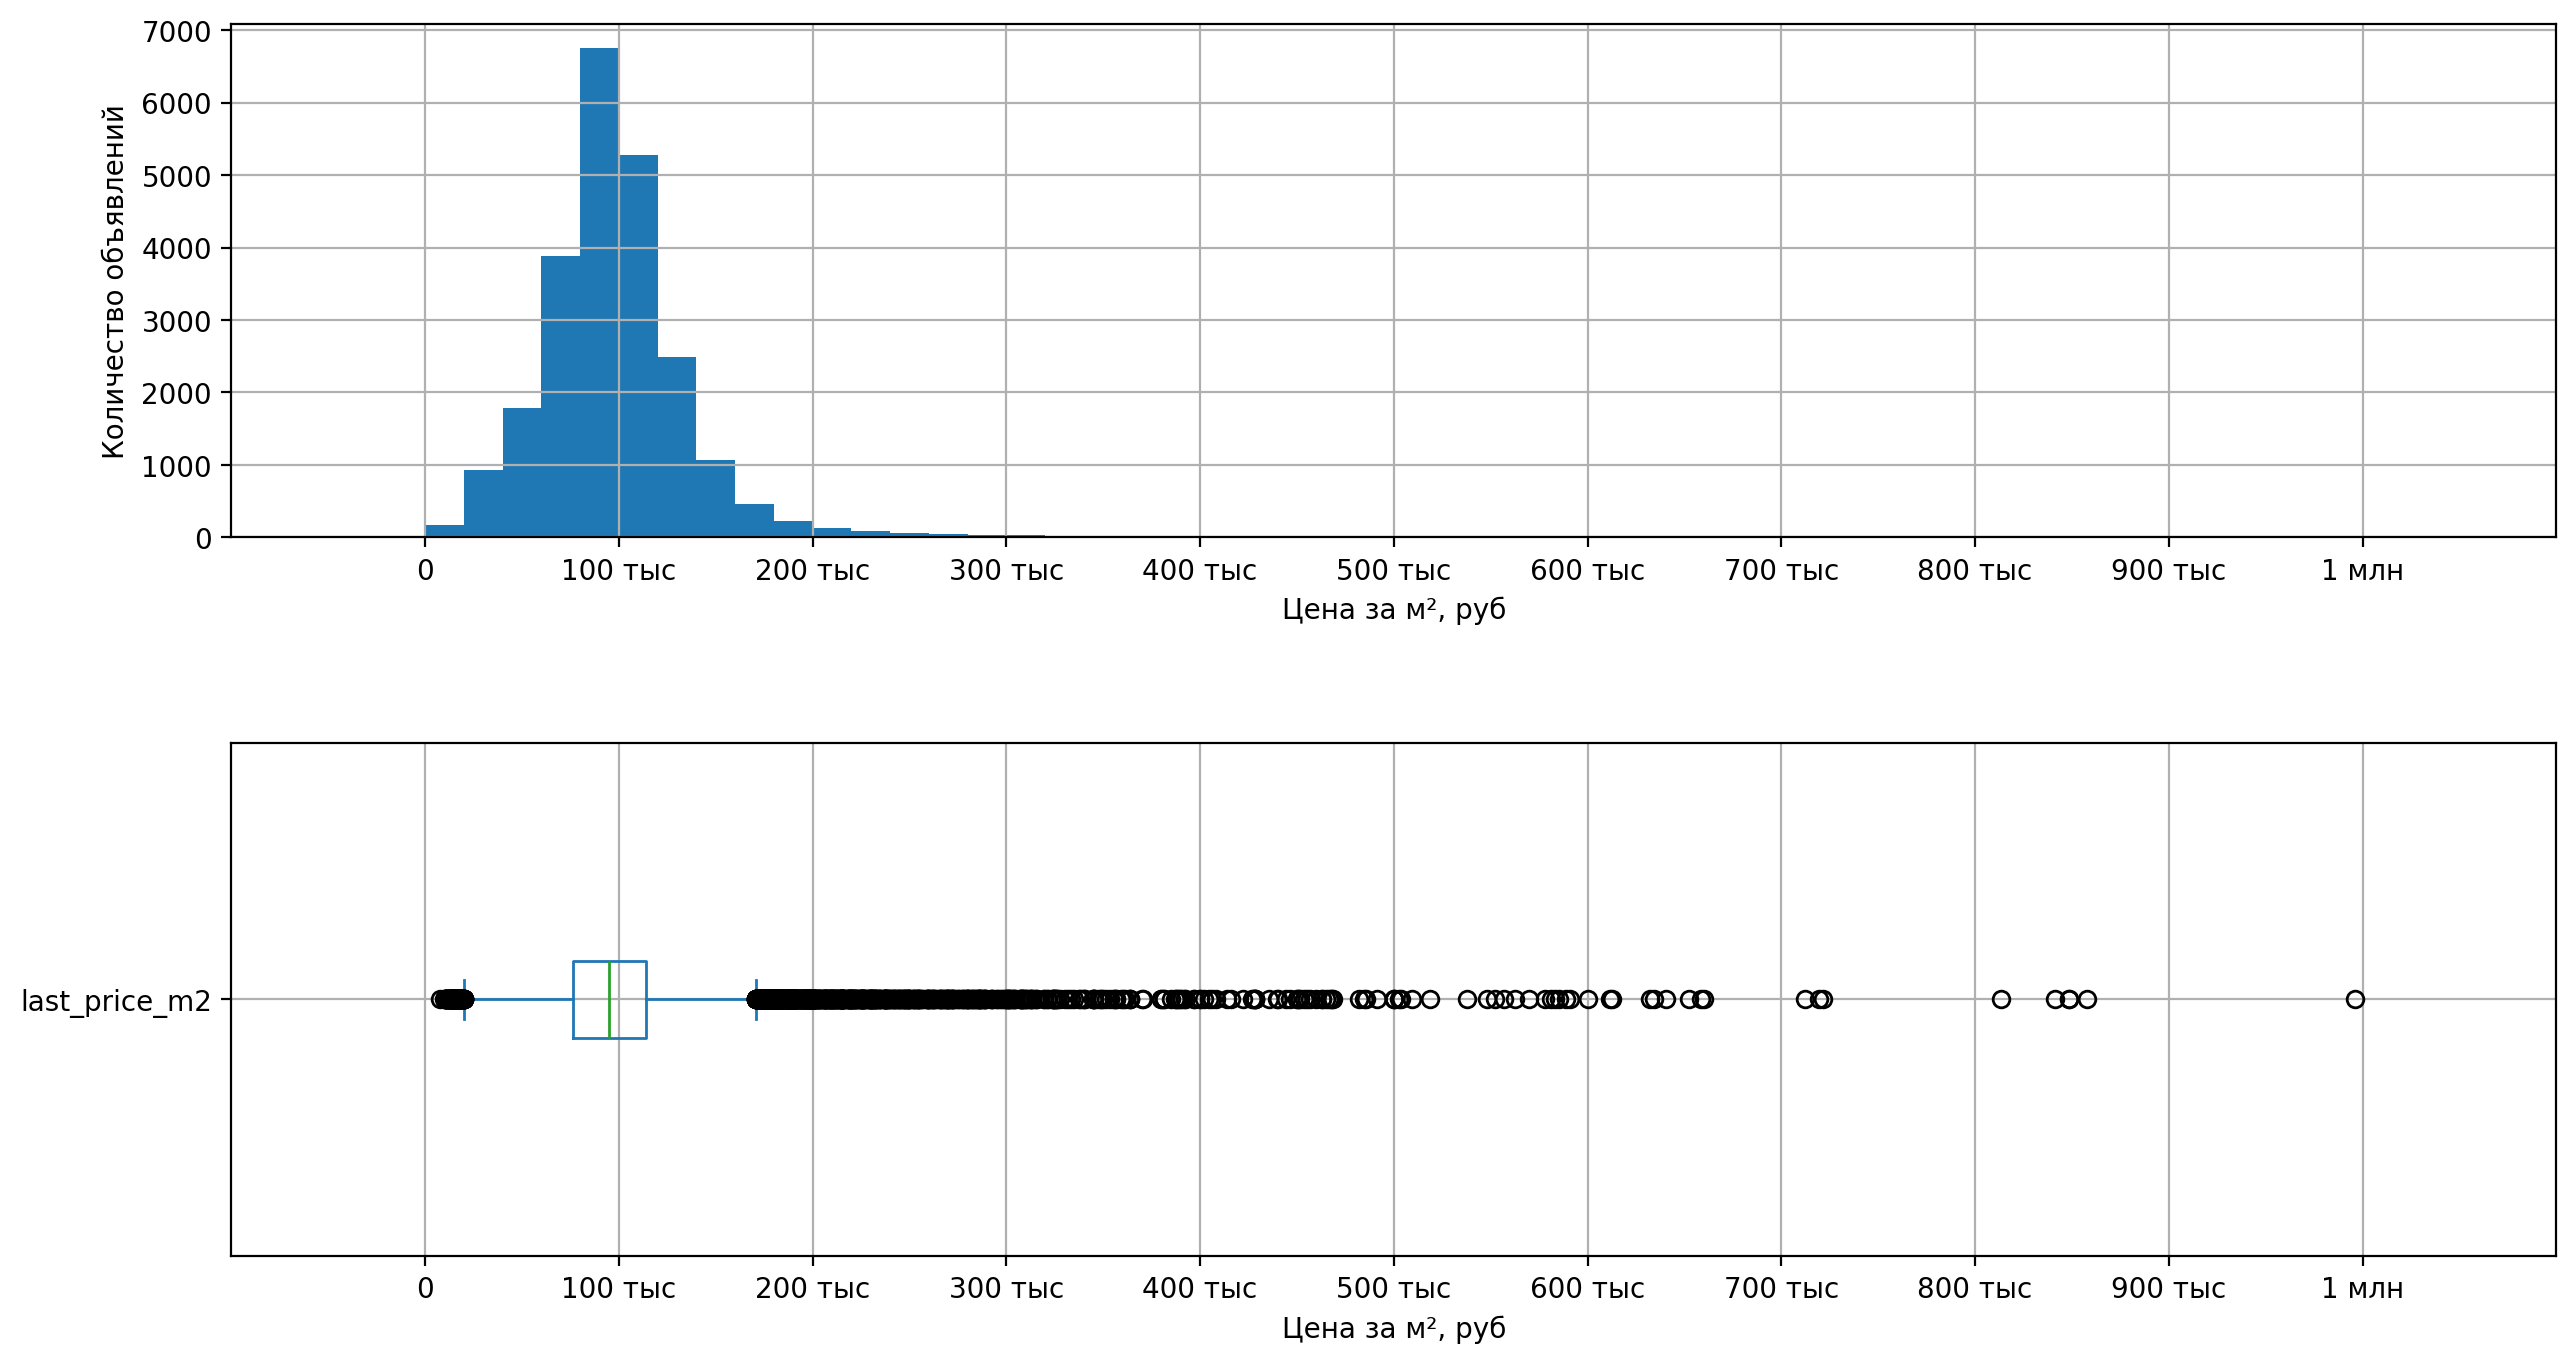

In [121]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['last_price_m2'].plot(
    kind='hist', 
    bins=50, 
    grid=True, 
    range=(0, 1000000)
)
ax1.set_xlabel('Цена за м², руб')
ax1.set_ylabel('Количество объявлений')
ax1.set_xlim([-100000, 1100000])
ax1.xaxis.set_major_formatter(FuncFormatter(pretty_price))
plt.xticks(range(0, 1100000, 100000))

plt.subplot(2, 1, 2)
ax2 = analyzed_data['last_price_m2'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Цена за м², руб')
ax2.set_xlim([-100000, 1100000])
ax2.xaxis.set_major_formatter(FuncFormatter(pretty_price))
plt.xticks(range(0, 1100000, 100000))

pass

**Медианная цена составляет 95000 за м². В большинстве объявлений цены колеблются от 76000 до 114000 за м².** Цены выше 300000 за м² мы можем отнести к выбросам в данных, хотя очевидно, что элитная недвижимость в центре Санкт-Петербурга стоит гораздо дороже недвижимости эконом-класса в Ленобласти.

#### Количество комнат

Посмотрим на числовое описание данных в столбце с количеством комнат `rooms`.

In [125]:
analyzed_data['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [126]:
# список уникальных значений в столбце с количеством комнат
", ".join([str(x) for x in sorted(analyzed_data['rooms'].unique())])

'0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19'

Среди значений столбца `rooms` с количеством комнат есть нулевые значения. Вероятно, продавцы могли пропустить это поле при заполнении объявлений (а затем система подачи объявлений заменила пропуск на `0`), либо же продавцы указали `0` для квартир-студий.

Заменим нулевые значения в количестве комнат на `1` для студий, а в остальных случаях — на медианные. Для этого разделим объявления на категории по общей площади с шагом в 10 м² (от 0 до 9 м², от 10 до 19 м² и так далее). Для каждой группы вычислим медианное количество комнат.

In [128]:
def total_area_group(total_area):
    return total_area // 10


# заменяем нулевые значения количества комнат на 1 для квартир-студий
analyzed_data['rooms'] = analyzed_data['rooms'].where(analyzed_data['is_studio'] == False, 1)

# категоризируем объявления по общей площади (по 10 квадратных метров) в новом столбце 
analyzed_data['total_area_group'] = analyzed_data['total_area'].apply(total_area_group).astype('int')
# рассчитываем медианные значения количества комнат в каждой категории
total_area_group_medians = analyzed_data.groupby(['total_area_group'])['rooms'].transform('median').astype('int')
# заменяем нулевые значения количества комнат на медианные
analyzed_data['rooms'] = analyzed_data['rooms'].where(analyzed_data['rooms'] != 0, total_area_group_medians)
# удаляем новый столбец
analyzed_data = analyzed_data.drop('total_area_group', axis=1)

Посмотрим на гистограмму и диаграмму размаха количества комнат.

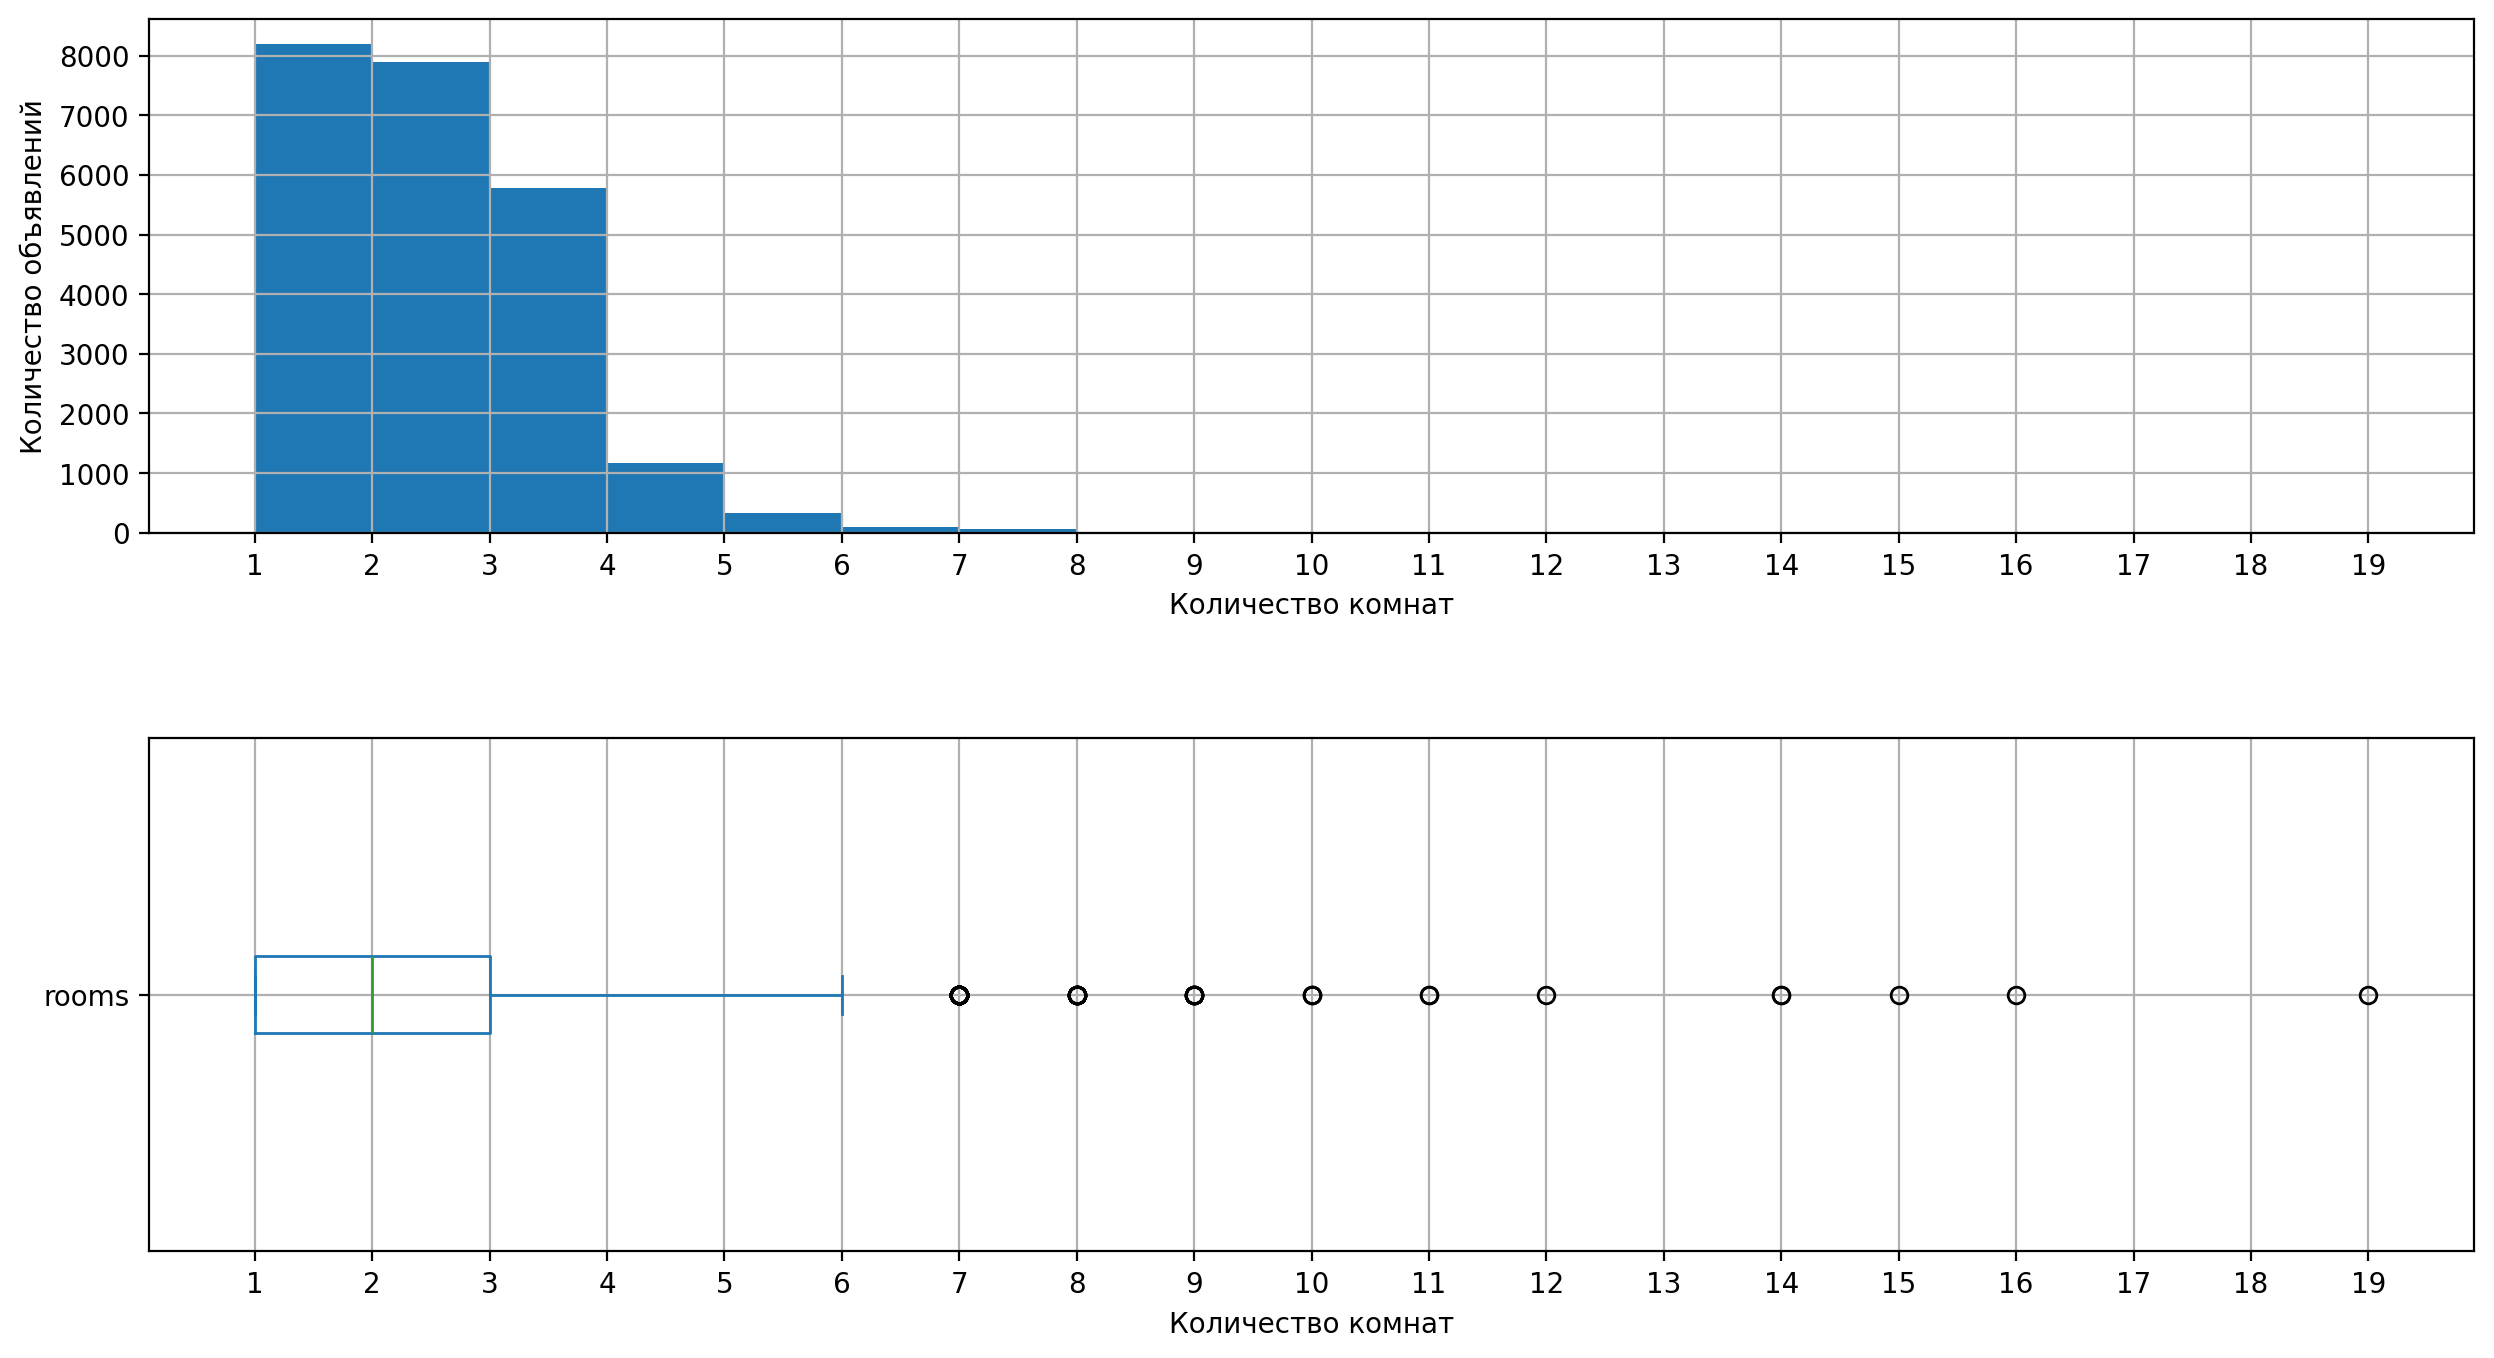

In [130]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['rooms'].plot(
    kind='hist', 
    bins=18, 
    grid=True
)
ax1.set_xlabel('Количество комнат')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(1, 20))

plt.subplot(2, 1, 2)
ax2 = analyzed_data['rooms'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Количество комнат')
plt.xticks(range(1, 20))

pass

На гистограмме один пик, аномалий не наблюдается. Получается, что **чаще всего размещают объявления о продаже одно- и двухкомнатных квартир. Чем больше комнат — тем меньше предложений**. Некоторым продавцам может быть обидно, но 7 и более комнат формально мы уже можем считать выбросами.

#### Высота потолков

Посмотрим на числовое описание данных в столбце с высотой потолков `ceiling_height`.

In [134]:
analyzed_data['ceiling_height'].describe()

count    23565.000000
mean         2.735737
std          0.996999
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

In [135]:
# список уникальных значений в столбце с высотой потолков
", ".join([str(x) for x in sorted(analyzed_data['ceiling_height'].unique())])

'1.0, 1.2, 1.75, 2.0, 2.2, 2.25, 2.3, 2.34, 2.4, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6, 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.75, 3.76, 3.78, 3.8, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9, 3.93, 3.95, 3.98, 4.0, 4.06, 4.1, 4.14, 4.15, 4.19, 4.2, 4.25, 4.3, 4.37, 4.4, 4.45, 4.5, 4.65, 4.7, 4.8, 4.9, 5.0, 5.2, 5.3, 5.5, 5.6, 5.8, 6.0, 8.0, 8.3, 10.3, 

Среди значений столбца `ceiling_height` с высотой потолков есть очевидно некорректные значения. В некоторых случаях продавцы вероятно хотели указать значения типа «2.75», но поставили по ошибке точку не в том месте — получилось «27.5». Обработаем такие значения.

In [137]:
analyzed_data['ceiling_height'] = (
    analyzed_data['ceiling_height'].where(
        analyzed_data['ceiling_height'] <= 10, 
        (analyzed_data['ceiling_height'] / 10).round(2)
    )
)

Поскольку на Яндекс.Недвижимости нет категории объявлений «помещения для хоббитов», высота потолков меньше 2 метров (мансардные этажи низкие, но вряд ли ниже 2 метров) кажется странной. Удалим такие записи.

In [139]:
analyzed_data = analyzed_data.query('ceiling_height >= 2')

Посмотрим на гистограмму и диаграмму размаха высоты потолков.

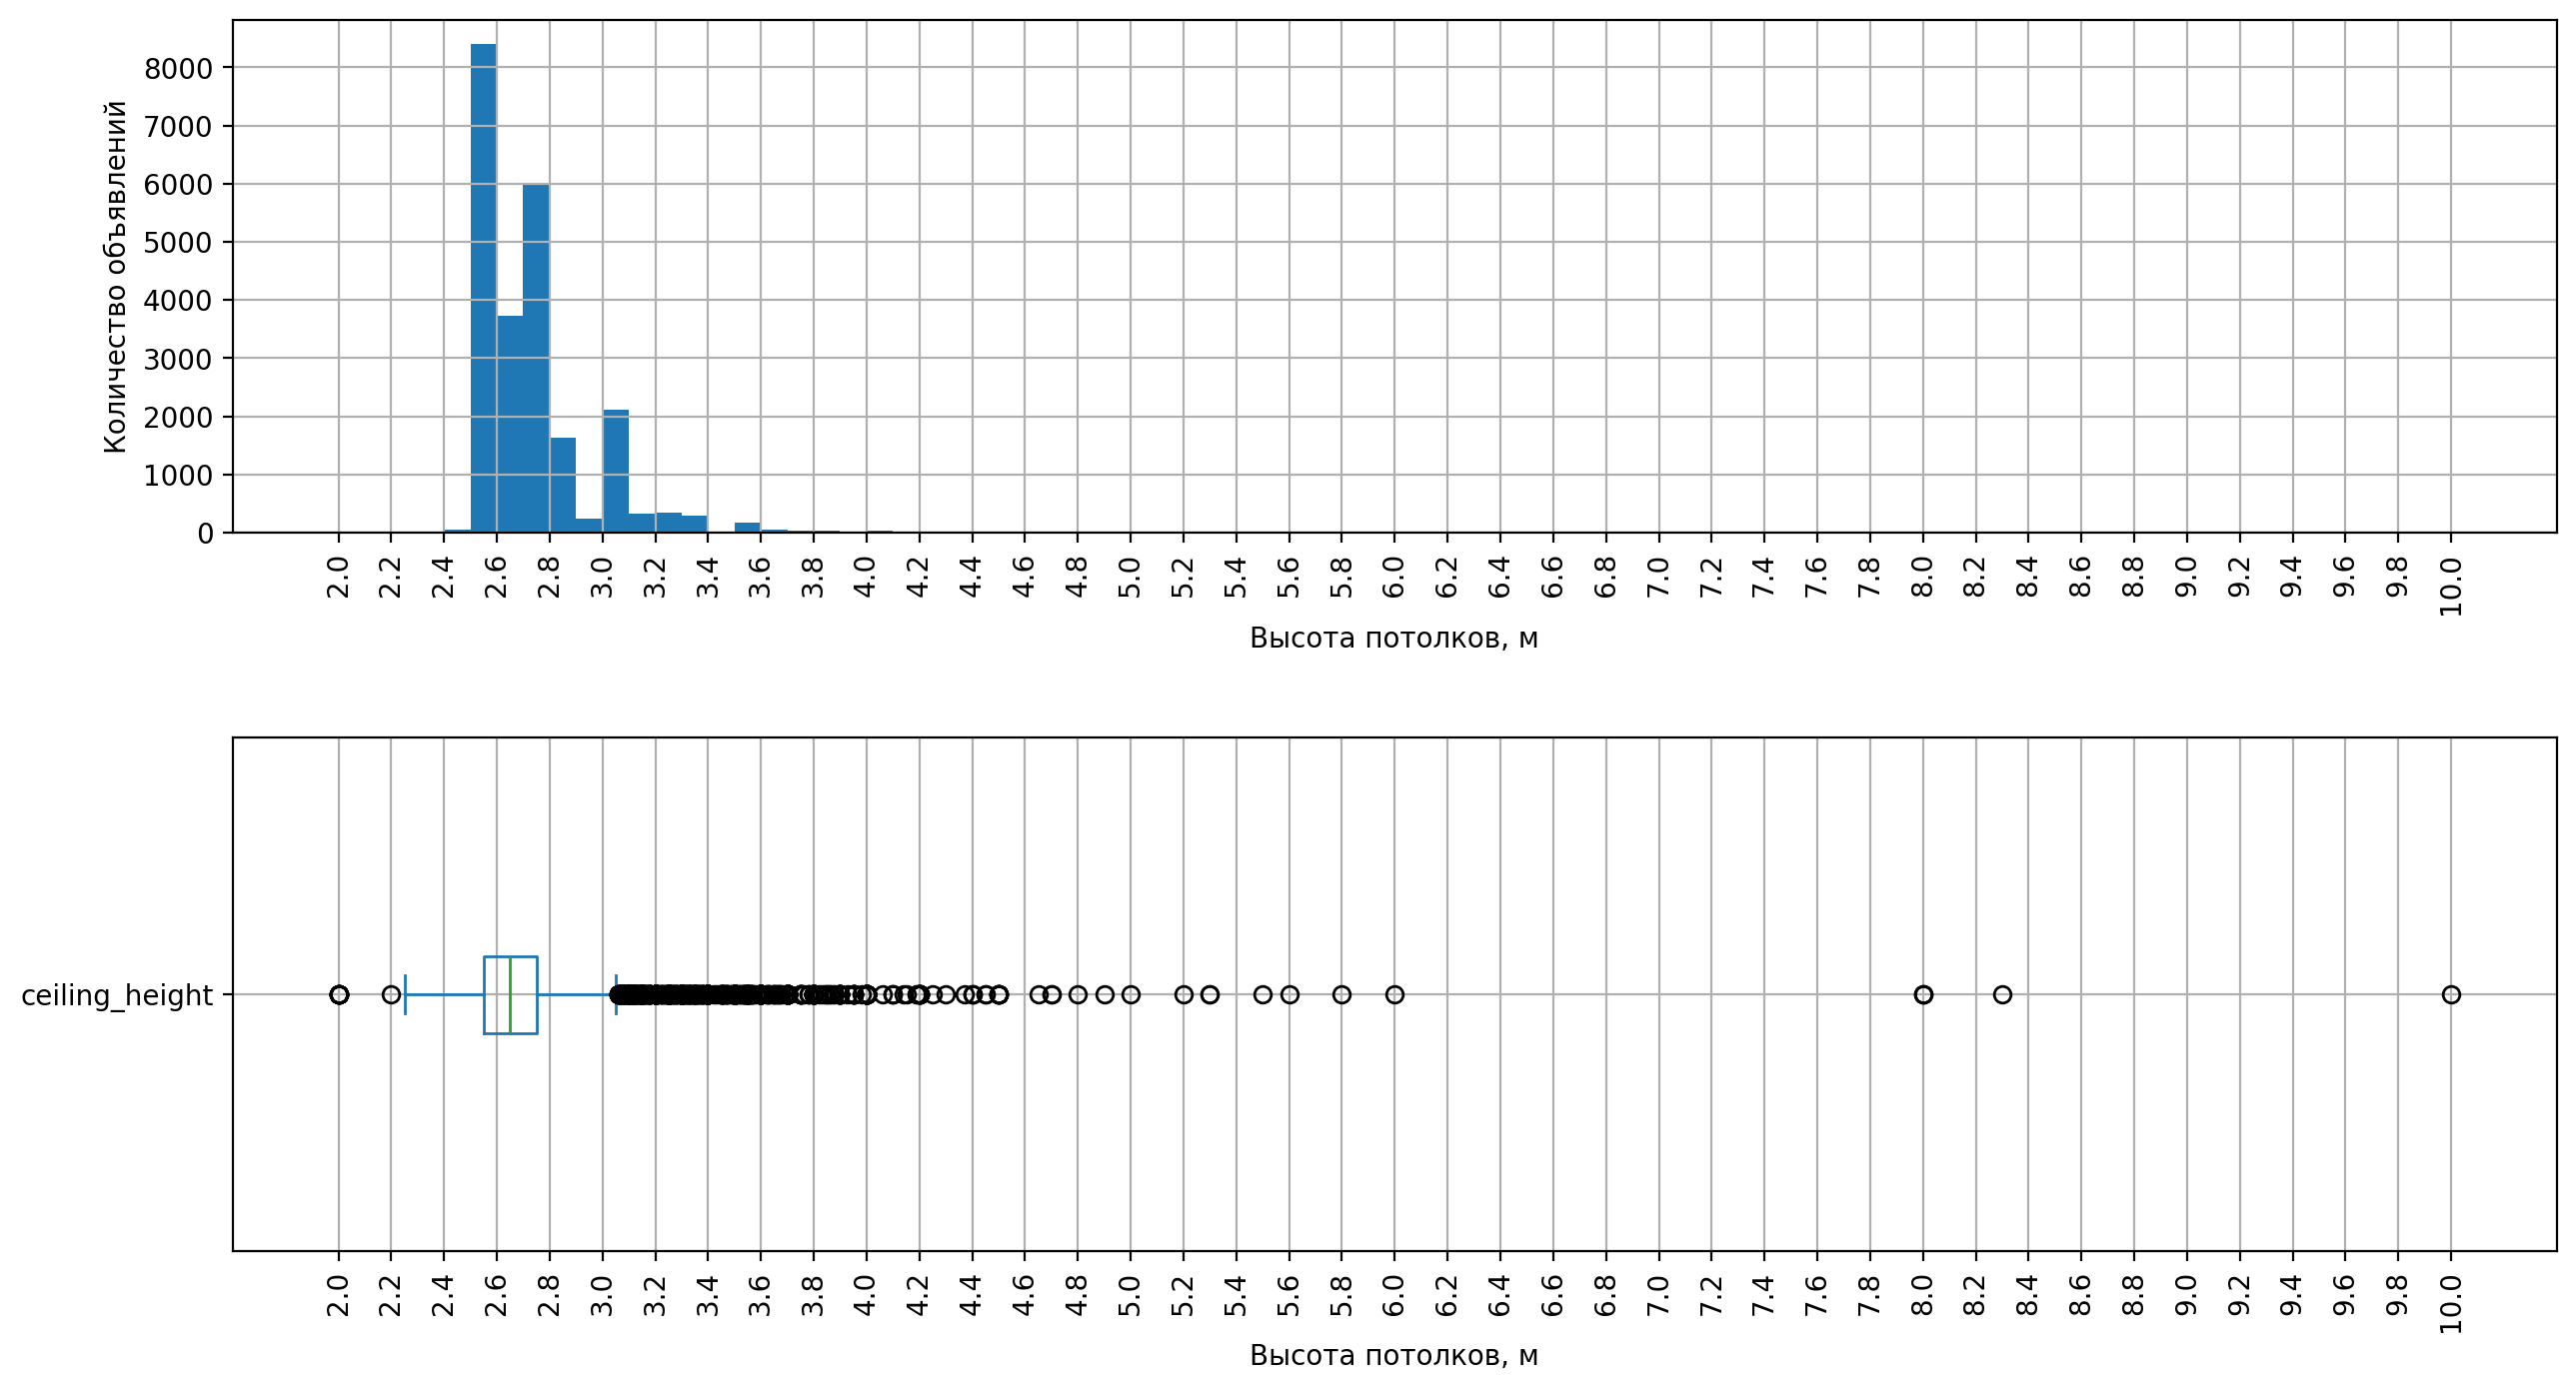

In [141]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)
step_width = 5

plt.subplot(2, 1, 1)
ax1 = analyzed_data['ceiling_height'].plot(
    kind='hist', 
    bins=80, 
    grid=True
)
ax1.set_xlabel('Высота потолков, м')
ax1.set_ylabel('Количество объявлений')
plt.xticks([x / step_width for x in range(2 * step_width, 10 * step_width + 1)], rotation=90)

plt.subplot(2, 1, 2)
ax2 = analyzed_data['ceiling_height'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Высота потолков, м')
plt.xticks([x / step_width for x in range(2 * step_width, 10 * step_width + 1)], rotation=90)

pass

На гистограмме видим сразу несколько пиков — 2.5, 2.7 и 3 метра. **Такие высоты потолков свойственны хрущевкам, современным новостройкам и сталинским домам с высокими потоками соответсвенно. Самая распространенная высота потолков в выборке — 2.5 метра.** Доля объявлений с очень высокими потолками (выше 4 метров) невелика.

#### Общее количество этажей в доме

Посмотрим на числовое описание данных в столбце этажностью дома `floors`.

In [145]:
analyzed_data['floors'].describe()

count    23559.000000
mean        10.673628
std          6.590993
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors, dtype: float64

Интересный факт: самое высокое жилое здание в Санкт-Петербурге — это ЖК «Князь Александр Невский» на проспекте Обуховской обороны высотой в 35 надземных этажей (есть еще 2 подземных).

Если учесть этот интересный факт, то этажи выше 35-го кажутся явно аномальными. Уберем их из данных.

In [147]:
analyzed_data = analyzed_data.query('floors <= 35')

Посмотрим на гистограмму и диаграмму размаха количества этажей в доме.

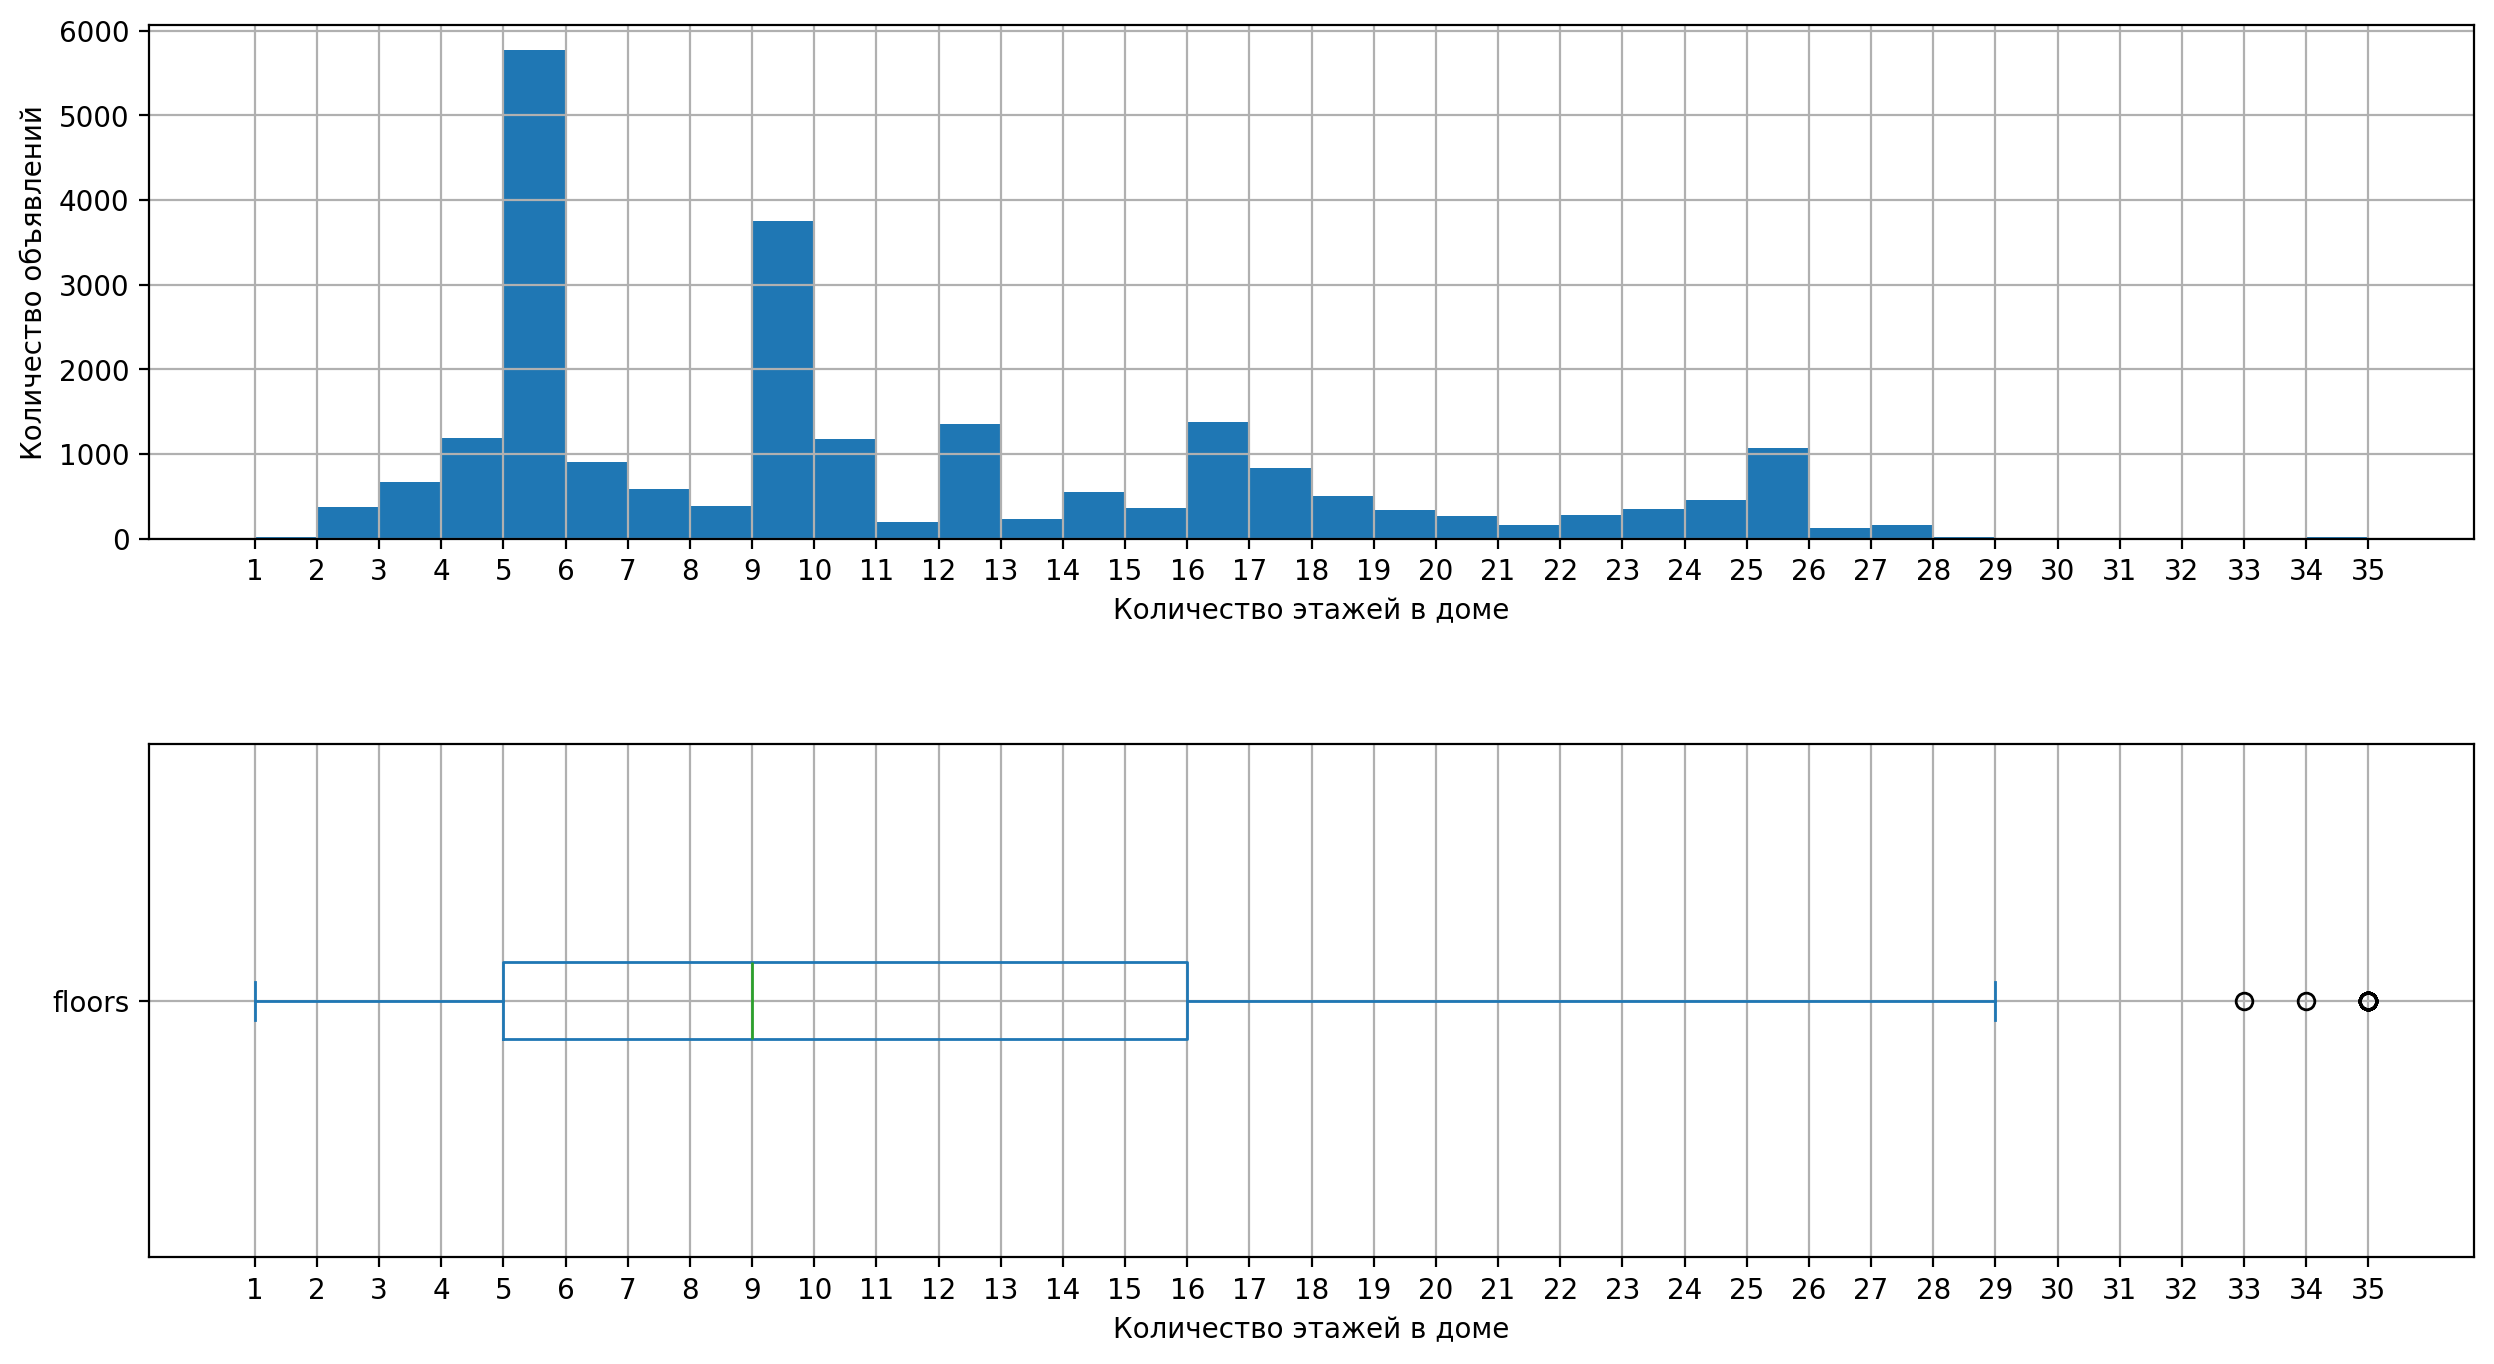

In [149]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['floors'].plot(
    kind='hist', 
    bins=34, 
    grid=True
)
ax1.set_xlabel('Количество этажей в доме')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(1, 36))

plt.subplot(2, 1, 2)
ax2 = analyzed_data['floors'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Количество этажей в доме')
plt.xticks(range(1, 36))

pass

На гистограмме видим сразу несколько пиков — 5, 9, 12, 16 и 25 этажей, что в целом характерно для типовых домов. **Больше всего квартир продается в пяти- и девятиэтажных домах.** Вероятно, продавцы хотят переехать из старых хрущевок и типовых панельных девятиэтажек в более комфортные квартиры в современных домах.

#### Тип этажа квартиры

Посмотрим на количество объявлений в каждой группе — на первых, последних и «других» (не первых и не последних) этажах.

In [153]:
analyzed_data['floor_type'].value_counts()

floor_type
другой       17317
последний     3330
первый        2908
Name: count, dtype: int64

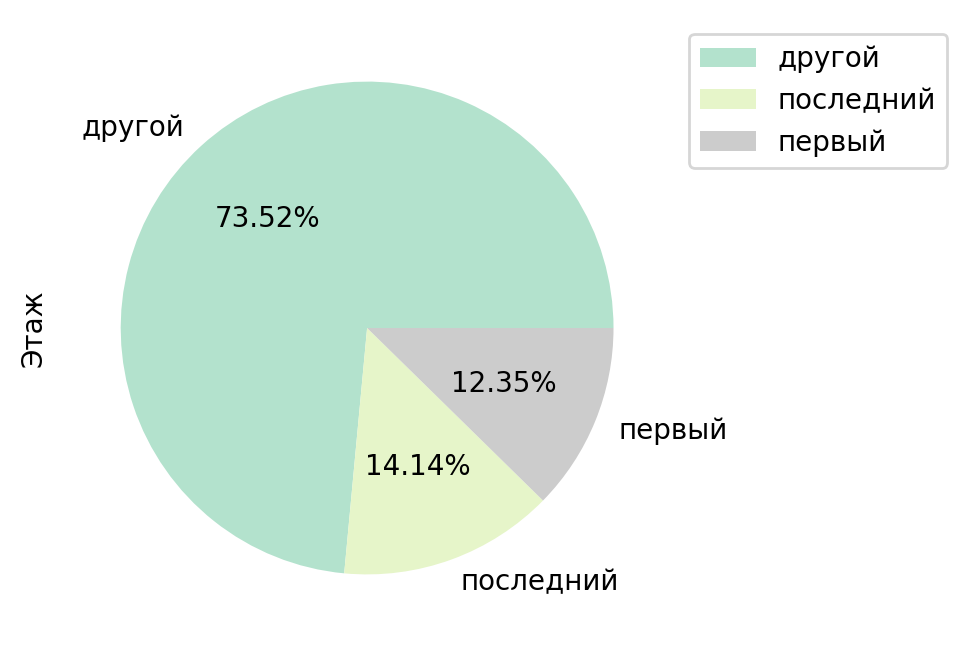

In [154]:
ax = (
    analyzed_data
    .pivot_table(index='floor_type', values='total_area', aggfunc='count')
    .sort_values(by='total_area', ascending=False)
    .plot(
        kind='pie', 
        figsize=(8, 4), 
        y='total_area', 
        autopct='%.2f%%', 
        colormap='Pastel2'
    )
)
ax.set_ylabel('Этаж')
plt.legend(bbox_to_anchor=(1, 1))

pass

**Объявлений о продаже квартир на первых и последних этажах гораздо меньше, чем на средних этажах (порядка 12% и 14% от общего числа предложений соответственно).** При медианной этажности в 9 этажей это не кажется удивительным.

#### Расстояние до центра города в метрах

Посмотрим на числовое описание данных в столбце с расстоянием до центра города в метрах `city_center_distance_m`.

In [158]:
analyzed_data['city_center_distance_m'].describe()

count    18055.000000
mean     14189.539407
std       8610.963809
min        181.000000
25%       9238.000000
50%      13094.000000
75%      16282.500000
max      65968.000000
Name: city_center_distance_m, dtype: float64

Посмотрим на гистограмму и диаграмму размаха расстояния до центра города в метрах.

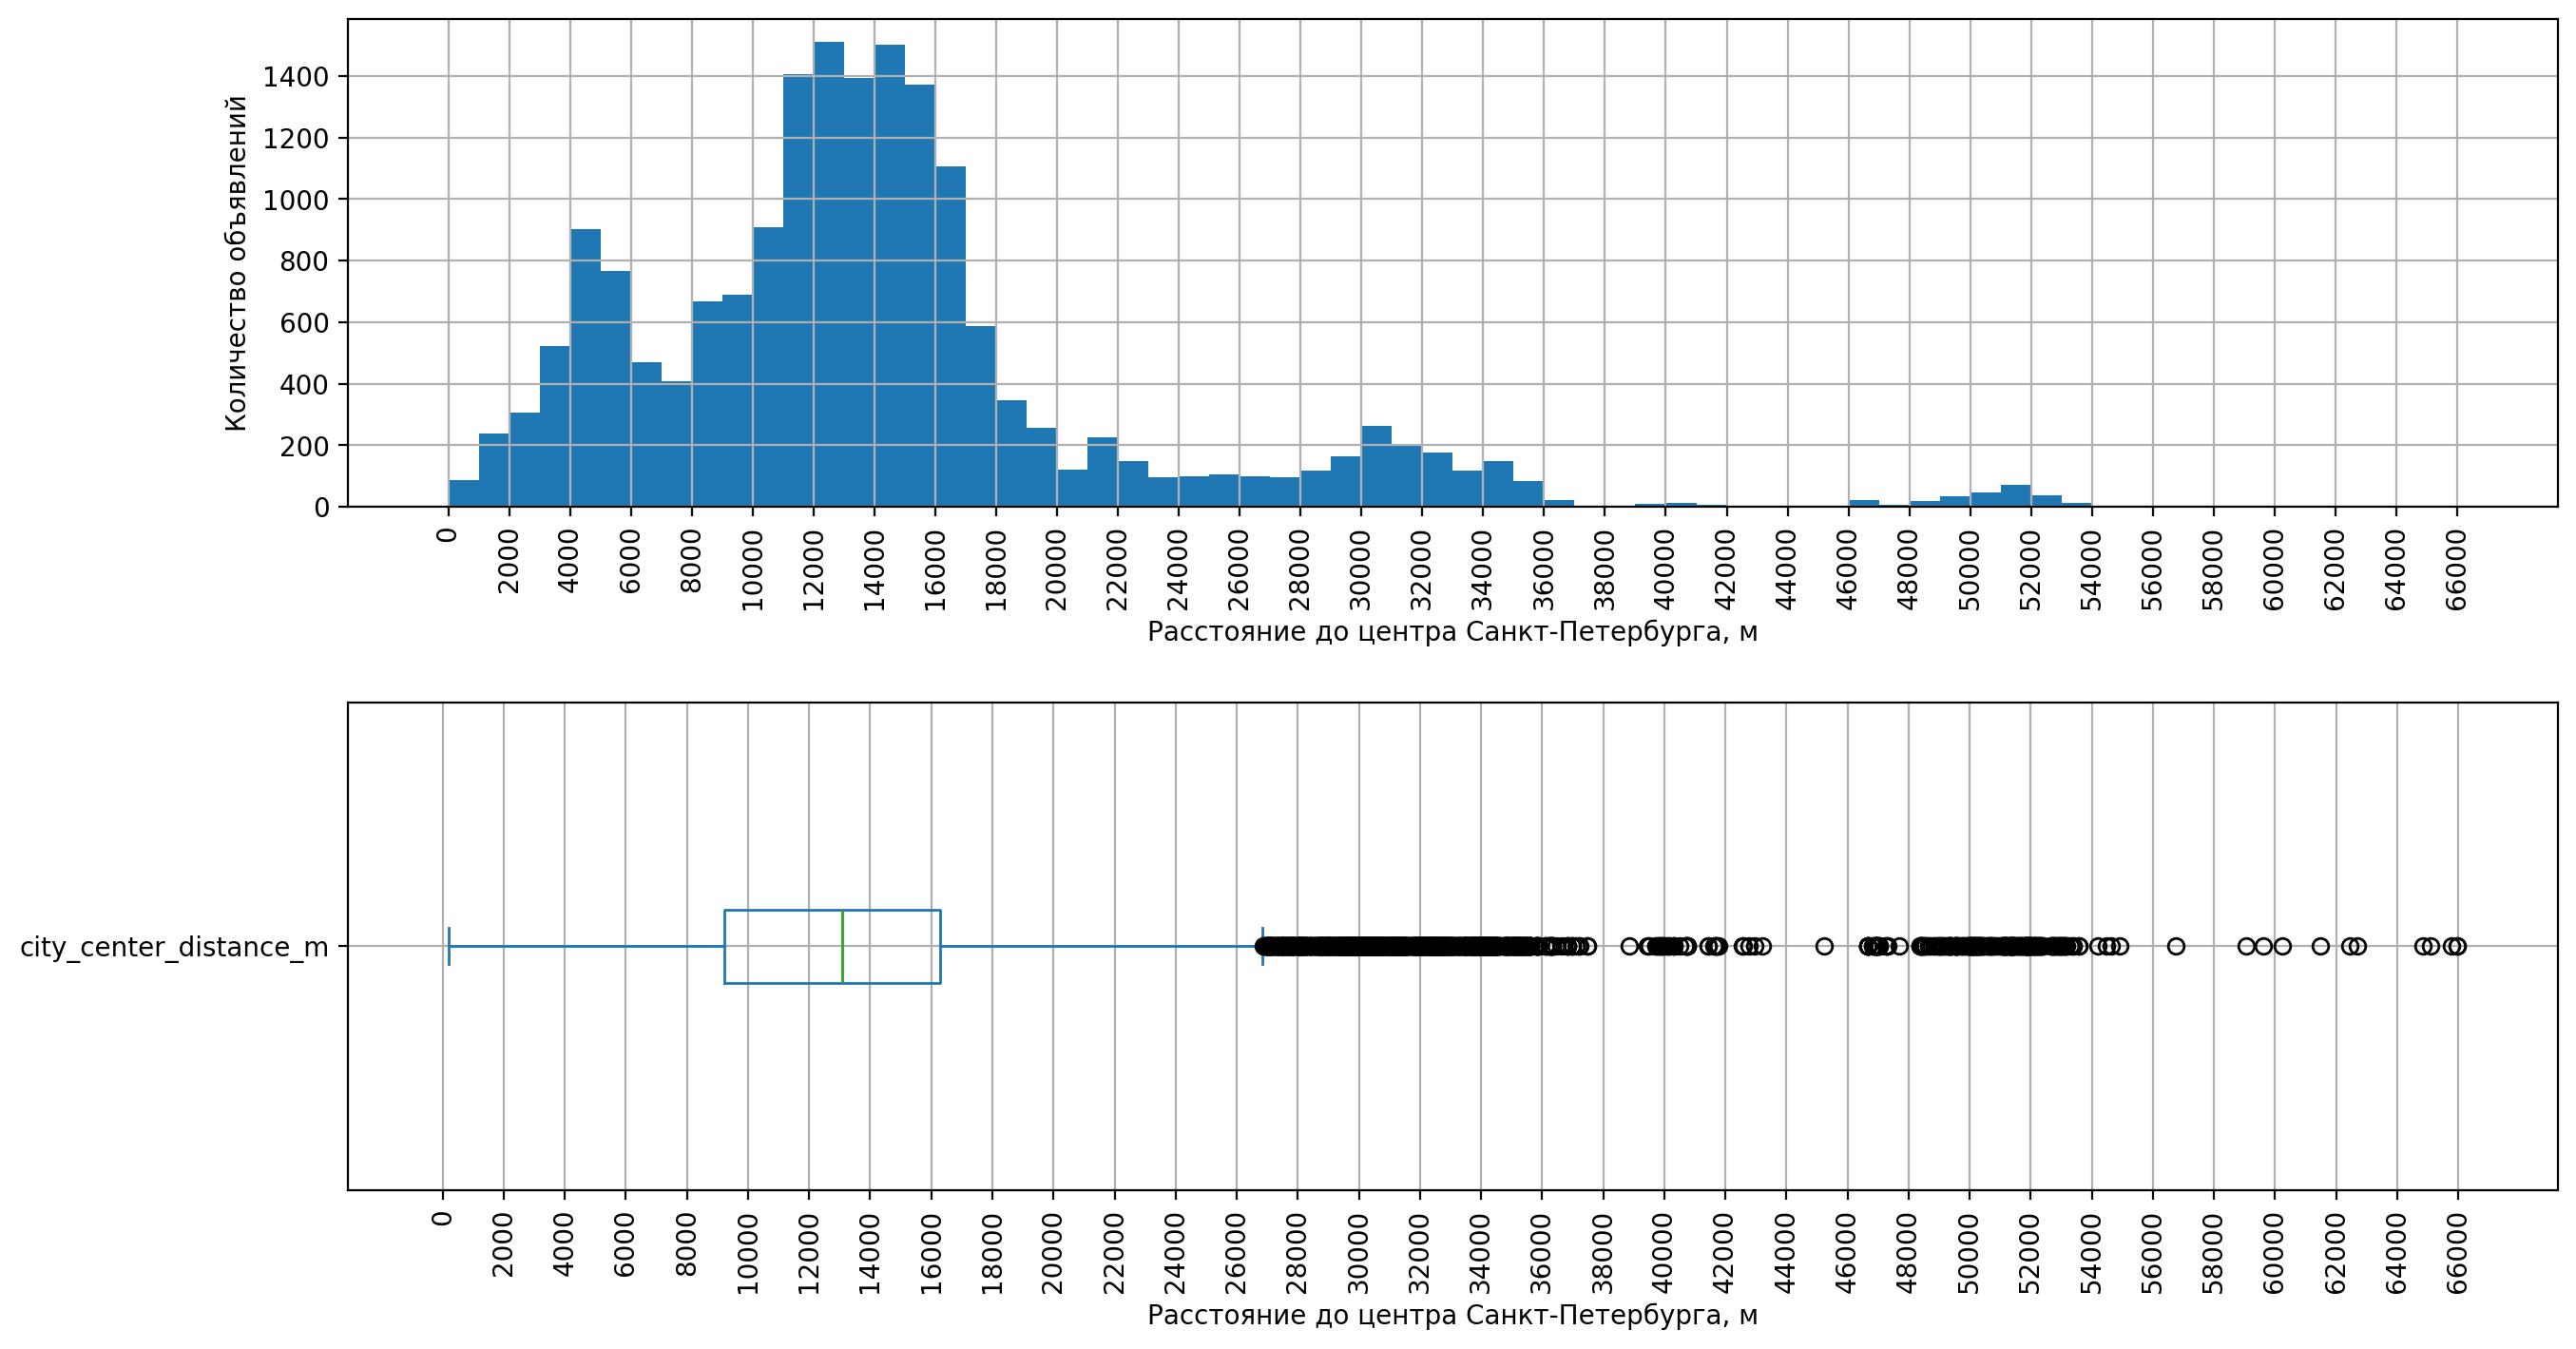

In [160]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = analyzed_data['city_center_distance_m'].plot(
    kind='hist', 
    bins=66, 
    grid=True,
    range=(0, 66000)
)
ax1.set_xlabel('Расстояние до центра Санкт-Петербурга, м')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(0, 68000, 2000), rotation=90)

plt.subplot(2, 1, 2)
ax2 = analyzed_data['city_center_distance_m'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Расстояние до центра Санкт-Петербурга, м')
plt.xticks(range(0, 68000, 2000), rotation=90)

pass

На гистограмме мы видим несколько пиков — это вполне объяснимо с учетом плотности населения в различных округах Санкт-Петербурга, а также с учетом административно-территориального деления: примерно в 4-5 км от центра находятся густонаселенные кварталы Петроградского и Василеостровского районов, около 12-15 км (ближе к КАД) начинаются спальные районы. Однако и за КАД есть жизнь: в 32 км от центра — квартиры в Колпино, в 50 с небольшим — квартиры в Ломоносове и Кронштадте и так далее. **Основная масса объявлений приходится на спальные районы ближе к КАД.** 

Квартиры дальше 27 км от центра мы можем считать выбросами. Можно предположить, что цена квартиры, например, в Кронштадте (или других отдаленных от центра населенных пунктах) больше зависит от расстояния до центра самого Кронштадта, а не от расстояния до центра Санкт-Петербурга.

#### Расстояние до ближайшего парка

Посмотрим на числовое описание данных в столбце с расстоянием до ближайшего парка `park_distance_m`.

In [164]:
analyzed_data['park_distance_m'].describe()

count    8026.000000
mean      490.592200
std       341.629781
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: park_distance_m, dtype: float64

Посмотрим на гистограмму и диаграмму размаха расстояния до ближайшего парка.

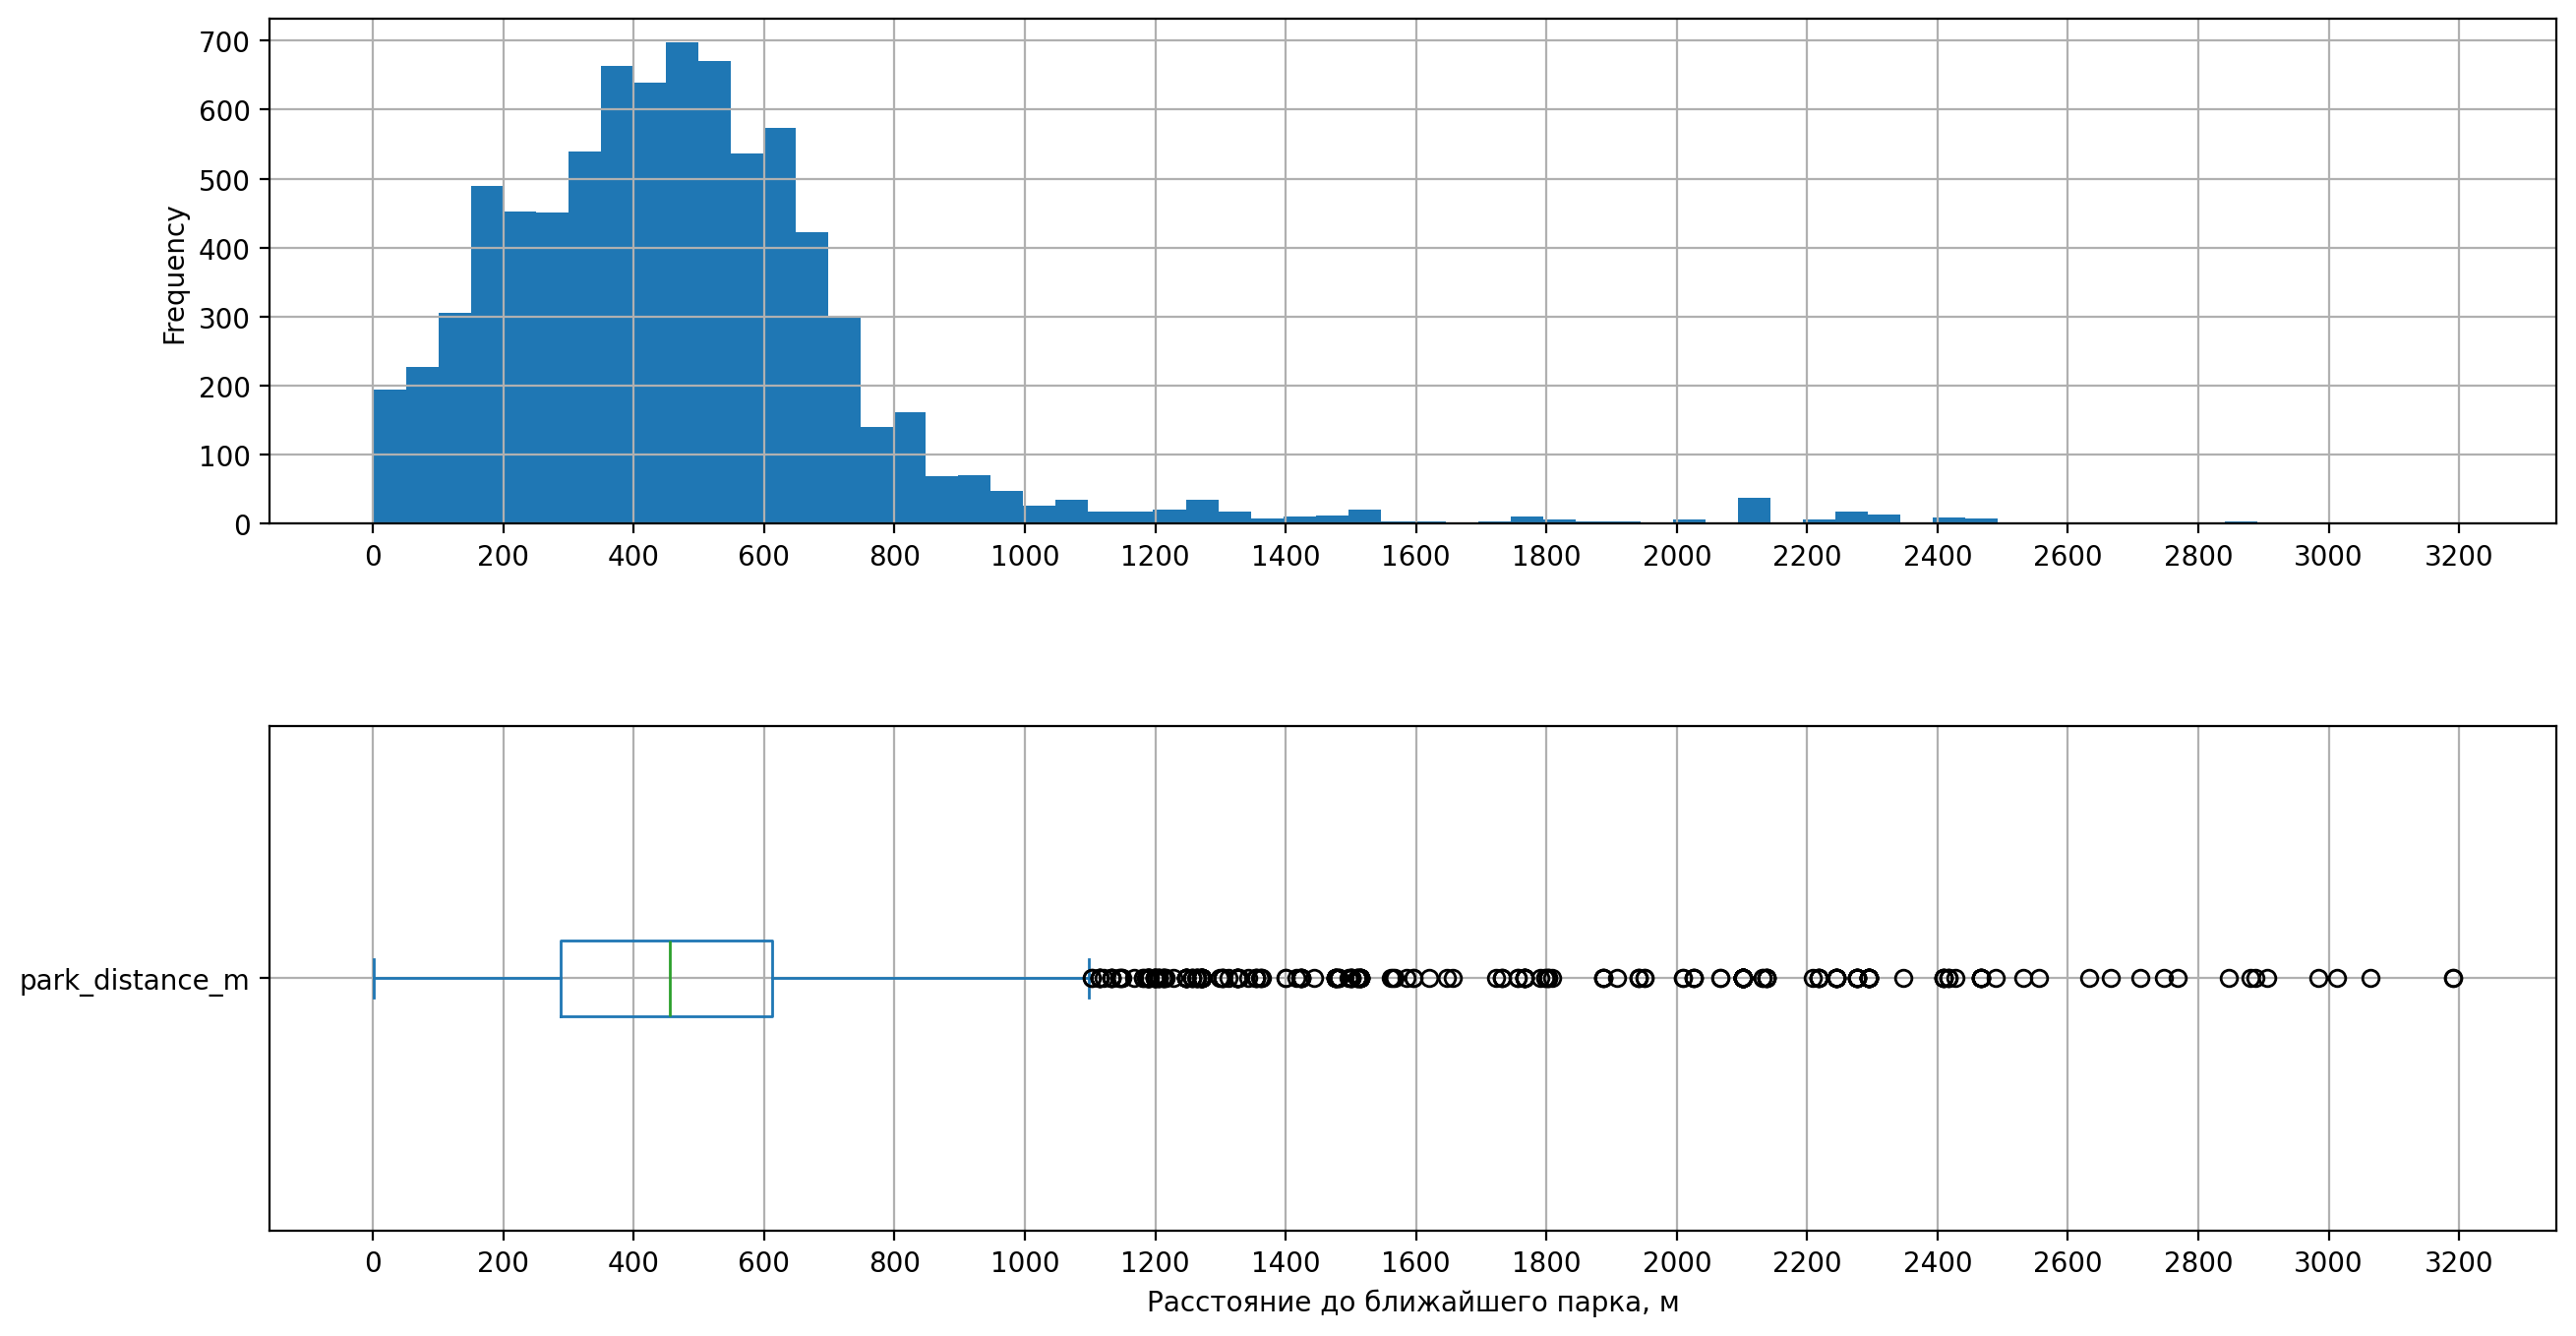

In [166]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax = analyzed_data['park_distance_m'].plot(
    kind='hist', 
    bins=64, 
    grid=True
)
ax1.set_xlabel('Расстояние до ближайшего парка, м')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(0, 3400, 200))

plt.subplot(2, 1, 2)
ax2 = analyzed_data['park_distance_m'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlabel('Расстояние до ближайшего парка, м')
plt.xticks(range(0, 3400, 200))

pass

Распределение Пуассона — ничего интересного, расходимся. Однако не стоит забывать, что не для всех квартир есть парк поблизости. Посмотрим долю таких объявлений.

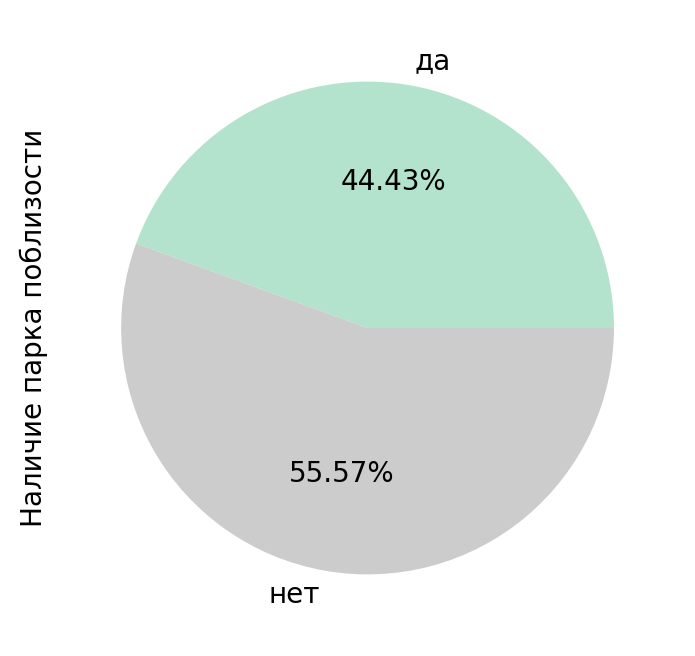

In [168]:
ax = (
    pd
    .Series(
        [len(analyzed_data.query('parks_around_3000_m > 0')), len(analyzed_data.query('parks_around_3000_m == 0'))], 
        index=['да', 'нет']
    )
    .plot(
        kind='pie', 
        figsize=(8, 4), 
        autopct='%.2f%%', 
        colormap='Pastel2'
    )
)
ax.set_ylabel('Наличие парка поблизости')

pass

**Более половины квартир продается в домах вдалеке от парковых зон.** Посмотрим на зависимость количества парков от расстояния до центра города.

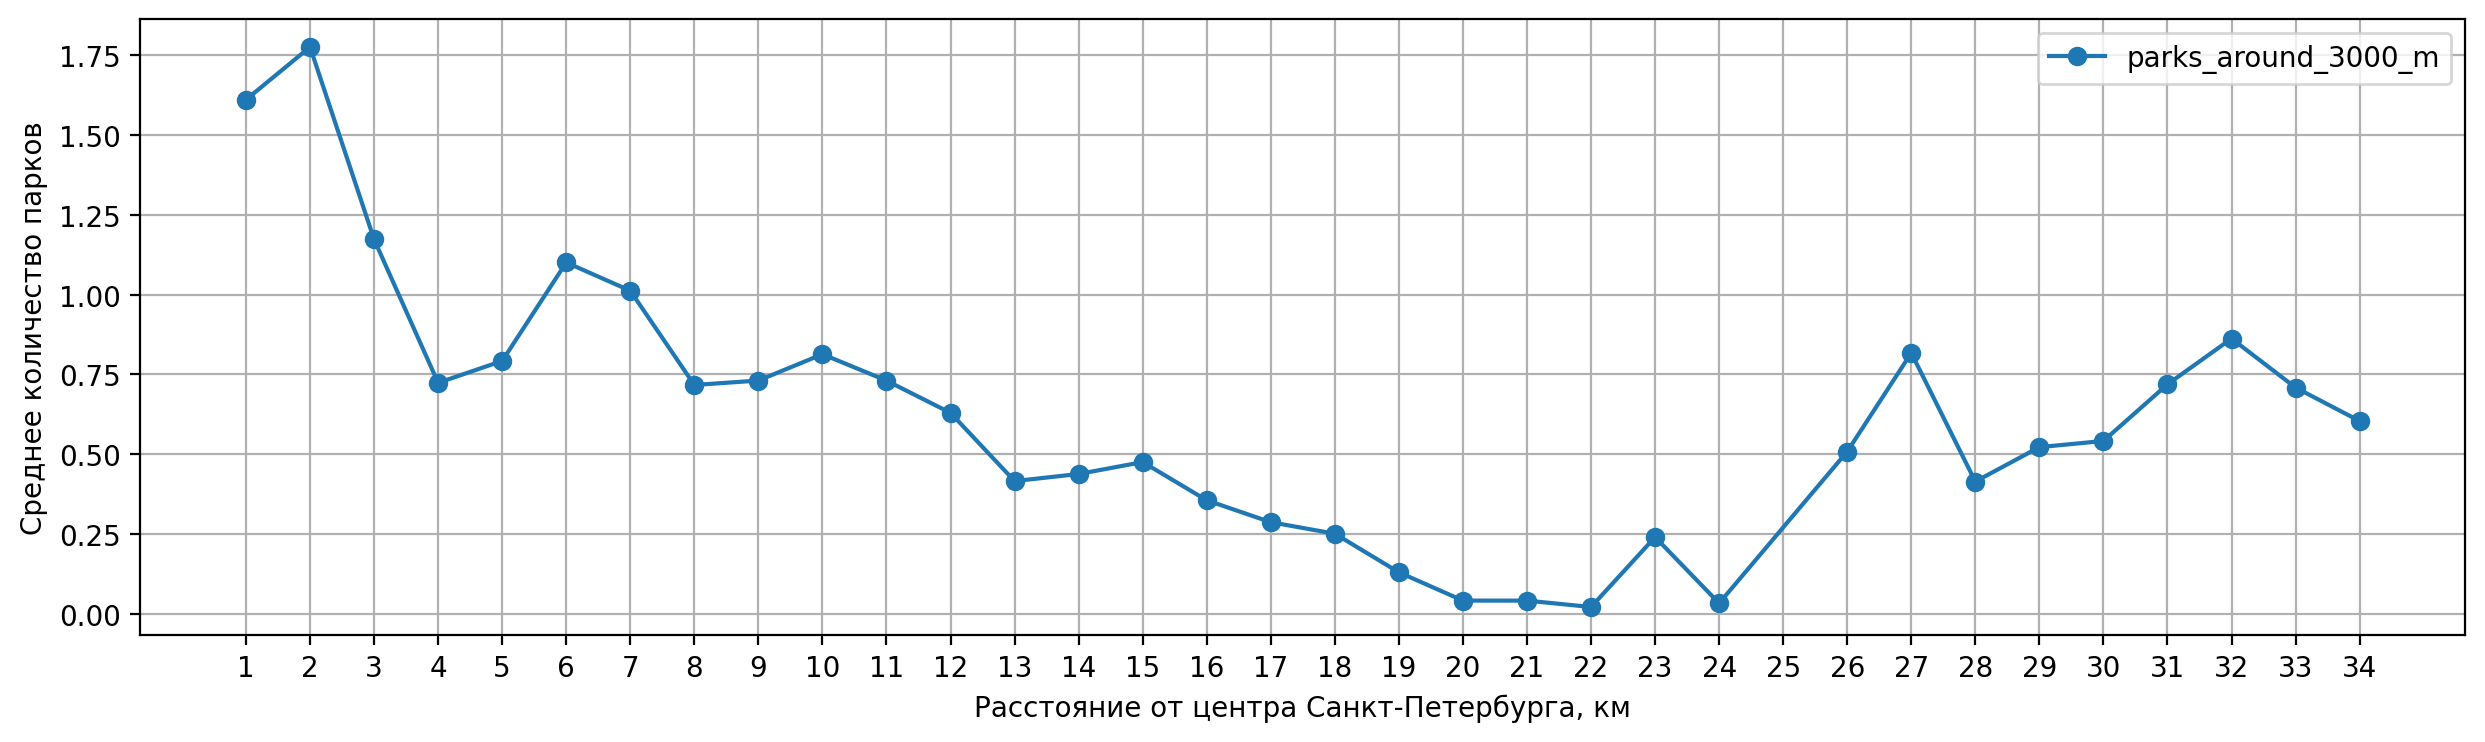

In [170]:
# серия километров от центра города, 
# для которых есть достаточное количество объявлений, хотя бы 100
km = analyzed_data['city_center_distance_km'].value_counts() >= 100
km = km[km == True]

# выводим график зависимости количества парков от расстояния до центра города
ax = (
    analyzed_data
    .query('city_center_distance_km in @km.index')
    .pivot_table(index='city_center_distance_km', values='parks_around_3000_m')
    .plot(
        style='-o', 
        grid=True, 
        figsize=(15, 4)
    )
)
ax.set_xlabel('Расстояние от центра Санкт-Петербурга, км')
ax.set_ylabel('Среднее количество парков')
plt.xticks(range(int(km.index.min()), int(km.index.max()) + 1, 1))

pass

Мы видим наиболее «зеленые» районы в центре Санкт-Петербурга, а по мере приближения к окраинам в районе КАД с парками поблизости от жилых домов всё становится плохо. За пределами КАД ситуация улучшается (вероятно за счет очень дендронасыщенных районов, например, Курортного или Приморского).

### Как быстро продавались квартиры

На этапе предобработки данных мы разделили объявления на активные и снятые с публикации на момент выгрузки данных (столбец `is_exposition_end`).

In [174]:
exposition_analyzed_data = analyzed_data.query('is_exposition_end == True')

Посмотрим на числовое описание данных в столбце длительность размещения объявлений `exposition_duration_days`.

In [176]:
exposition_analyzed_data['exposition_duration_days'].describe()

count    20385.000000
mean       180.770027
std        219.766488
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: exposition_duration_days, dtype: float64

Посмотрим на гистограмму и диаграмму размаха длительности размещения объявлений в днях. Разобъем гистограмму на корзины по 30 дней.

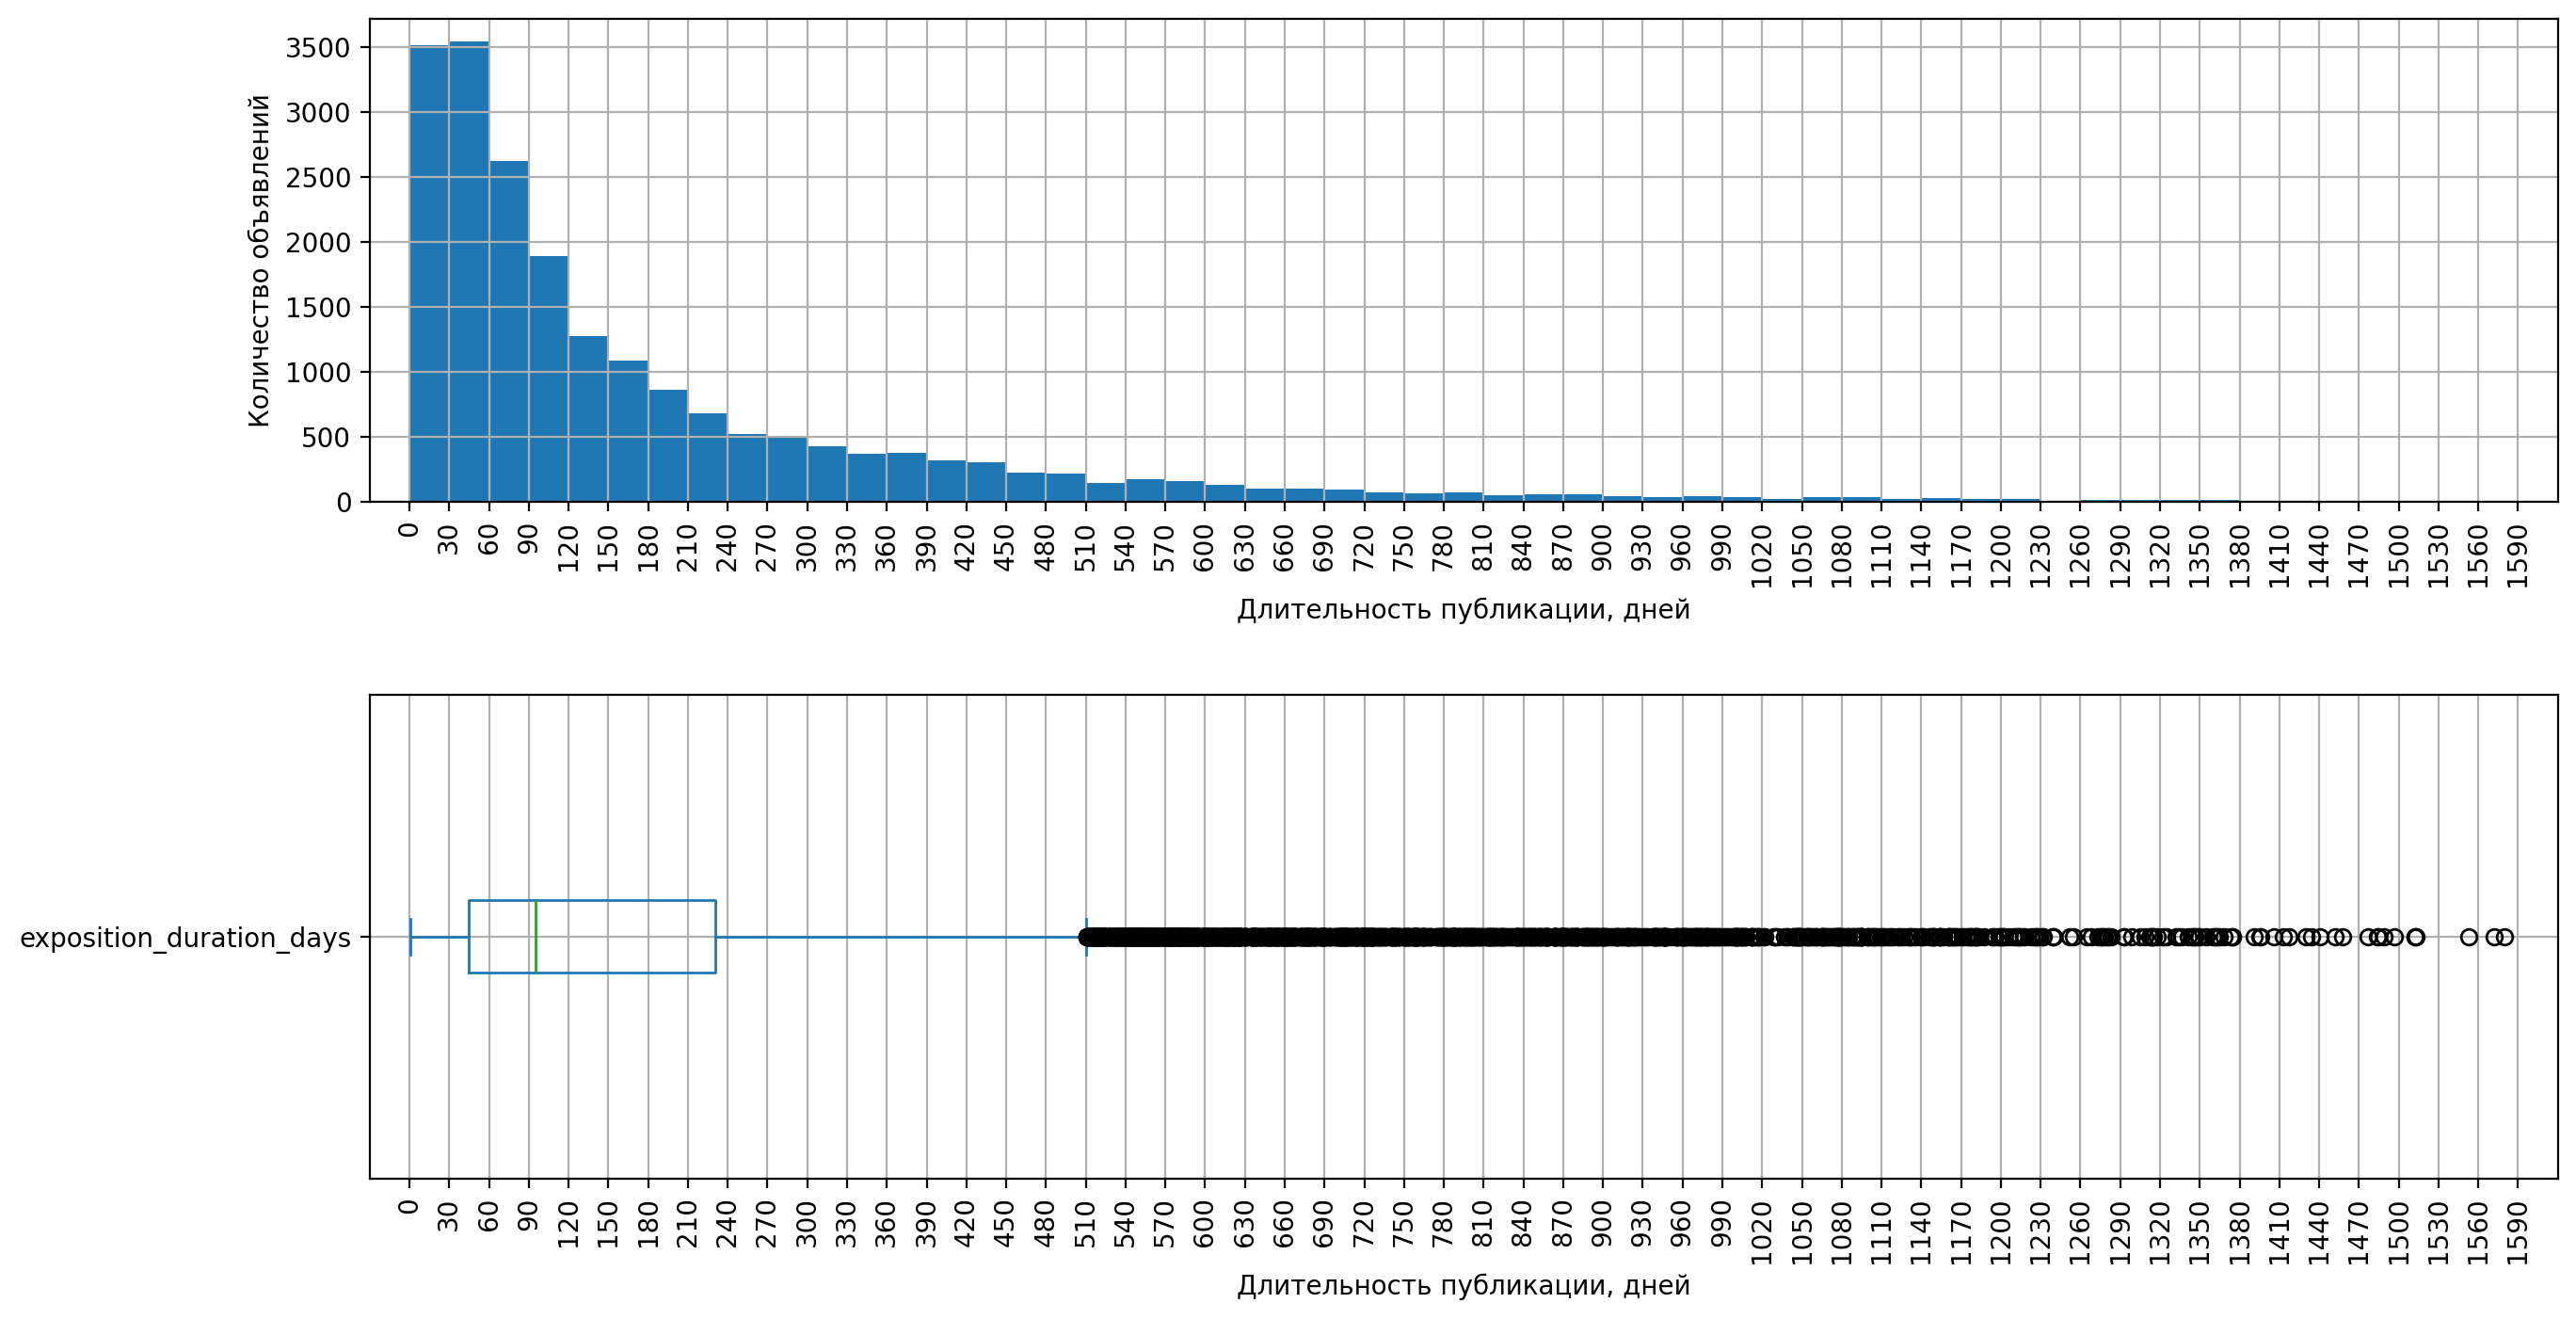

In [178]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
ax1 = exposition_analyzed_data['exposition_duration_days'].plot(
    kind='hist', 
    bins=53, 
    grid=True, 
    range=(0, 1590)
)
ax1.set_xlim([-30, 1620])
ax1.set_xlabel('Длительность публикации, дней')
ax1.set_ylabel('Количество объявлений')
plt.xticks(range(0, 1620, 30), rotation=90)

plt.subplot(2, 1, 2)
ax2 = exposition_analyzed_data['exposition_duration_days'].plot(
    kind='box', 
    vert=False, 
    grid=True
)
ax2.set_xlim([-30, 1620])
ax2.set_xlabel('Длительность публикации, дней')
plt.xticks(range(0, 1620, 30), rotation=90)

pass

Средняя длительность публикации объявлений продавцами в сервисе Яндекс Недвижимость составляет 180 дней, медианная — 95 дней. На диаграмме размаха мы видим, что **продажа квартиры обычно занимает от полутора до семи с половиной месяцев**. К быстрым продажам можно отнести длительность до полутора месяцев, а к необычайно долгим продажам — длительность от 17 месяцев и более. При этом не стоит забывать, что реальные сроки продаж могут быть меньше — не всякий продавец непосредственно в день продажи будет заходить в личный кабинет и снимать объявление с публикации (система сама снимет объявление с публикации по окончании определенного периода).

Проанализируем аномалии в длительности продажи. Для этого увеличим масштаб гистограммы до уровня детализации в 1 день.

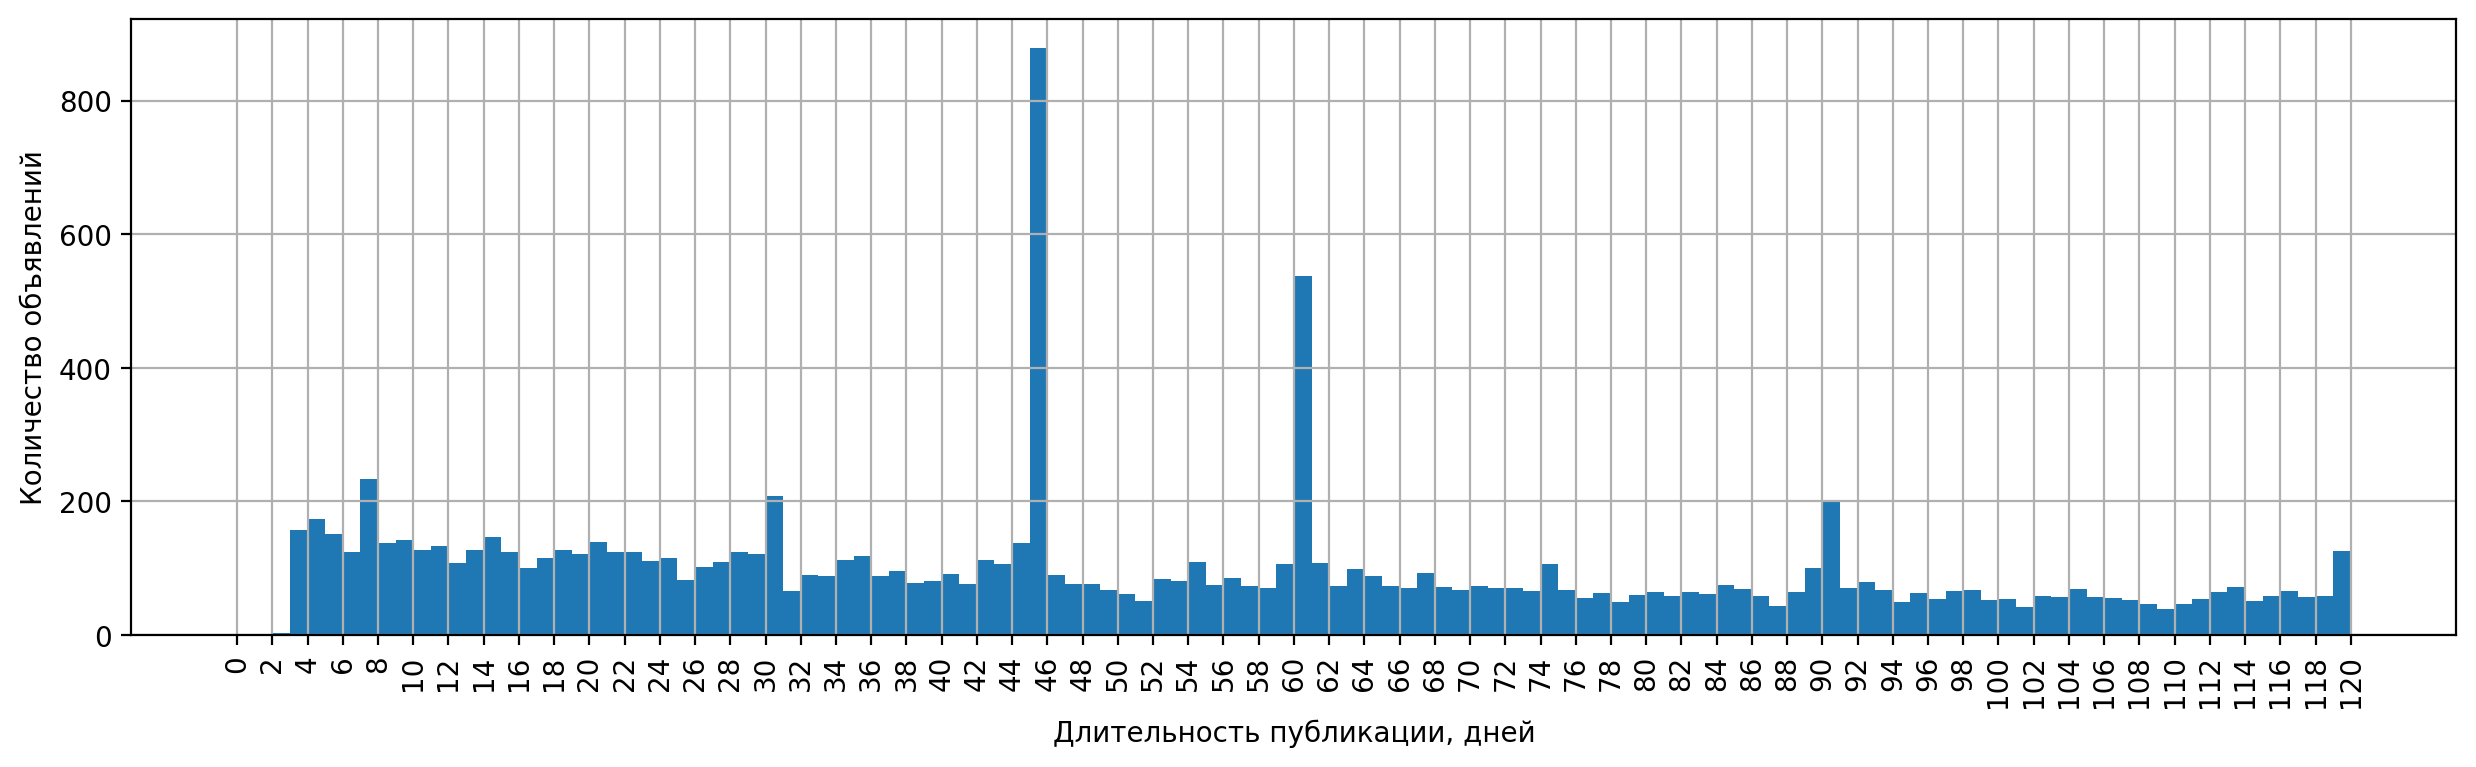

In [181]:
ax = exposition_analyzed_data['exposition_duration_days'].plot(
    kind='hist', 
    bins=120, 
    grid=True, 
    range=(0, 120), 
    figsize=(15, 4)
)
ax.set_xlabel('Длительность публикации, дней')
ax.set_ylabel('Количество объявлений')
plt.xticks(range(0, 122, 2), rotation=90)

pass

На гистограмме видны пики на 7-й, 30-й, 45-й, 60-й, 90-й и 120-й дни. Вероятно в период, за который у нас выгружены данные, в сервисе Яндекс Недвижимость действовали тарифы именно с такими длительностями публикации объявлений.

### Факторы, которые больше всего влияют на общую стоимость объекта

Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.

#### Общая площадь

Построим диаграмму рассеяния для общей площади квартиры и её полной стоимости.

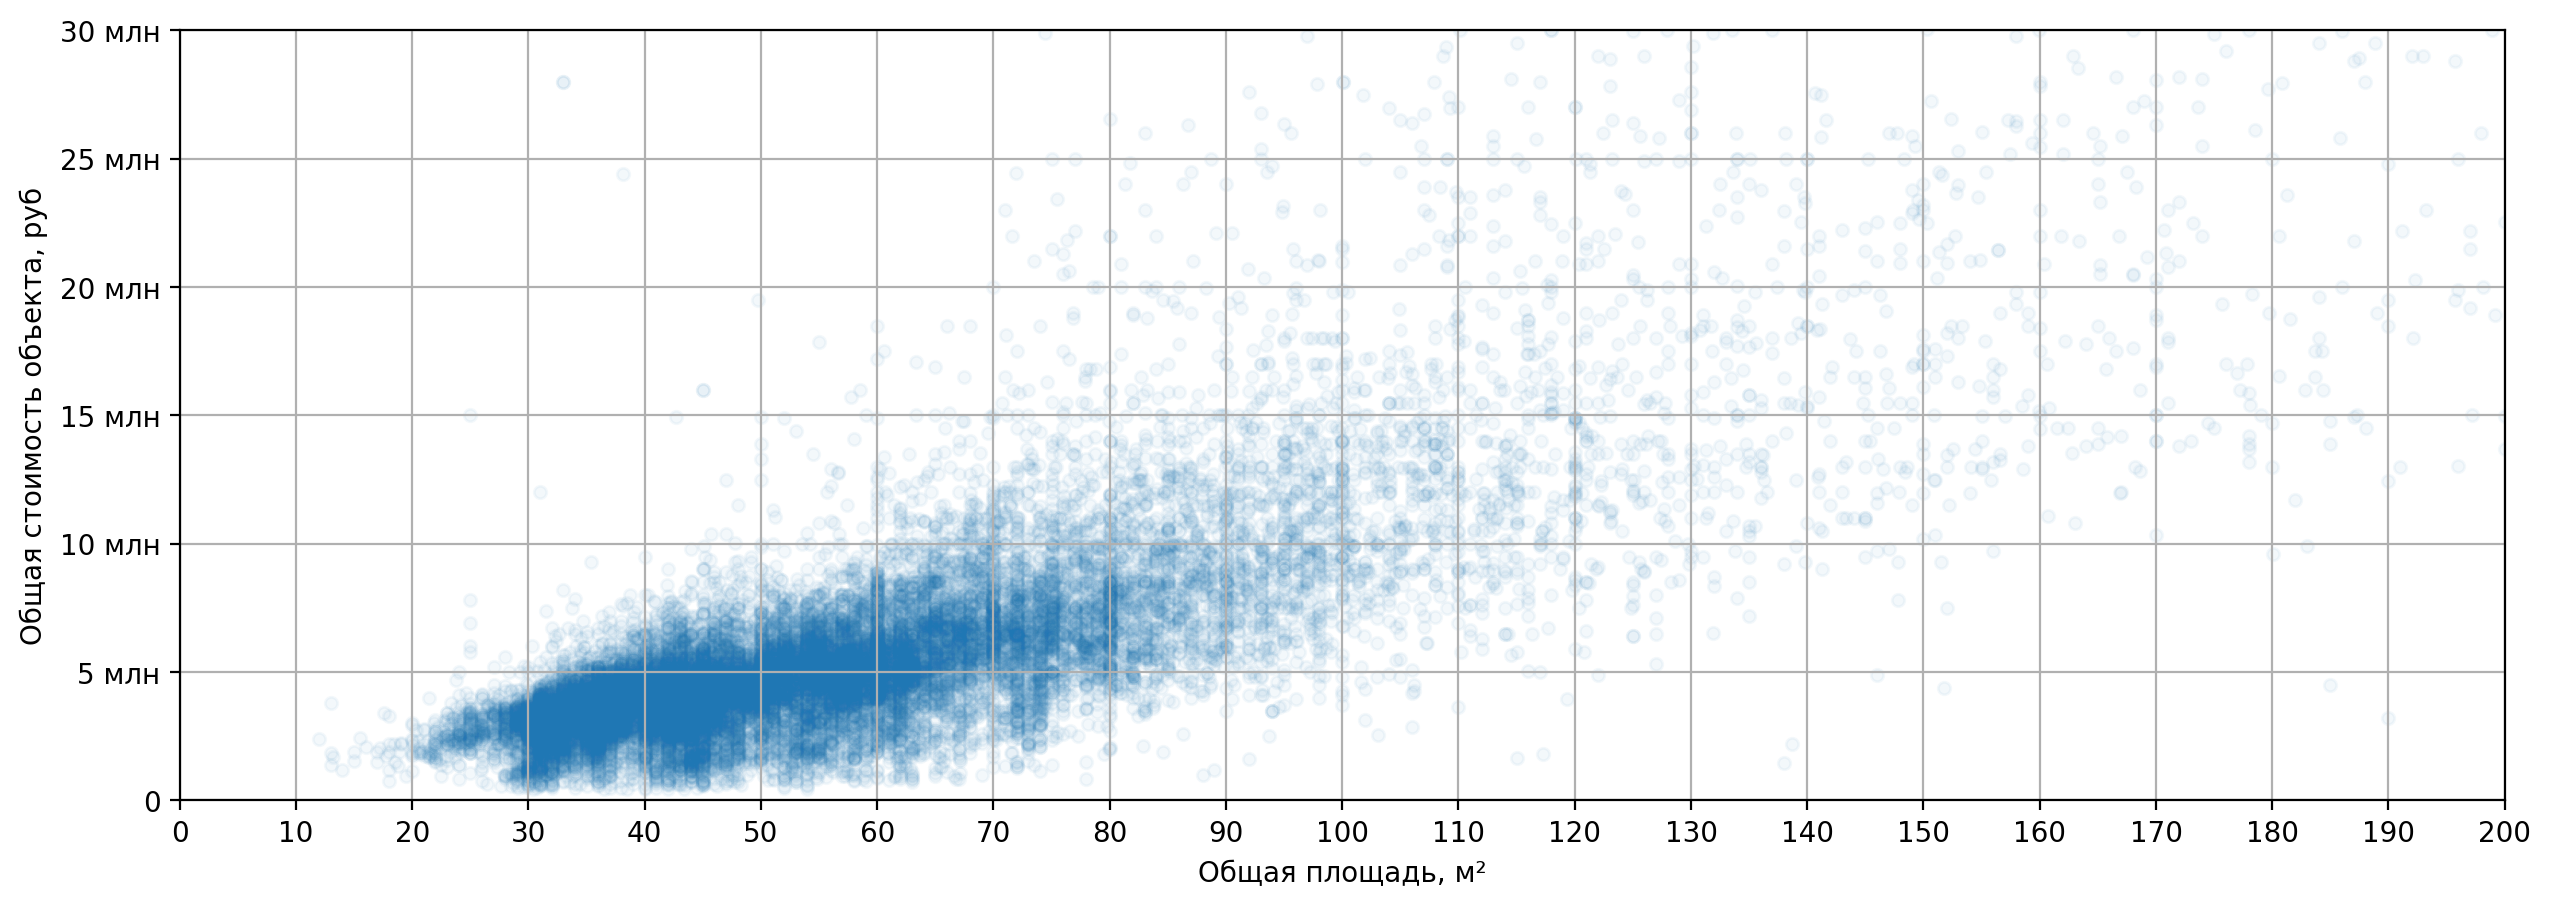

In [187]:
ax = analyzed_data.plot(
    x='total_area', 
    y='last_price', 
    kind='scatter', 
    alpha=0.05,
    grid=True,
    figsize=(15, 5)
)
ax.set_xlabel('Общая площадь, м²')
ax.set_ylabel('Общая стоимость объекта, руб')
ax.yaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xlim([0, 200])
ax.set_ylim([0, 30000000])
plt.xticks(range(0, 210, 10))
plt.yticks(range(0, 35000000, 5000000))

pass

In [188]:
analyzed_data['total_area'].corr(analyzed_data['last_price'])

0.7376217136597841

На диаграмме рассеяния мы видим, что **с ростом общей площади квартиры растет и общая стоимость объекта. Коэффициент корреляции Пирсона — положительный, равен 0.73, что говорит о тесной взаимосвязи этих двух параметров.**

#### Жилая площадь

Посмотрим на взаимосвязь между жилой площадью квартиры и её полной стоимостью.

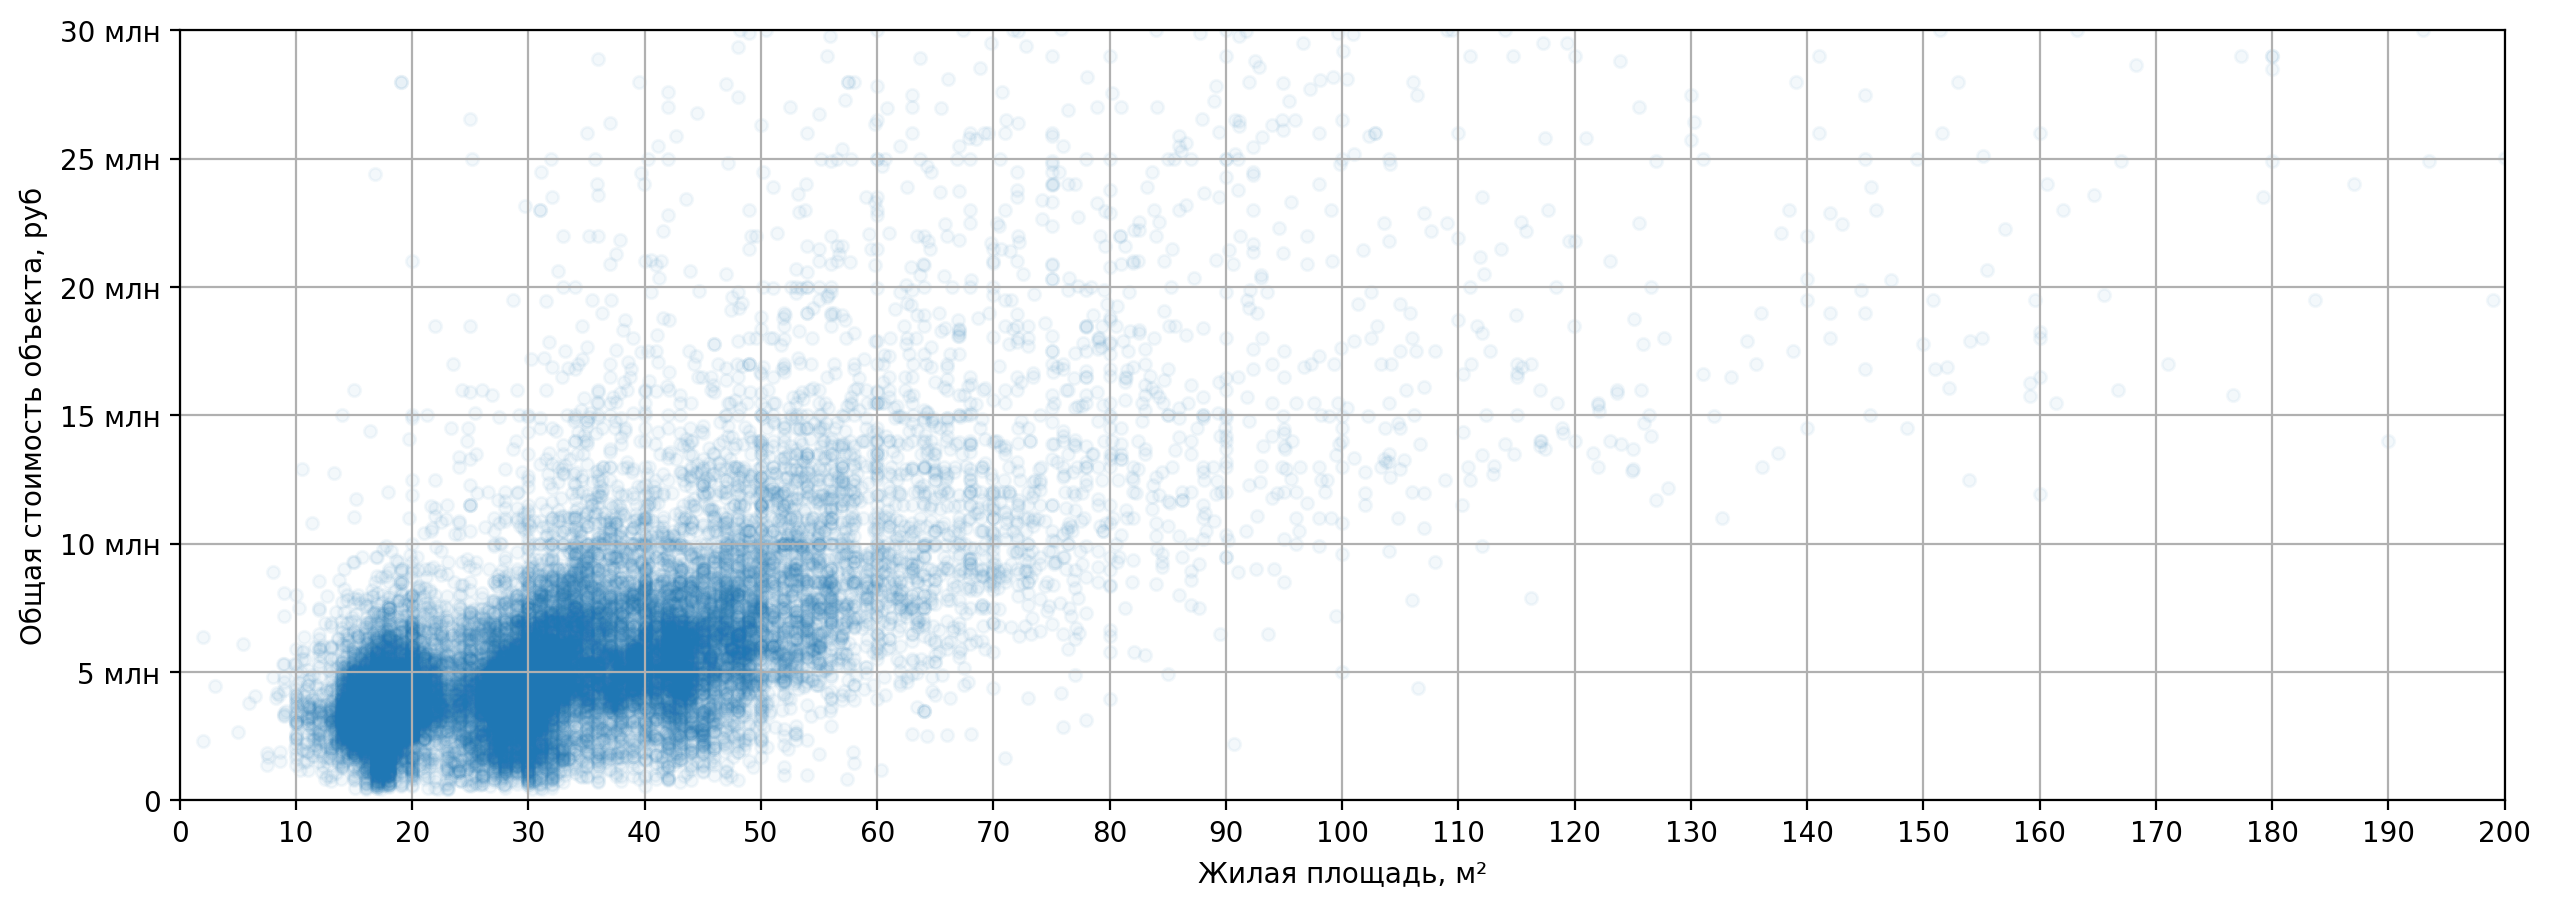

In [192]:
ax = analyzed_data.plot(
    x='living_area', 
    y='last_price', 
    kind='scatter', 
    alpha=0.05,
    grid=True,
    figsize=(15, 5)
)
ax.set_xlabel('Жилая площадь, м²')
ax.set_ylabel('Общая стоимость объекта, руб')
ax.yaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xlim([0, 200])
ax.set_ylim([0, 30000000])
plt.xticks(range(0, 210, 10))
plt.yticks(range(0, 35000000, 5000000))

pass

In [193]:
analyzed_data['living_area'].corr(analyzed_data['last_price'])

0.6623395375834554

На диаграмме рассеяния отчетливо видны три области, характеризующие одно-, двух- и трехкомнатные квартиры. **С ростом жилой площади растет и общая стоимость объекта.** Коэффициент корреляции Пирсона — положительный, равен 0.58. При этом корреляция менее устойчивая, чем взаимосвязь общей площади квартиры и её стоимости.

#### Площадь кухни

Построим диаграмму рассеяния для площади кухни и общей стоимости квартиры.

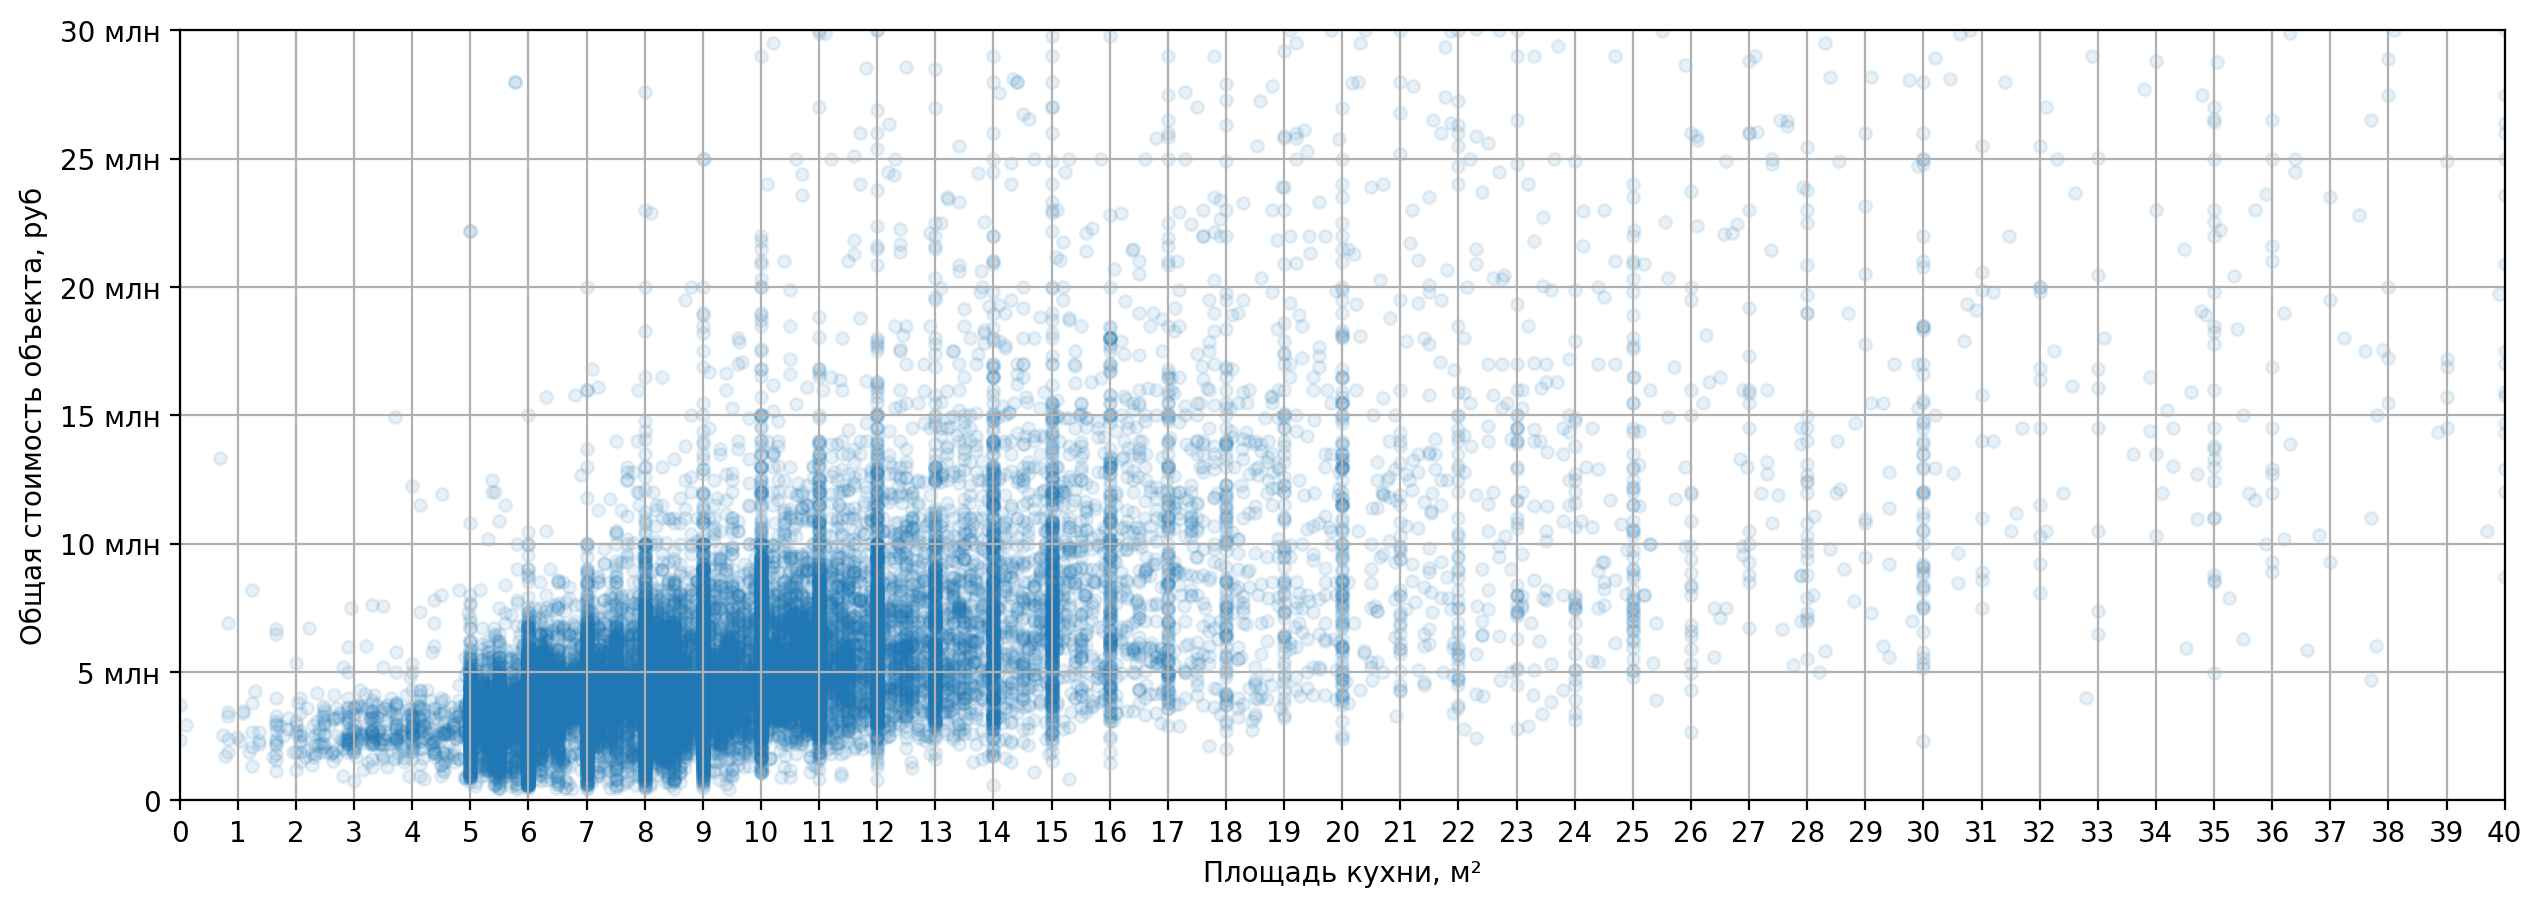

In [197]:
ax = analyzed_data.plot(
    x='kitchen_area', 
    y='last_price', 
    kind='scatter', 
    alpha=0.1,
    grid=True,
    figsize=(15, 5)
)
ax.set_xlabel('Площадь кухни, м²')
ax.set_ylabel('Общая стоимость объекта, руб')
ax.yaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xlim([0, 40])
ax.set_ylim([0, 30000000])
plt.xticks(range(0, 41))
plt.yticks(range(0, 35000000, 5000000))

pass

In [198]:
analyzed_data['kitchen_area'].corr(analyzed_data['last_price'])

0.5735387400310422

На диаграмме рассеяния отчетливо видна **область с запредельно маленькими кухнями — стоимость таких квартир-студий и апартаментов не зависит от конктерного размера кухни.** При этом такие объекты могут стоить дороже, чем квартиры кухнями большего размера. **Начиная с 5-6 м² можно наблюдать увеличение полной стоимости объекта с ростом площади кухни.** Таким образом взаимосвязь между размером кухни и стоимостью квартиры не линейная, она менее устойчивая, чем корреляция общей площади квартиры и её стоимости.

#### Количество комнат

Вычислим медианные стоимости квартир разной комнатности. При этом убедимся, что для числа комнат есть выборка достаточного размера для проведения анализа.

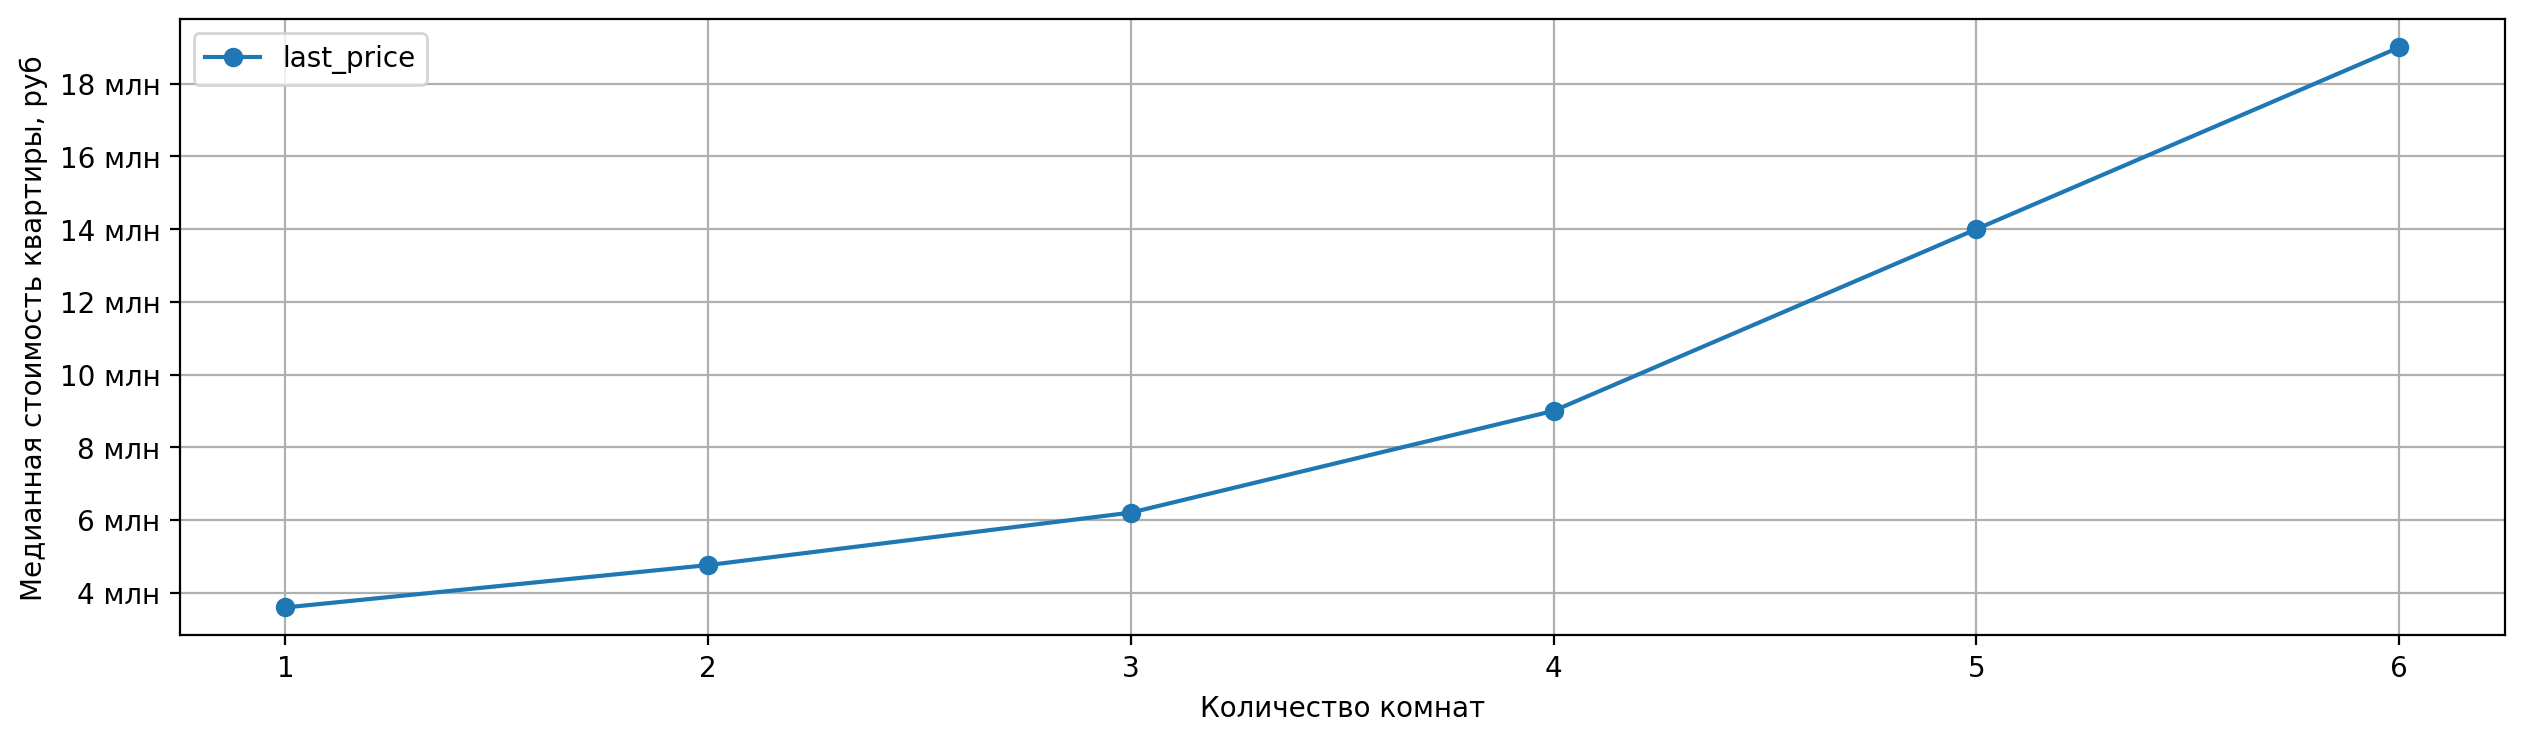

In [202]:
# серия количества комнат
# для которых есть достаточное количество объявлений, хотя бы 100
rooms = analyzed_data['rooms'].value_counts() >= 100
rooms = rooms[rooms == True]

ax = (
    analyzed_data
    .query('rooms in @rooms.index')
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(
        style='-o', 
        grid=True, 
        figsize=(15, 4)
    )   
)
ax.yaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xlabel('Количество комнат')
ax.set_ylabel('Медианная стоимость квартиры, руб')
plt.xticks(range(int(rooms.index.min()), int(rooms.index.max()) + 1, 1))

pass

Тут всё очевидно: **чем больше комнат — тем больше площадь квартиры, чем больше площадь — тем выше общая стоимость объекта.**

#### Тип этажа, на котором расположена квартира

Вычислим медианные стоимости квартир для каждого типа этажа.

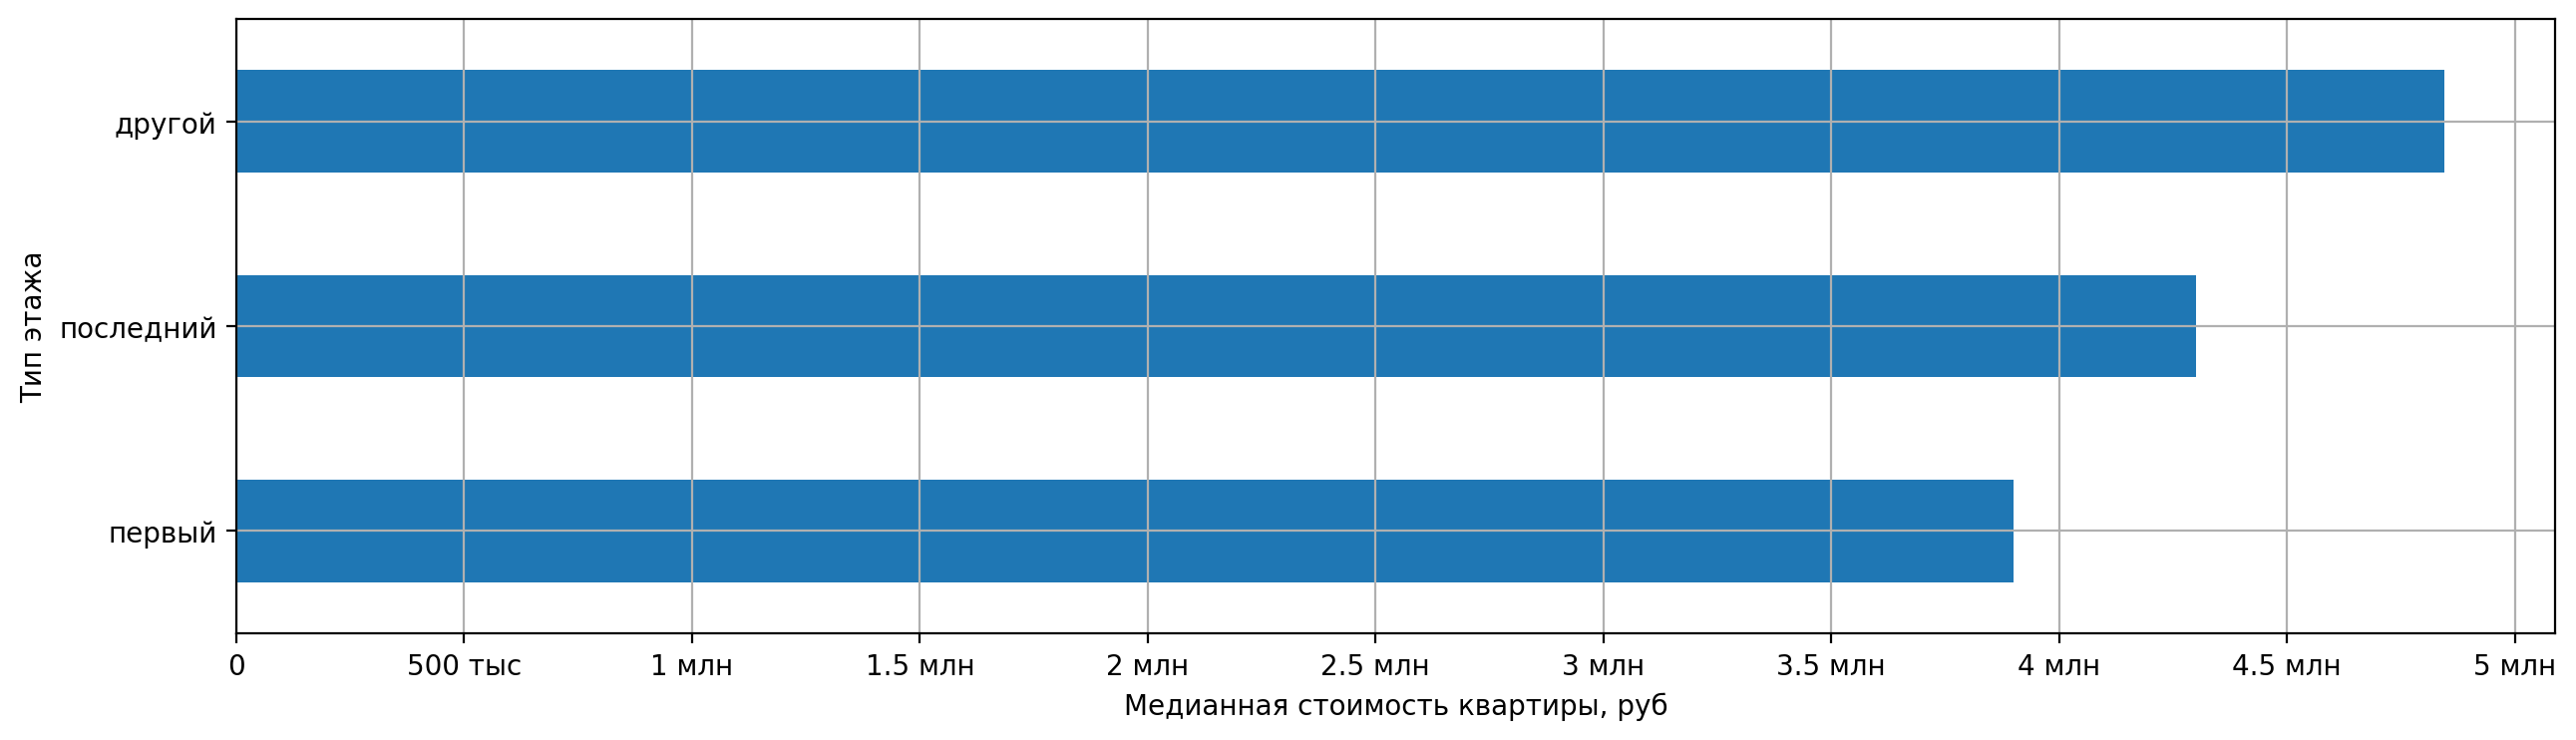

In [206]:
ax = (
    analyzed_data
    .pivot_table(index='floor_type', values='last_price', aggfunc='median')
    .sort_values(by='last_price')
    .plot(
        kind='barh',
        figsize=(15, 4), 
        grid=True,
        legend=''
    )
)
ax.xaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xlabel('Медианная стоимость квартиры, руб')
ax.set_ylabel('Тип этажа')
plt.xticks(range(0, 5500000, 500000))

pass

Из графика видно, что **квартиры на первых и последних этажах стоят дешевле квартир, расположенных на «средних» этажах, — на 20% и на 11% соответственно.**

#### Дата размещения

Определим зависимость стоимости квартиры от дня недели размещения.

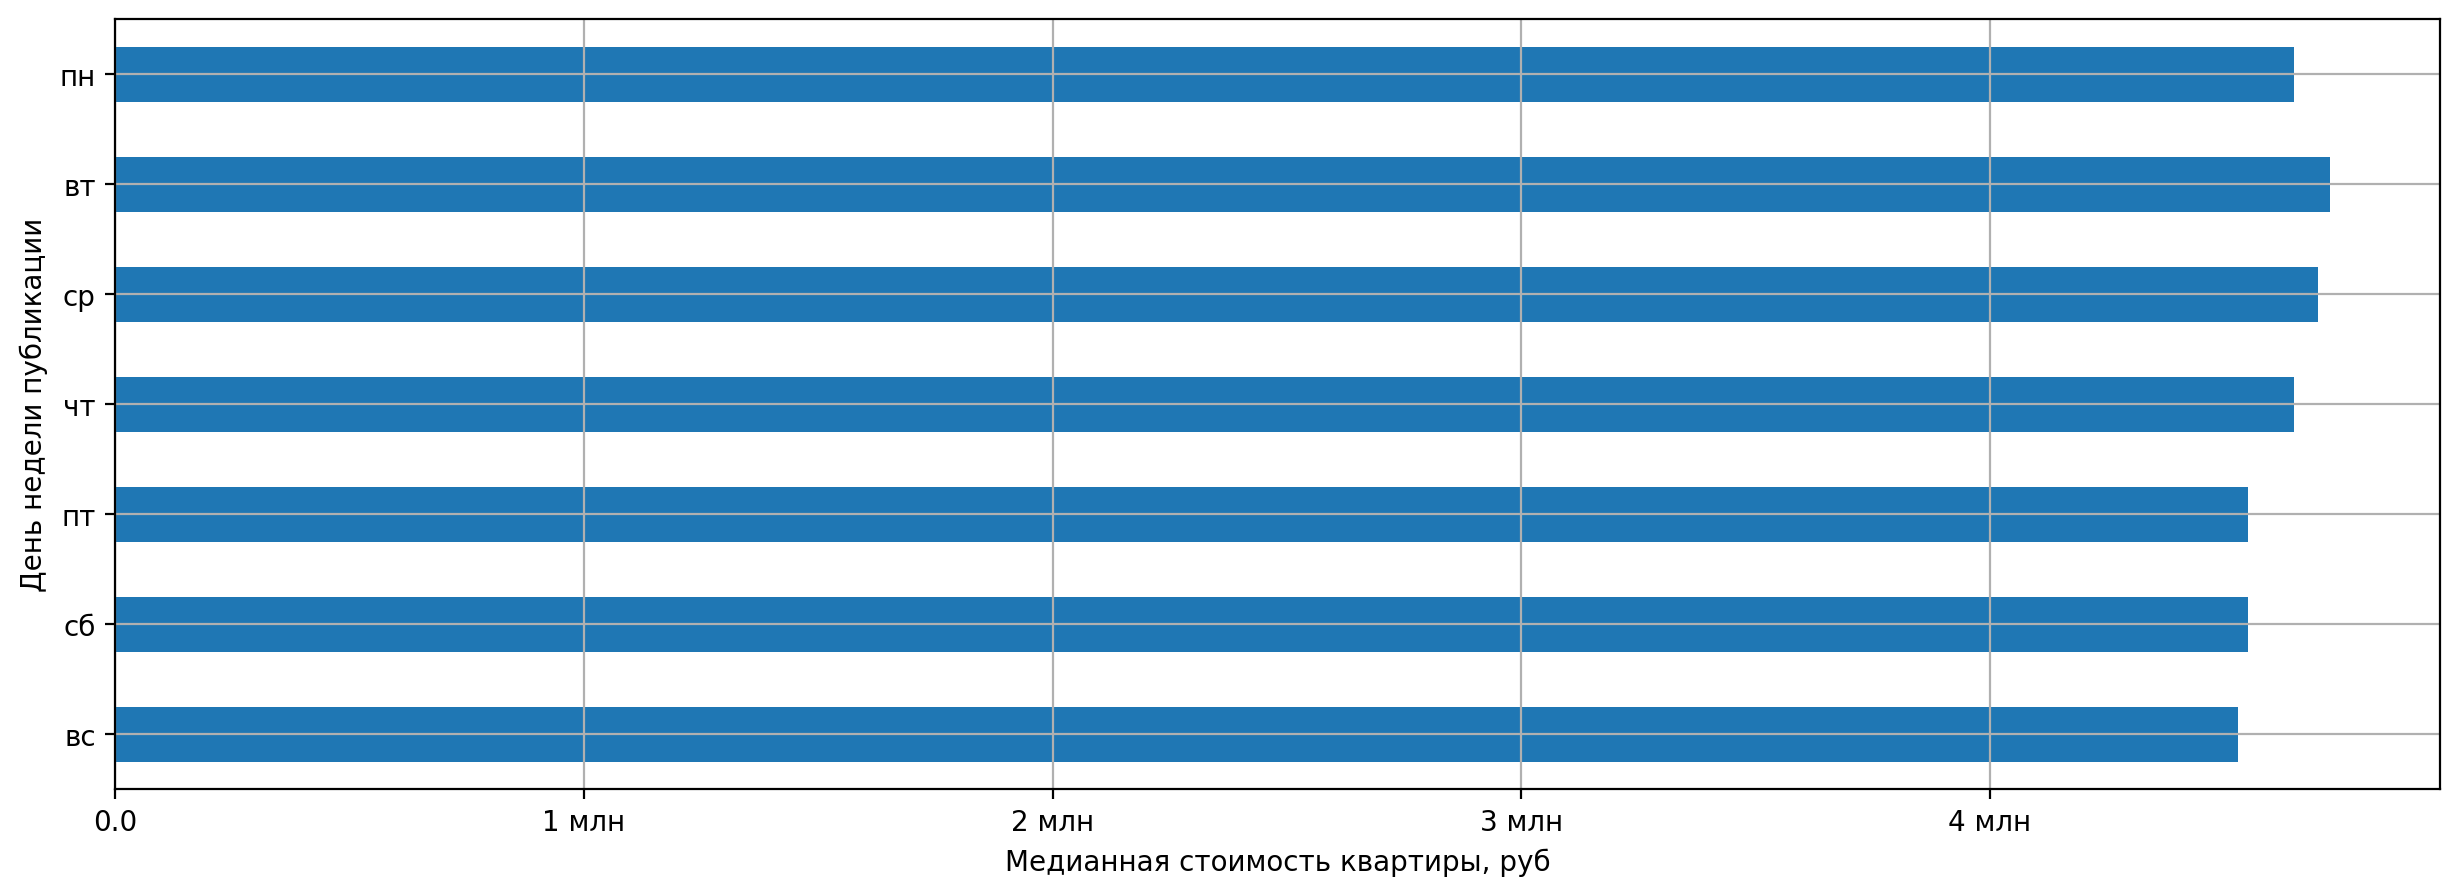

In [210]:
ax = (
    analyzed_data
    .pivot_table(index='exposition_date_weekday', values='last_price', aggfunc='median')
    .sort_index(ascending=False)
    .plot(
        kind='barh',
        figsize=(15, 5), 
        grid=True,
        legend=''
    )
)
ax.set_xlabel('Медианная стоимость квартиры, руб')
ax.set_ylabel('День недели публикации')
ax.xaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_yticklabels(list(reversed(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])))

pass

**Зависимости полной стоимости объекта от дня недели публикации не наблюдается.** Посмотрим на зависимость от года публикации. Необходимо учесть, что в данных у нас не все года «полные».

In [212]:
(
    # самая ранняя дата публикации
    analyzed_data['exposition_date'].min(),
    # самая поздняя дата публикации
    analyzed_data['exposition_date'].max()
)

(Timestamp('2014-11-27 00:00:00'), Timestamp('2019-05-03 00:00:00'))

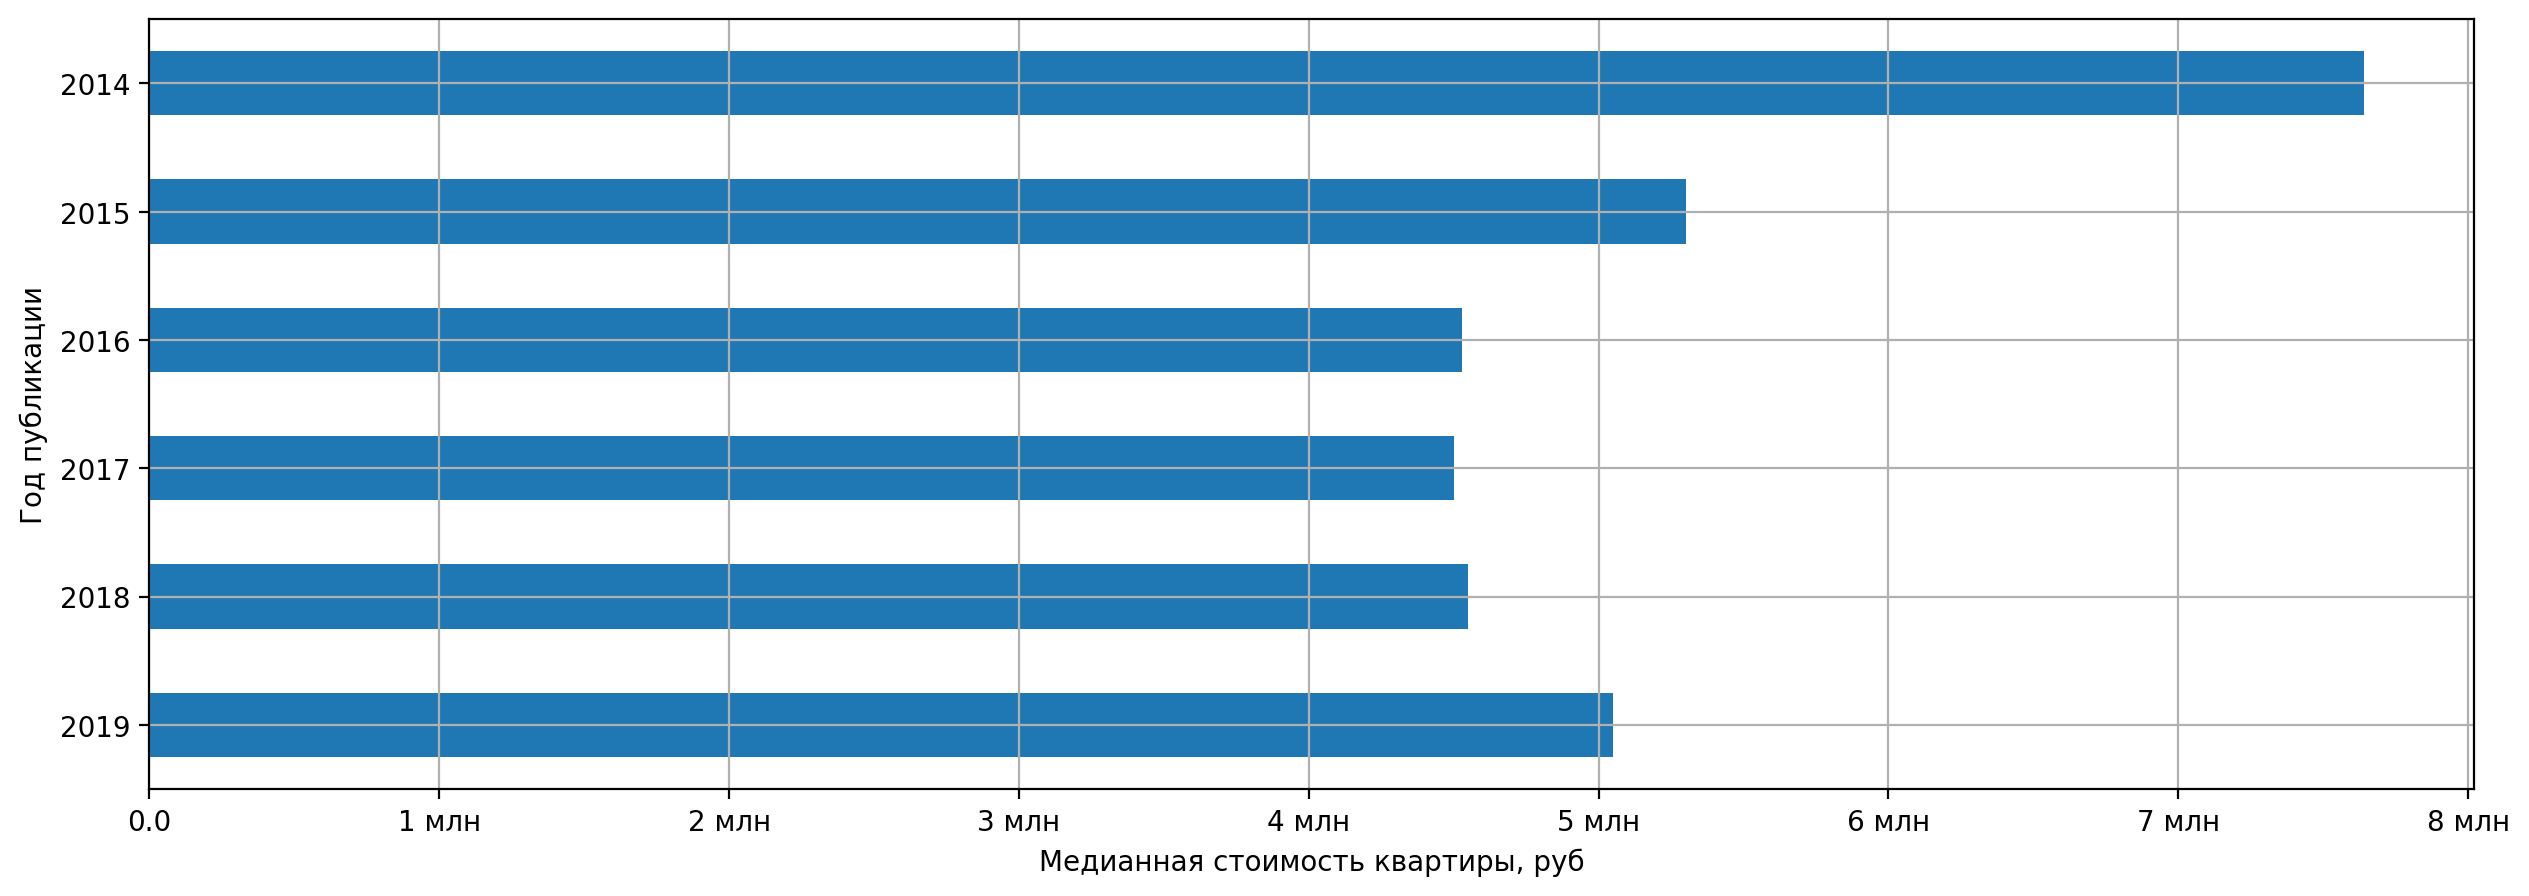

In [213]:
ax = (
    analyzed_data
    .pivot_table(index='exposition_date_year', values='last_price', aggfunc='median')
    .sort_index(ascending=False)
    .plot(
        kind='barh',
        figsize=(15, 5), 
        grid=True,
        legend=''
    )
)
ax.set_xlabel('Медианная стоимость квартиры, руб')
ax.set_ylabel('Год публикации')
ax.xaxis.set_major_formatter(FuncFormatter(pretty_price))

pass

Мы видим, что **стоимость квартир сильно менялась от года к году, наиболее высокой она была в 2014 году.** Причин тут может быть несколько — как общая экономическая ситуация (скачок курсов валют в конце 2014 года), так и изменение структуры предложения на рынке недвижимости (на рынке увеличилось количество небольших студий и однокомнатных квартир).

Посмотрим на зависимость общей стоимости квартир от месяца публикации.

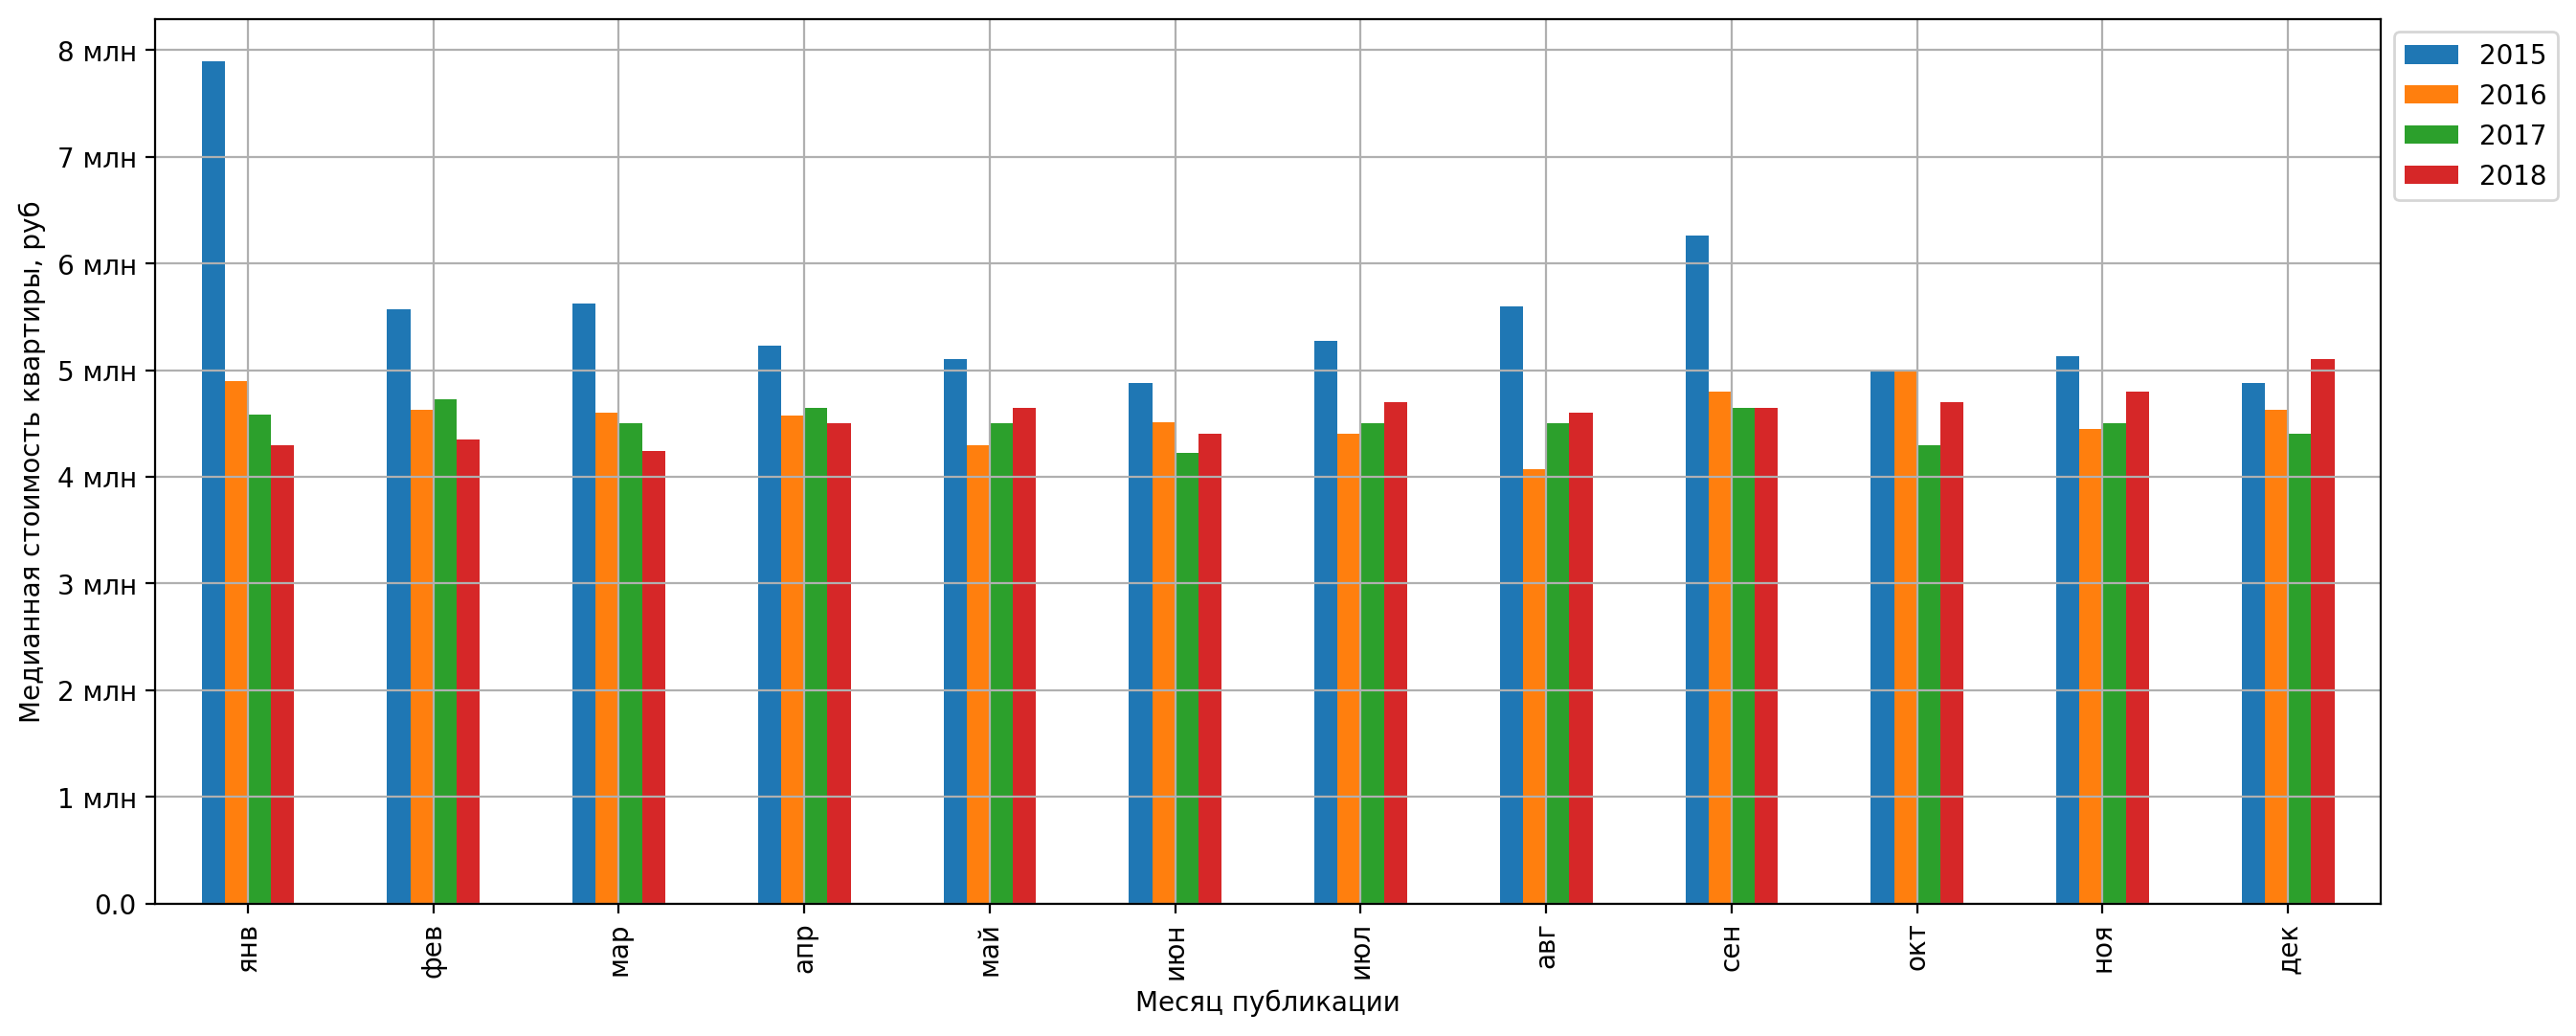

In [215]:
# оставляем для анализа только «полные» годы
full_years_analyzed_data = analyzed_data.query('exposition_date_year > 2014 and exposition_date_year < 2019')

ax = (
    full_years_analyzed_data
    .pivot_table(index='exposition_date_month', columns=['exposition_date_year'], values=['last_price'], aggfunc=['median'])
    .plot(
        kind='bar',
        figsize=(15, 6), 
        grid=True
    )
)
ax.set_xlabel('Месяц публикации')
ax.set_ylabel('Медианная стоимость квартиры, руб')
ax.yaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xticklabels(['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
ax.legend(
    range(
        full_years_analyzed_data['exposition_date_year'].min(), 
        full_years_analyzed_data['exposition_date_year'].max() + 1
    ),
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

pass

Из диаграммы видно, что в разные годы стоимость объектов, опубликованных в разные месяцы, сильно менялась. Например, в 2015 году самым «дешёвым» и самым «дорогим» месяцами стали июнь и январь соответственно, в 2016 — и август и октябрь. В последующие годы аналогично — у каждого года свои «дешёвые» и «дорогие» месяцы. Поэтому **зависимости полной стоимости объекта от месяца публикации не наблюдается**. 

### Средняя цена квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Посчитаем среднюю цену за м² в 10 населённых пунктах с наибольшим числом объявлений.

In [219]:
# построим сводную таблицу по населенным пунктам с количеством объявлений и средней ценой квадратного метра
big_cities_data = analyzed_data.pivot_table(index='locality_name', values='last_price_m2', aggfunc=['count', 'mean'])
big_cities_data.columns = ['count', 'mean']

# оставим 10 населённых пунктов с наибольшим числом объявлений
big_cities_data = big_cities_data.sort_values('count', ascending=False)[:10]

# отсортируем по цене квадратного метра и выведем
big_cities_data.sort_values('mean', ascending=False)

count           mean
locality_name                          
Санкт-Петербург    15643  114523.558119
Пушкин               369  103125.819377
Кудрово              470   95260.846128
поселок Парголово    327   90175.913089
Мурино               586   86041.116024
поселок Шушары       439   78551.344647
Колпино              338   75424.579112
Гатчина              307   68746.146515
Всеволожск           398   68654.473970
Выборг               237   58141.909325

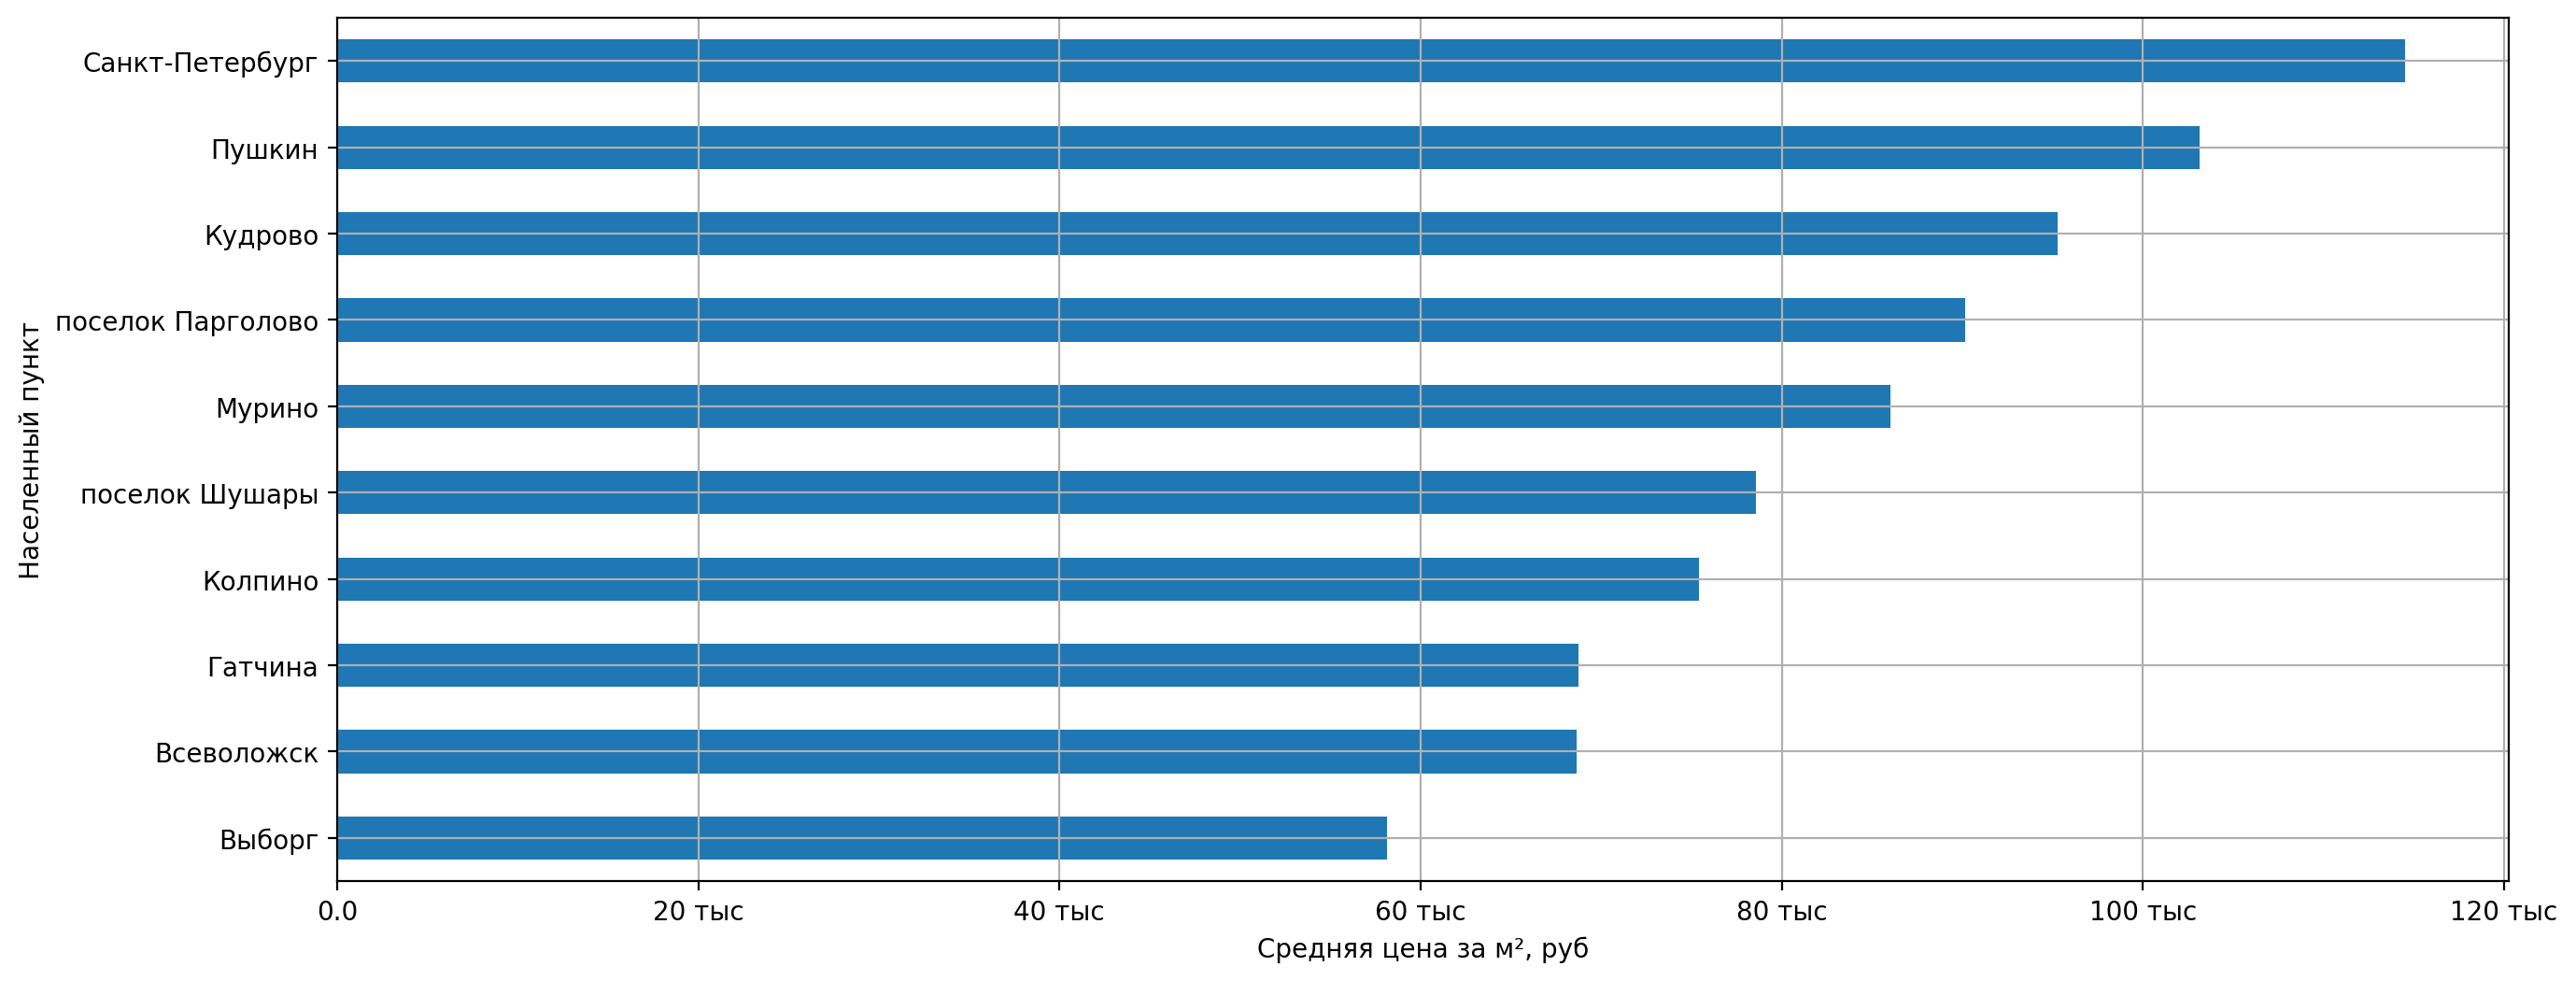

In [220]:
ax = big_cities_data.sort_values('mean')['mean'].plot(
    kind='barh',
    figsize=(15, 6), 
    grid=True,
    legend=''
)
ax.set_xlabel('Средняя цена за м², руб')
ax.set_ylabel('Населенный пункт')
ax.xaxis.set_major_formatter(FuncFormatter(pretty_price))

pass

**В ТОП-10 населённых пунктов с наибольшим числом объявлений самым «дорогим» городом оказался Санкт-Петербург** — средняя цена за м² в культурной столице составляет примерно 114524 рублей. Он побеждает с большим отрывом от второго места, которое занял Пушкин (который город). **На последнем месте — Выборг**, со средней ценой 58142 рубля за м².

### Средняя стоимость на разном удалении от центра

На этапе предобработки данных мы разделили объявления по расстоянию в километрах от центра города (столбец `city_center_distance_km`). Выделим квартиры в самом Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра. При этом убедимся, что для каждого километра есть выборка достаточного размера для проведения анализа.

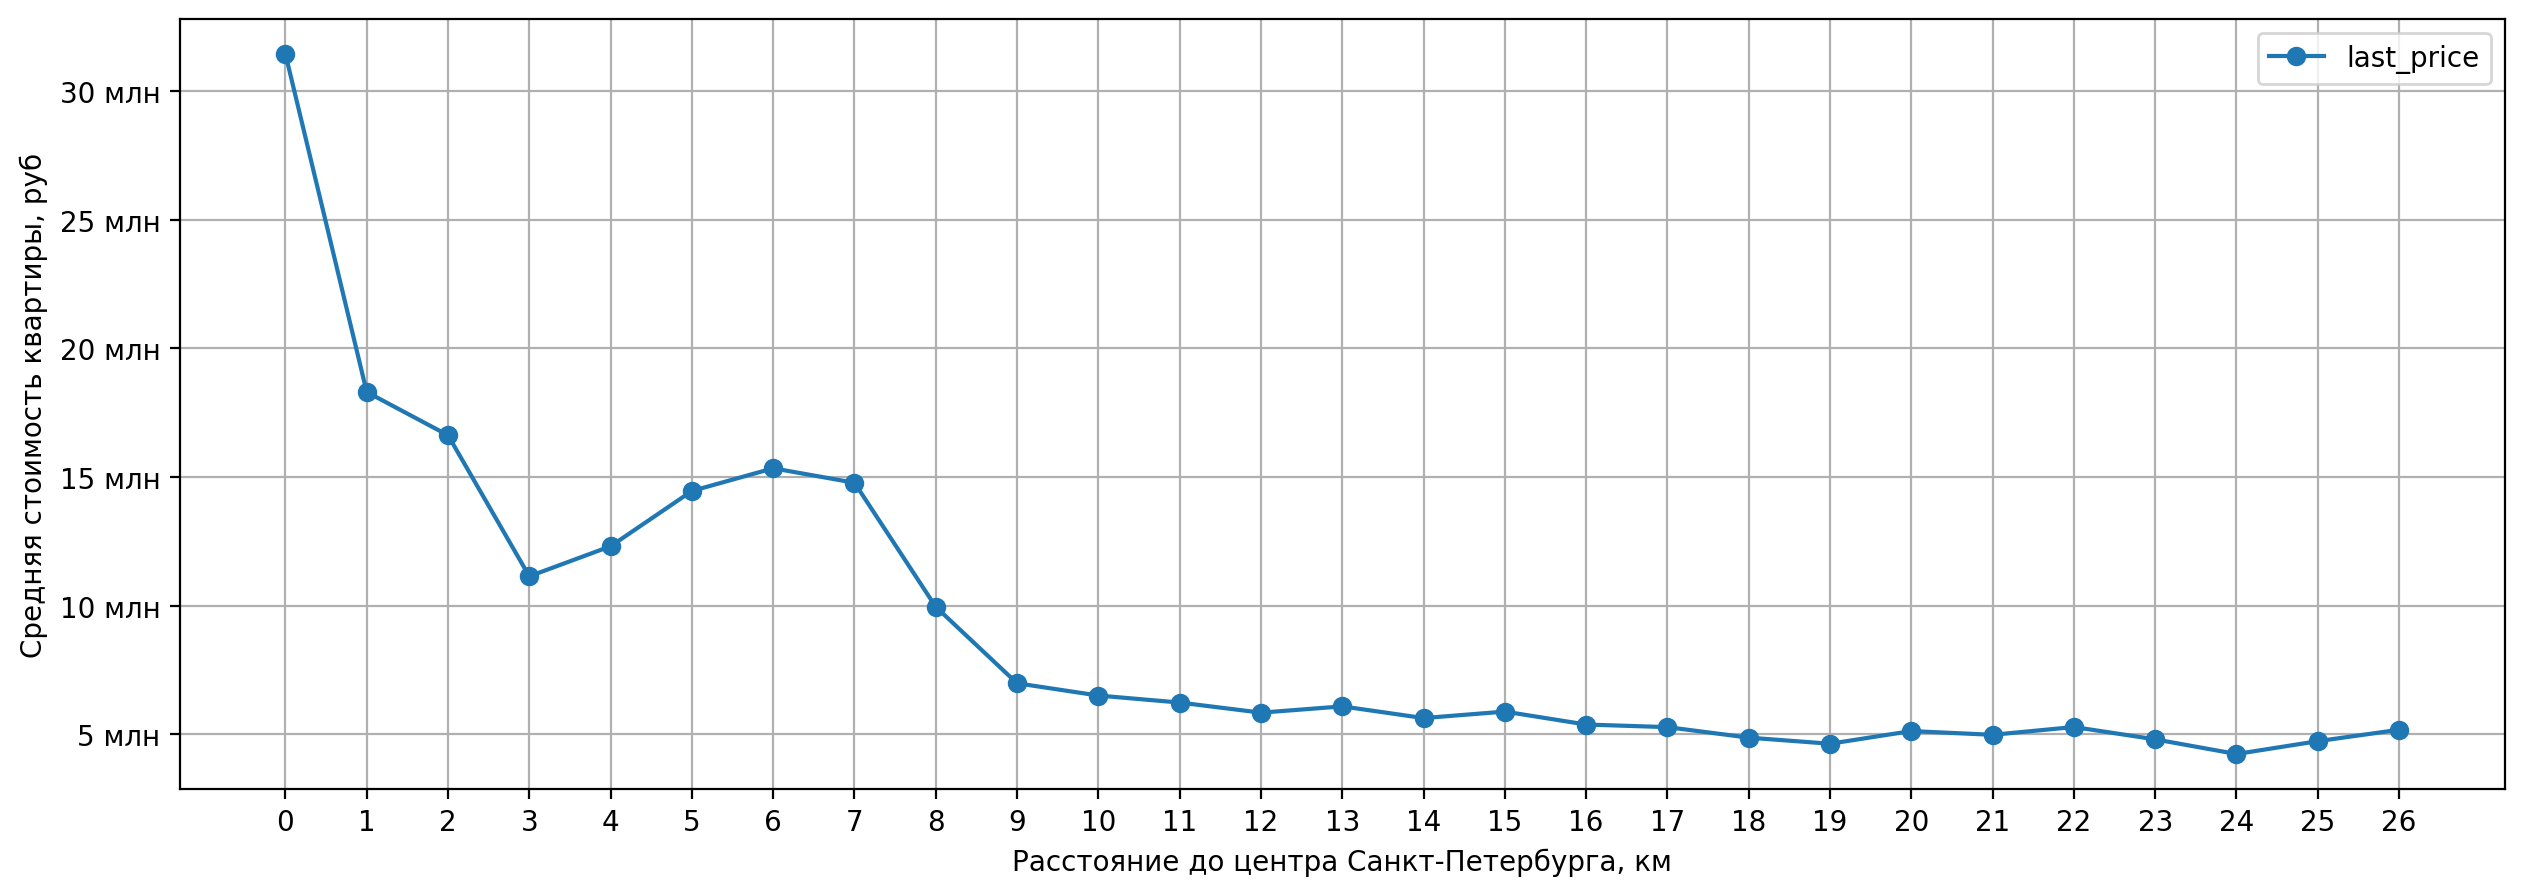

In [224]:
spb_analyzed_data = analyzed_data.query('locality_name == "Санкт-Петербург"')

# серия километров от центра города, 
# для которых есть достаточное количество объявлений, хотя бы 10
km = spb_analyzed_data['city_center_distance_km'].value_counts() >= 10
km = km[km == True]

ax = (
    analyzed_data
    .query('city_center_distance_km in @km.index')
    .pivot_table(index='city_center_distance_km', values='last_price', aggfunc='mean')
    .plot(
        style='-o', 
        grid=True, 
        figsize=(15, 5)
    )
)
ax.yaxis.set_major_formatter(FuncFormatter(pretty_price))
ax.set_xlabel('Расстояние до центра Санкт-Петербурга, км')
ax.set_ylabel('Средняя стоимость квартиры, руб')
plt.xticks(range(int(km.index.min()), int(km.index.max()) + 1, 1))

pass

На графике мы видим, что **квартиры в центре Санкт-Петербурга наиболее дорогие. Чем дальше от центра — тем ниже стоимость.** Однако при приближении к КАД и за его пределами каждый дополнительный километр от центра не оказывает такого сильного влияния на стоимость объекта, как в центральных районах.

## Итоги исследования

**Рекомендации после предобработки данных**

Пропущенные данные в столбцах с высотой потолков и этажностью позволяют сделать предположение: интерфейс по добавлению объявлений не дает возможности указывать диапазоны значений, например, переменную этажность дома, а также разную высоту потолков в квартире.

Для более детального анализа в выгрузку можно добавить дополнительную информацию:
- Регион — «Санкт-Петербург и его населенные пункты» и «Ленинградская область». Упростит работу с геоданными.
- Кем размещено объявление — собственником или агентом. Позволит проанализировать качество заполнения данных, таких как жилая площадь, высота потолков, этажность дома и прочее.
- Квартира в новостройке или на вторичке. Потенциально может сильно коррелировать со стоимостью квадратного метра.
- Расстояние до ближайшего метро. Потенциально может сильно коррелировать со стоимостью квадратного метра.
- Ремонт, отделка. Потенциально может сильно коррелировать со стоимостью квадратного метра.


**Анализ отдельных параметров**

В результате анализа отдельных параметров данных сервиса Яндекс Недвижимость, можно составить представление о наиболее распространненных объявлениях о продаже квартир:
- Большинство выствленных на продажу квартир находится в пределах от 30 до 70 м².
- Чаще всего размещают объявления о продаже одно- и двухкомнатных квартир. Чем больше комнат — тем меньше предложений. При этом медианная площадь комнаты составляет порядка 16 м².
- Кухни в большинстве предлагаемых квартир стандартного размера 6, 8 и 10 м² — похоже на кухни в квартирах с типовыми планировками (6 м² в хрущевках, 8-10 м² в домах серии П-44, например).
- Больше всего квартир продается в пяти- и девятиэтажных домах.
- Самая распространенная высота потолков в выборке — 2.5 метра.
- Доли объявлений о продаже квартир на первых и последних этажах составляют порядка 12% и 14% от общего числа предложений соответственно.
- Основная масса объявлений приходится на спальные районы ближе к КАД.
- Более половины квартир продается в домах вдалеке от парковых зон.
- Медианная цена составляет 95000 за м². В большинстве объявлений цены колеблются от 76000 до 114000 за м².

**Как быстро продавались квартиры**

Средняя длительность публикации объявлений продавцами в сервисе Яндекс Недвижимость составляет 180 дней, медианная — 95 дней. Продажа квартиры обычно занимает от полутора до семи с половиной месяцев. К быстрым продажам можно отнести длительность до полутора месяцев, а к необычайно долгим продажам — длительность от 17 месяцев и более. При этом не стоит забывать, что реальные сроки продаж могут быть меньше — не всякий продавец непосредственно в день продажи будет заходить в личный кабинет и снимать объявление с публикации (система сама снимет объявление с публикации по окончании определенного периода).

**Факторы, которые больше всего влияют на общую стоимость объекта**

Среди факторов, которые влияют на общую стоимость объекта, можно выделить:
- Общая площадь. С ростом общей площади квартиры растет и полная стоимость объекта. Коэффициент корреляции Пирсона — положительный, равен 0.73, что говорит о тесной взаимосвязи общей площади и полной стоимости объекта.
- Жилая площадь. С ростом жилой площади растет и полная стоимость объекта. При этом корреляция менее устойчивая, чем взаимосвязь общей площади и полной стоимости объекта.
- Площадь кухни. Взаимосвязь не линейная. Для квартир-студий и апартаментов с запредельно маленькими кухнями (меньше 5 м²) полная стоимость объекта не зависит от конктерного размера кухни. Однако начиная с 5-6 м² можно наблюдать увеличение полной стоимости объекта с ростом площади кухни. На полную стоимость объекта площадь кухни влияет не так сильно, как общая площадь.
- Число комнат. Чем больше комнат — тем больше площадь квартиры, чем больше площадь — тем выше полная стоимость объекта.
- Тип этажа. Квартиры на первых и последних этажах стоят дешевле квартир, расположенных на «средних» этажах, — на 20% и на 11% соответственно.

Прямой зависимости полной стоимости объекта от даты размещения не обнаружено. На полную стоимость может влиять как общая экономическая ситуация (например, скачок курсов валют). Средние и медианные значения полной стоимости объекта могут зависеть от структуры предложения на рынке недвижимости (например, выход на рынок большого количества небольших студий и однокомнатных квартир).

**Средняя цена квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

В ТОП-10 населённых пунктов с наибольшим числом объявлений самым «дорогим» городом оказался Санкт-Петербург — средняя цена за м² в культурной столице составляет примерно 114524 рублей. Он побеждает с большим отрывом от второго места, которое занял Пушкин (который город). На последнем месте — Выборг, со средней ценой 58142 рубля за м².

**Средняя стоимость квартир на разном удалении от центра**

Квартиры в центре Санкт-Петербурга наиболее дорогие. Чем дальше от центра — тем ниже стоимость. Однако при приближении к КАД и за его пределами каждый дополнительный километр от центра не оказывает такого сильного влияния на стоимость объекта, как в центральных районах.

## Чек-лист готовности проекта

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
    - цена одного квадратного метра;
    - день публикации объявления (0 — понедельник, 1 — вторник и т. д.);
    - месяц публикации объявления;
    - год публикации объявления;
    - тип этажа квартиры (значения — «первый», «последний», «другой»);
    - расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
    - общая площадь;
    - жилая площадь;
    - площадь кухни;
    - цена объекта;
    - количество комнат;
    - высота потолков;
    - тип этажа квартиры («первый», «последний», «другой»);
    - общее количество этажей в доме;
    - расстояние до центра города в метрах;
    - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
    - общая площадь;
    - жилая площадь;
    - площадь кухни;
    - количество комнат;
    - тип этажа, на котором расположена квартира (первый, последний, другой);
    - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.